# Imports and functions

In [3]:
import pandas as pd
import numpy as np
import glob
from scipy.stats.mstats import winsorize
from seaborn import histplot
import seaborn as sns

/Users/angela/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [342]:
import pandas as pd
import pandas as pd
import unicodedata
import re
import subprocess

def fetch_batting_orders(team_abbr, year):
    # Construct the URL based on the team abbreviation and year == batting order
    url = f'https://www.baseball-reference.com/teams/{team_abbr}/{year}-batting-orders.shtml#grid_table_46565'

    try:
        # Read all tables from the page
        tables = pd.read_html(url)

        # Assuming the desired table is the first one
        df = tables[0]
        df.iloc[:, 1:] = df.iloc[:, 1:].map(lambda x: remove_non_alpha(normalize_string(x)))

        df.to_csv('br-lineups.csv', index=False)

        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def fetch_player_stats(team_abbr, year):
    # Construct the URL based on the team abbreviation and year == batting order
    url = f'https://www.baseball-reference.com/teams/{team_abbr}/{year}.shtml#team_batting'

    try:
        # Read all tables from the page
        tables = pd.read_html(url)
        
        # Assuming the desired table is the first one
        df = tables[0]
        df['Name'] = df['Name'].apply(lambda x: remove_non_alpha(normalize_string(x)))

        df.drop(columns=['Rk', 'Pos', 'Age','G','PA','RBI','SB','CS','BA','OBP','SLG','OPS','OPS+','TB','GDP','HBP','SH','SF','IBB'],inplace=True)
        df = df[~df['AB'].str.contains('[a-zA-Z]', na=False)]
        df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
        df = df[df['AB'] > 0]
        strikeout = pd.Series(df['SO']/df['AB'])
        hits = pd.Series(df['H']/df['AB'])
        doubles = pd.Series(df['2B']/df['AB'])
        triples = pd.Series(df['3B']/df['AB'])
        homer = pd.Series(df['HR']/df['AB'])
        singles = hits - doubles - triples - homer
        walks = pd.Series(df['BB']/df['AB'])
        otherout = 1 - walks - singles - homer - triples - doubles - strikeout
        df = df[['Name']]
        df['Strikeout'] = strikeout
        df['OO'] = otherout
        df['Walk'] = walks
        df['Single'] = singles
        df['Double'] = doubles
        df['Triple'] = triples
        df['Homer'] = homer
        df.to_csv('br-playerstats.csv', index=False)

        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def fetch_rbi_rs(team, year):
    url = f'https://www.baseball-reference.com/teams/{team}/{year}.shtml#team_batting'

    try:
        # Read all tables from the page
        tables = pd.read_html(url)
        
        # Assuming the desired table is the first one
        df = tables[0]
        df['Name'] = df['Name'].apply(lambda x: remove_non_alpha(normalize_string(x)))

        df.drop(columns=['Rk', 'Pos', 'Age','SB','CS','BA','OBP','SLG','OPS','OPS+','TB','GDP','HBP','SH','SF','IBB'],inplace=True)
        df = df[~df['AB'].str.contains('[a-zA-Z]', na=False)]
        df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
        df = df[df['AB'] > 0]
        strikeout = pd.Series(df['SO']/df['AB'])
        hits = pd.Series(df['H']/df['AB'])
        doubles = pd.Series(df['2B']/df['AB'])
        triples = pd.Series(df['3B']/df['AB'])
        homer = pd.Series(df['HR']/df['AB'])
        singles = hits - doubles - triples - homer
        walks = pd.Series(df['BB']/df['AB'])
        otherout = 1 - walks - singles - homer - triples - doubles - strikeout
        df = df[['Name', 'R', 'RBI']]
        df['Strikeout'] = strikeout
        df['OO'] = otherout
        df['Walk'] = walks
        df['Single'] = singles
        df['Double'] = doubles
        df['Triple'] = triples
        df['Homer'] = homer
        #df.to_csv('br-playerstats.csv', index=False)

        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None



def normalize_string(s):
    #Normalize Unicode string by removing accents.
    return unicodedata.normalize('NFD', s).encode('ascii', 'ignore').decode('ascii')

def remove_non_alpha(s):
    """
    Remove all non-alphabetic characters from the string.
    """
    return re.sub(r'[^a-zA-Z\s-]', '', s)

def clean_names(series):
    """
    Clean the names in the pandas Series by normalizing and removing non-alphabetic characters.
    """
    # Apply normalization and removal of non-alphabetic characters
    cleaned_series = series.apply(lambda x: remove_non_alpha(normalize_string(x)))
    cleaned_list = cleaned_series.tolist()
    return cleaned_list

# Function to extract score from the first column
def extract_score(text):
    match = re.search(r'\((\d+)-(\d+)\)', text)
    if match:
        return int(match.group(1)) 
    return None

# Function to get lineup indices based on player names
def get_lineup_indices(players_str, player_index):
    lineup_indices = []
    for player in players_str:
        last_name = ''.join(player.split('-')[:-1]).strip().split(' ')[-1]
        # If the last name is found in the player_index mapping
        if last_name in player_index:
            lineup_indices.append(str(player_index[last_name]))

    return str(lineup_indices)


def process_output(stat_df,input_df):
      player_list = stat_df['Name']
      player_index = {
          name.split(' ')[-2] if name.split(' ')[-1] == "Jr" else name.split(' ')[-1]: idx + 1
          for idx, name in enumerate(player_list)
      }
      output_data = []
      for _, row in input_df.iterrows():
          first_column = row[0]
          second_column = row[1:]
          score = extract_score(first_column)
          lineup_indices = get_lineup_indices(second_column, player_index)
          output_data.append([score, lineup_indices])

      output_df = pd.DataFrame(output_data, columns=['Score', 'Lineup'])

      output_df.to_csv('output.csv', index=False)
      return


In [548]:

def normalize_string(s):
    """
    Normalize Unicode string by removing accents.
    """
    # Normalize to NFD form and remove accent marks
    return unicodedata.normalize('NFD', s).encode('ascii', 'ignore').decode('ascii')

def remove_non_alpha(s):
    """
    Remove all non-alphabetic characters from the string.
    """
    return re.sub(r'[^a-zA-Z\s-]', '', s)

def clean_names(series):
    """
    Clean the names in the pandas Series by normalizing and removing non-alphabetic characters.
    """
    # Apply normalization and removal of non-alphabetic characters
    cleaned_series = series.apply(lambda x: remove_non_alpha(normalize_string(x)))
    cleaned_list = cleaned_series.tolist()
    return cleaned_list

def extract(file_pattern):
   
    file_list = glob.glob(file_pattern)
    dataframes = []
    
    # Loop through each output file, which has empirical score, DP-score, and lineup for all games from a given team in given yr
    for file in file_list:
        print(file)
        team = file.split('_')[3]
        yr = file.split('_')[4][0:4]
        prevyr = int(yr)-1
        
        df = pd.read_csv(file)
        #df has columns Lineup, "Score", "Score2" already. Manually compute & add the sabermetric RC estimates. 
        
        url = f"https://www.baseball-reference.com/teams/{team}/{yr}-batting.shtml"
        tables = pd.read_html(url) 
        battingdf23 = tables[0]
        battingdf23 = battingdf23[~battingdf23['AB'].str.contains('[a-zA-Z]', na=False)].dropna()
        battingdf23.iloc[:, 3:] = battingdf23.iloc[:, 3:].astype(float)
        battingdf23['Name'] = clean_names(battingdf23['Name'])

        numrows = df.shape[0]
        teamseries = [team] * numrows
        df['team'] = teamseries

        battingdf23['saber'] = (battingdf23['H'] + battingdf23['BB']) * battingdf23['TB'] / (battingdf23['AB']+battingdf23['BB']) / battingdf23['G']

        
        saber23manual = []
        for i in range(numrows):
            lu = [str(re.sub(r'[^0-9]', '', x)) for x in df['Lineup'][i].replace("'","").replace("[","").replace("]","").split()]

            sumLineup22 = 0.0
            sumLineup23 = 0.0
            for playeridx in lu:
                
                sumLineup23 +=  (battingdf23.at[battingdf23[battingdf23['Rk'] == playeridx].index[0], 'saber'])
            saber23manual.append(sumLineup23)
                
        df['saber23'] = saber23manual
        dataframes.append(df)
    
    # Concatenate all years into a single DataFrame
    dpdf1 = pd.concat(dataframes, ignore_index=True)
    return dpdf1


def extractmulti(file_patterns):
    dataframes = []
    for file_pattern in file_patterns:
        file_list = glob.glob(file_pattern)

        
        # Loop through each output file, which has empirical score, DP-score, and lineup for all games from a given team in given yr
        for file in file_list:
            skipflag = False
            print(file)
            team = file.split('_')[3]
            yr = file.split('_')[4][0:4]
            prevyr = int(yr)-1
            
            df = pd.read_csv(file)
            #df has columns Lineup, "Score", "Score2" already. Manually compute & add the sabermetric RC estimates. 
            
            url = f"https://www.baseball-reference.com/teams/{team}/{yr}-batting.shtml"
            tables = pd.read_html(url) 
            battingdf23 = tables[0]
            battingdf23 = battingdf23[~battingdf23['AB'].str.contains('[a-zA-Z]', na=False)].dropna()
            battingdf23.iloc[:, 3:] = battingdf23.iloc[:, 3:].astype(float)
            battingdf23['Name'] = clean_names(battingdf23['Name'])
    
            numrows = df.shape[0]
            teamseries = [team] * numrows
            df['team'] = teamseries
    
            battingdf23['saber'] = (battingdf23['H'] + battingdf23['BB']) * battingdf23['TB'] / (battingdf23['AB']+battingdf23['BB']) / battingdf23['G']
    
            
            saber23manual = []
            for i in range(numrows):
                lu = [str(re.sub(r'[^0-9]', '', x)) for x in df['Lineup'][i].replace("'","").replace("[","").replace("]","").split()]
    
                sumLineup22 = 0.0
                sumLineup23 = 0.0
                for playeridx in lu:
                    if not battingdf23[battingdf23['Rk'] == playeridx].empty:
                        sumLineup23 +=  (battingdf23.at[battingdf23[battingdf23['Rk'] == playeridx].index[0], 'saber'])
                    else:
                        skipflag = True
                saber23manual.append(sumLineup23)

            if skipflag:
                print('skipping this yr due to indexing')
            else:
                df['saber23'] = saber23manual
                dataframes.append(df)
            
        # Concatenate all years into a single DataFrame
    dpdf1 = pd.concat(dataframes, ignore_index=True)
    return dpdf1


In [721]:
plt.style.use('default') 

# All-team aggregations

## 2

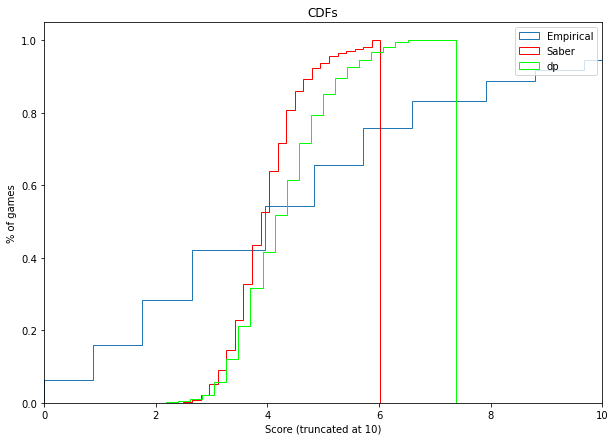

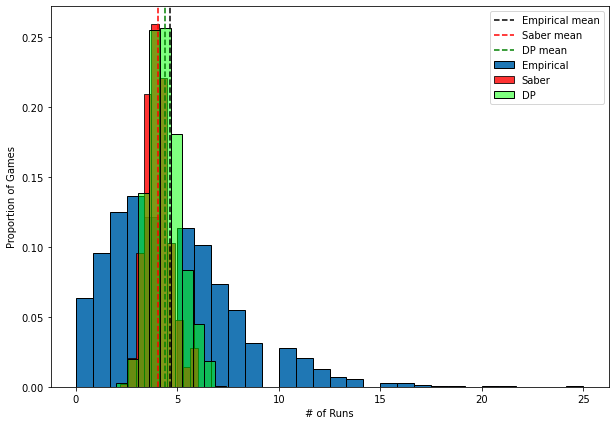

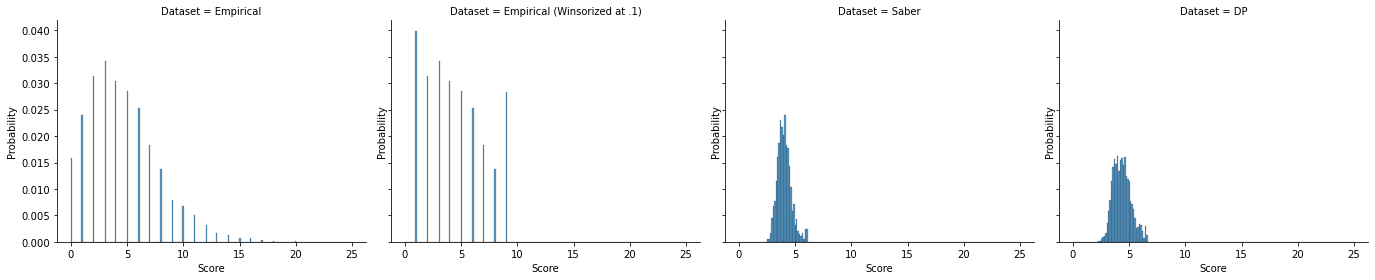

<ipython-input-542-ab2b4321dbf8>:41: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("copper"))
  cmap.set_bad(color='gray')  # Set color for NaNs


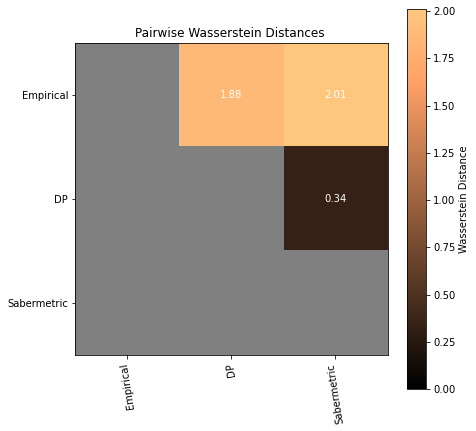

,Source1,Source2,Wasserstein Distance
0,Empirical,DP,1.875370
1,Empirical,Sabermetric,2.013601
2,DP,Sabermetric,0.341028


,Comparison,R^2
0,DP-Empirical R2,0.019496
1,Saber-Empirical R2,-0.006135
2,DP-Saber R2,0.376741


In [542]:
from seaborn import displot

plt.figure(figsize=(10,7))
plt.hist(dpdfnan['ScoreWinsorized'],density=True,cumulative=True,bins=25,histtype='step',label='Empirical')
plt.hist(dpdfnan['saber23'],density=True,cumulative=True,bins=25,label='Saber',histtype='step',color= (1,0,0))
plt.hist(dpdfnan['score2'],density=True,cumulative=True,bins=25,label='dp',histtype='step',color= (0,1,0))
plt.xlim(0,10)
plt.ylabel('% of games')
plt.xlabel('Score (truncated at 10)')
plt.title('CDFs')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
histplot(dpdfnan['Score'],stat='probability',bins=30,label='Empirical',alpha=1)
histplot(dpdfnan['saber23'],stat='probability',bins=10,label='Saber',color= (1,0,0,.1),alpha=.8)
histplot(dpdfnan['score2'],stat='probability',bins=10,label='DP',color= (0,1,0,.2),alpha=.5)

plt.xlabel('# of Runs')
plt.ylabel('Proportion of Games')
plt.axvline(x=dpdfnan['Score'].mean(),color='black', ls='--', label='Empirical mean')
plt.axvline(x=dpdfnan['saber23'].mean(),color='red', ls='--', label='Saber mean')
plt.axvline(x=dpdfnan['score2'].mean(),color='green', ls='--', label='DP mean')
plt.legend()
plt.show()


g = displot(combined_df, x='Score', col='Dataset', kind='hist', stat='probability', height=4, aspect=1.2)
for ax in g.axes.flat:
    #ax.legend(['Empirical (winsorized .05', 'Empirical (Winsorized .1)', 'saber (oracle)', 'dp'], loc='upper right')
    ax.set_xlabel('Score')
    ax.set_ylabel('Probability')

plt.tight_layout()
plt.show()


# Plot the matrix
plt.figure(figsize=(7, 7))
cmap = plt.get_cmap('copper')
cmap.set_bad(color='gray')  # Set color for NaNs

plt.imshow(masked_distances, cmap=cmap, interpolation='nearest', vmin=0)
plt.colorbar(label='Wasserstein Distance')

# Set x and y ticks
plt.xticks(ticks=np.arange(num_axes), labels=['Empirical','DP','Sabermetric'],rotation=99)#, 'Sabermetric oracle'], rotation=90)
plt.yticks(ticks=np.arange(num_axes), labels=['Empirical','DP','Sabermetric'])#, 'Sabermetric oracle'])

# Display the top-right diagonal values
for i in range(num_axes):
    for j in range(i + 1, num_axes):
        plt.text(j, i, f'{distances_array[i, j]:.2f}', ha='center', va='center', color='white')

plt.title('Pairwise Wasserstein Distances ')
plt.show()

display(formatted_df)           
display(r2_df)


## 2A

Empirical Mean:  4.615191986644407
t-test based 95% Confidence Interval:  (4.5241000193599845, 4.70628395392883)


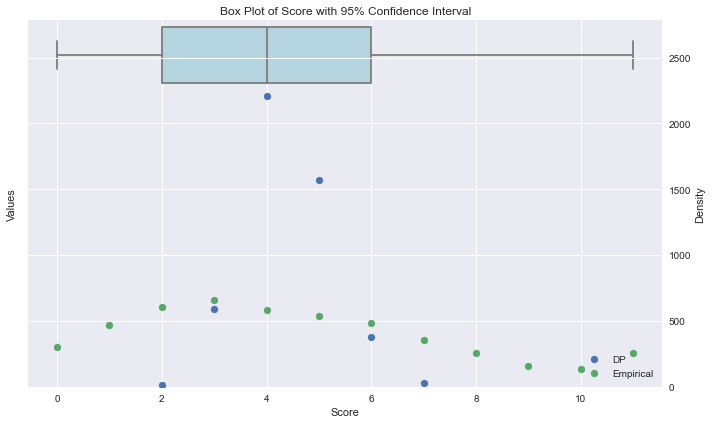

In [717]:

fig, ax1 = plt.subplots(figsize=(10, 6))

# Box plot for 'Score'
sns.boxplot(x='ScoreWinsorized', data=dpdfnan, ax=ax1, color='lightblue')
#plt.vlines(dpdfnan['Score'].mean(),-5,2,label='Empirical Mean')
#plt.vlines(dpdfnan['score2'].mean(),-5,2)

# Add confidence interval
#ax1.vlines(confidence_interval[0], ymin=-0.5, ymax=0.5, color='red', linestyles='dashed', label='Lower CI')
#x1.vlines(confidence_interval[1], ymin=-0.5, ymax=0.5, color='green', linestyles='dashed', label='Upper CI')
ax1.hlines(confidence_interval[0], xmin=-0.0, xmax=0.0, color='red', linestyles='dashed', label='Lower CI')
#x1.hlines(confidence_interval[1], xmin=-0.5, xmax=0.5, color='green', linestyles='dashed', label='Upper CI')

#ax1.vlines(dpdfnan['Score'].mean(),ymin=0,ymax=1)

print('Empirical Mean: ', dpdfnan['Score'].mean())
print('t-test based 95% Confidence Interval: ', confidence_interval)
# Set labels and title
ax1.set_title('Box Plot of Score with 95% Confidence Interval')
ax1.set_xlabel('Score')
ax1.set_ylabel('Values')
#ax1.legend()

# Create a second axis for the rotated histogram of 'saber23'
ax2 = ax1.twinx()  # create a twin Axes sharing the x-axis
#sns.histplot(dpdfnan['score2'], ax=ax2, bins=25, color='orange', alpha=0.6, kde=False, label='DP')
plt.scatter(dpdfnan['score2'].round().value_counts().index,dpdfnan['score2'].round().value_counts(),label='DP')
plt.scatter(dpdfnan['ScoreWinsorized'].round().value_counts().index,dpdfnan['ScoreWinsorized'].round().value_counts(),label='Empirical')

#ax2.vlines(dpdfnan['Score'].mean(),-5,520,label='Empirical Mean')

# Customize the second axis
ax2.set_ylabel('Density')
ax2.set_ylim(0, ax2.get_ylim()[1] * 1.2)  # adjust y-axis limits if necessary

# Highlight points within the confidence interval
within_ci = dpdfnan[(dpdfnan['score2'] > confidence_interval[0]) & (dpdfnan['score2'] < confidence_interval[1])]
#ax2.scatter(within_ci['saber23'], np.zeros(len(within_ci)), color='blue', label='Saber23 within CI', s=10)

# Show the plot
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## 4 A & B: significance of batting order/lineup order

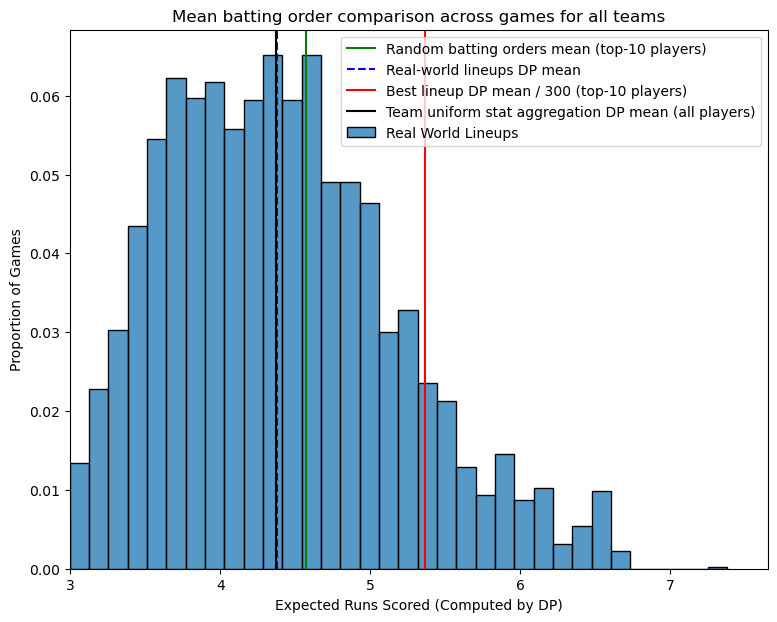

In [769]:
plt.figure(figsize=(9,7))
histplot(dpall, stat='probability',label='Real World Lineups')#,fc=(1,0,0,.8))
#plt.axvline(x=aggmean, c='black', label='Uniform Stats mean (all players from season)')
plt.axvline(x=np.array(randommeans).mean(), c='green', label = 'Random batting orders mean (top-10 players)')
plt.axvline(x=np.array(realmeans).mean(), c='blue', label = 'Real-world lineups DP mean', ls='--')
plt.axvline(max(np.array(bestmeans).mean(),np.array(dpall).mean()), c='red', label = 'Best lineup DP mean / 300 (top-10 players)')
plt.axvline(x=np.array(aggmeans).mean(), c='black', label = 'Team uniform stat aggregation DP mean (all players)')

plt.xlim([3,None])
plt.title('Mean batting order comparison across games for all teams')
plt.ylabel('Proportion of Games') 
plt.xlabel('Expected Runs Scored (Computed by DP)')
plt.legend()
plt.show()

In [766]:
datt = {'Team': teamarr,
        'Real World': realmeans,
        'Random': randommeans,
        'Best (found out of 192)': bestmeans,
        'Team Uniform': aggmeans
}
pr = pd.DataFrame(datt)
display(pr)

,Team,Real World,Random,Best (found out of 192),Team Uniform
0,ARI,4.341176,4.547553,5.004339,4.330048
1,ATL,6.104140,6.120350,7.378463,6.078227
2,BAL,4.394986,4.448047,5.025084,4.412937
3,BOS,4.337035,4.958093,5.182435,4.347457
4,CHC,4.780416,4.733062,5.505101,4.717324
5,CHW,3.272439,3.281292,3.732888,3.230956
6,CIN,4.379150,4.950132,5.302520,4.565998
7,CLE,3.512763,3.967242,4.615457,3.568227
8,COL,3.802623,3.872200,4.758048,3.821057
9,DET,3.595365,4.024495,4.341902,3.668945


In [708]:
print(pr['Real World'].mean())
print(pr['Best (found out of 192)'].mean())

4.378744111259127
5.376599825352235


In [661]:
print_df['Difference'] = print_df['Mean DP for Best (Found) Lineup'] - print_df['Mean DP for Random Lineups']
print("Mean difference between best found (among ~160 real world + 30 random lineups) and random (n=30) lineups")
print(print_df['Difference'].mean())

Mean difference between best found (among ~160 real world + 30 random lineups) and random (n=30) lineups
0.8023697051527293


# 4C

In [9]:
teams = ['ARI', 'ATL', 'BAL', 'BOS', 'CHC','CHW','CIN', 'CLE','COL','DET','HOU','KCR','LAA','LAD','MIA','MIL', 'MIN','NYM','NYY','OAK','PHI', 'PIT','SDP','SEA','SFG','STL', 'TBR','TEX','TOR','WSN']

simvars = []
simmeans = []
for team in teams:
    ogstr = f"Downloads/playersim_{team}_2023.csv"
    try:
        simvar = pd.read_csv(ogstr)[:-2]
        simvars.extend(simvar['var'])
        simmeans.extend(simvar['score2'])
        #print(simmeans)
    except:
        print(f'{team} not found')

#simvars = pd.concat(dfs, ignore_index=True)
#print(np.array(simvars).mean())

simmeans = [x for x in simmeans if x is not np.nan and x >= 0.0001]
#data = {'Empirical Variance (n = 162 * 30)': 
#}
#print(teams)
varsa = []
for team in teams:
    strpattern = f"Downloads/outputs_with_var_{team}_2023.csv"
    try: 
        vardf = pd.read_csv(strpattern)['vari'][:-2]
        varsa.append(vardf)
        #print(vars)
    except:
        pass
vars = pd.concat(varsa,ignore_index=True)

data = {'Distribution': ['Empirical (on real-world lineups)', 'Simulation within-lineup (on real-world lineups)', 'DP within-lineup (on real-world lineups)'],
        'Variance': [ogdf['Score'].var(),np.array(simvars).mean(), vars.mean()]
       }
vardf = pd.DataFrame(data)

display(vardf)

BOS not found


,Distribution,Variance
0,Empirical (on real-world lineups),10.345735
1,Simulation within-lineup (on real-world lineups),9.951559
2,DP within-lineup (on real-world lineups),10.506219


# 4D: stochastic dominance

In [742]:
from scipy.stats import kurtosis
from scipy.stats import skew

#table of these side-by-side
'''
data = {
    'Distribution': ['DP (on real-world lineups)', 'Empirical (on real-world lineups)', 'DP (on random lineups, top-10 players)'],
    'Mean': [ogdf['DPog'].mean(), ogdf['Score'].mean(), np.array(randommeans).mean()],           # Example means
    'Variance': [ogdf['DPog'].var(), ogdf['Score'].var(), np.array(randommeans).var()],       # Example variances
    'Skewness': [skew(ogdf['DPog']), skew(ogdf['Score']), skew(np.array(randommeans))],         # Example skewness values
    'Kurtosis': [kurtosis(ogdf['DPog']), kurtosis(ogdf['Score']), kurtosis(np.array(randommeans))],         # Example kurtosis values
}
'''
sdom = pd.DataFrame(data)
display(sdom)


,Distribution,Mean,Variance,Skewness,Kurtosis
0,DP (on real-world lineups),4.378530,0.643169,0.425378,-0.114331
1,Empirical (on real-world lineups),4.615551,10.396129,0.973766,1.387800
2,"DP (on random lineups, top-10 players)",4.574230,0.488437,0.277065,-0.756041


## 5A

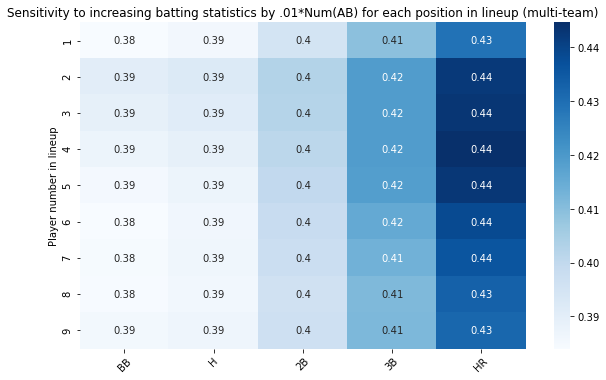

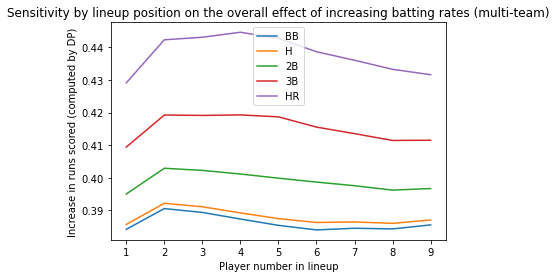

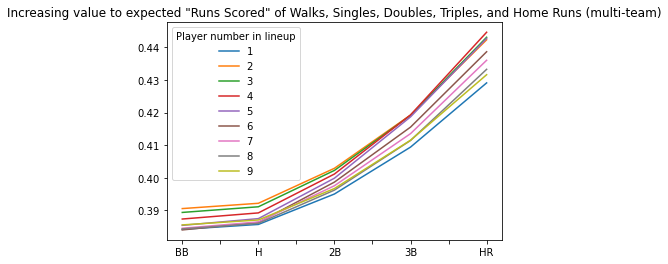

In [512]:
plt.figure(figsize=(10, 6))
sns.heatmap(means_df, annot=True, cmap='Blues', cbar=True)
plt.title("Sensitivity to increasing batting statistics by .01*Num(AB) for each position in lineup (multi-team)")
plt.xticks(rotation=45)
plt.show()

means_df.plot(legend=True)
plt.ylabel('Increase in runs scored (computed by DP)')
plt.title('Sensitivity by lineup position on the overall effect of increasing batting rates (multi-team)')
plt.show()

means_df.T.plot(legend=True)
plt.title('Increasing value to expected \"Runs Scored\" of Walks, Singles, Doubles, Triples, and Home Runs (multi-team)')
plt.show()

## 5B

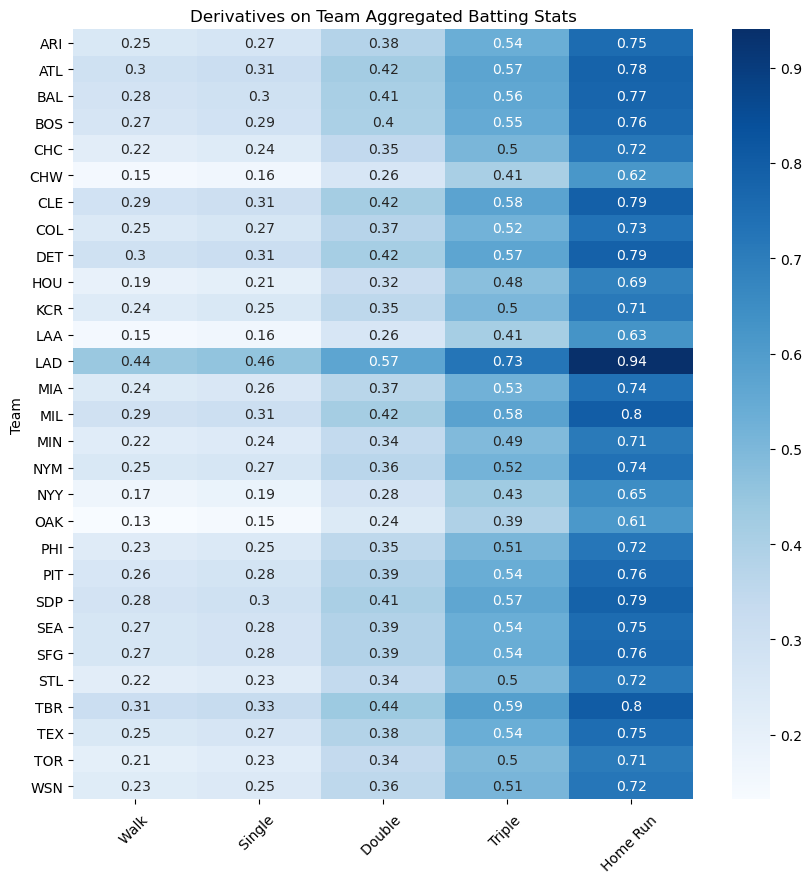

In [746]:
plt.figure(figsize=(10, 10))
sns.heatmap(derdf, annot=True, cmap='Blues', cbar=True)
plt.title('Derivatives on Team Aggregated Batting Stats')
plt.xticks(rotation=45)
plt.show()

# 5C: increase p3 batting statistics while decreasing p6 batting stat, for each deriative

,DP (unmodified),Walk Derivative,Single,Double,Triple,Home Run,Empirical
0,4.306924,4.337836,4.33966,4.351431,4.368585,4.393197,4.765432


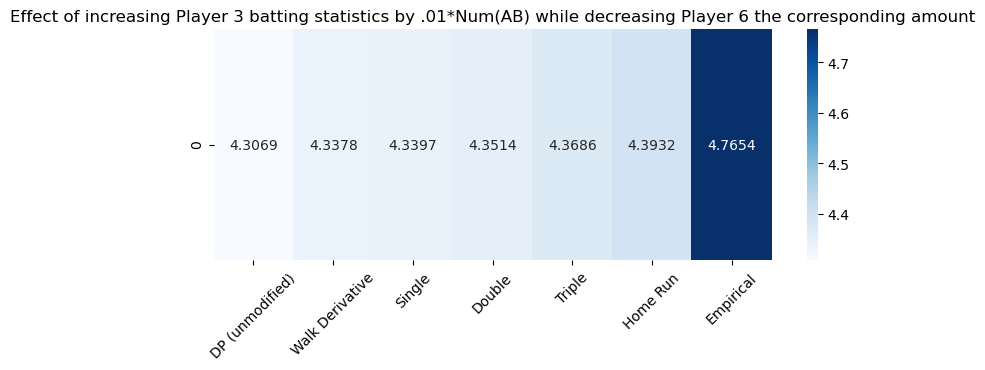

In [765]:
derdf = pd.read_csv('Downloads/outputs_derivative_C_BOS_2023.csv')
#display(derdf.mean())
new_order = ['score2', 'BB', 'H', '2B','3B','HR','Score']

# Reorder the DataFrame
derdf = derdf[new_order]
derdf.columns = ['DP (unmodified)','Walk Derivative', 'Single', 'Double', 'Triple', 'Home Run', 'Empirical']
means_df = pd.DataFrame(derdf.mean()).T

display(means_df)
plt.figure(figsize=(9, 3))
sns.heatmap(means_df, annot=True, cmap='Blues', cbar=True,fmt ='.4f')
plt.title("Effect of increasing Player 3 batting statistics by .01*Num(AB) while decreasing Player 6 the corresponding amount")
plt.xticks(rotation=45)
plt.show()

## 6

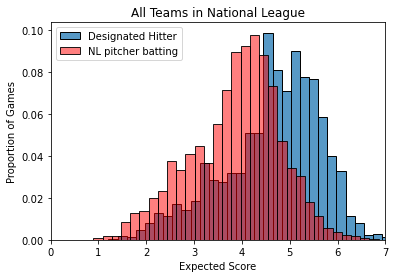

In [465]:
histplot(alldh,stat='probability',label='Designated Hitter')
histplot(allnl,stat='probability',label='NL pitcher batting', color='red', alpha=.5)
plt.title("All Teams in National League")
plt.ylabel('Proportion of Games')
plt.xlabel('Expected Score')
plt.xlim(0,7)
plt.legend()
plt.show()

In [ ]:
## Ma

In [5]:
import pandas as pd
#part 1: writing to DH 
chcDH = pd.DataFrame([4.655889770360686, 4.481758536160897, 4.591009558041288, 4.793842377677884, 4.655889770360686, 4.167745474181938, 4.481758536160897, 4.655889770360686, 4.591009558041288, 4.655889770360686, 4.591009558041288, 3.678136848166038, 4.591009558041288, 4.655889770360686, 4.655889770360686, 4.591009558041288, 4.758509701797907, 4.758509701797907, 4.544412500270527, 4.596332755952481, 4.173115597306247, 4.46292727957386, 4.309916271281299, 4.487139587733101, 4.714992697720511, 4.689015387426224, 4.289505018074897, 4.428006424137666, 4.31904164175872, 3.559913694618873, 4.328838766025546, 4.466664857767347, 4.25336982065158, 4.169585270535381, 3.7991481105267892, 3.6017653797258014, 4.386117758404964, 3.981571740362348, 4.674161044105247, 4.881427482929907, 4.869911721416348, 4.324422506281488, 3.5542319905503486, 4.878264044814477, 5.0685494119962735, 4.878264044814477, 3.843199384149727, 4.587866110528315, 4.787983329648079, 4.587866110528315, 4.587866110528315, 4.965453653302235, 4.965453653302235, 5.112787015251567, 3.8808543830605964, 4.656477516594237, 5.119596748701872, 4.601646135316736, 3.8785700403951346, 4.835584669164932, 4.5750563771838815, 3.8636169951819777, 4.8085907389908416, 4.747064711029486, 4.873261873581609, 4.552769158055213, 4.747064711029486, 4.006989792608891, 4.563482245136367, 5.100985268330593, 3.7783607648700492, 4.747064711029486, 4.624054957220126, 4.6743585689828455, 4.575225067305194, 4.970356184326245, 4.808923837613041, 4.736055482562964, 3.577909696367918, 4.351421495366071, 4.447588295801972, 4.9866301106508715, 4.969071401672221, 5.180824529484944, 5.056917394637284, 4.7421647597519225, 4.839047140631246, 4.654254891106822, 4.610030865974139, 5.195493881371693, 5.204321744904976, 5.043322118556276, 4.81088230430264, 4.755814214955814, 5.088791870862186, 4.993503984677761, 5.122036005396728, 4.814395510527437, 5.112347235343873, 4.911247897937972, 4.874476306475327, 4.877023023626151, 5.0160530919668584, 4.622504582231591, 4.590997529992893, 4.232494902130067, 4.425235128669003, 4.612152024668193, 4.735461138400099, 4.735461138400099, 3.8906450723997774, 4.755282267970153, 4.061811024715257, 4.188662986399541, 4.26445759252626, 3.845665663177778, 3.6730722181629147, 4.49966622965197, 3.9823170627932183, 4.331550088524801, 4.241920014692925, 4.218999666855108, 4.729663738659032, 4.510577424132055, 4.628545331728166, 4.636335673107047, 4.698321331375137, 4.091124870029046, 4.900594115057828, 3.9842306878470684, 4.79124737512158, 1.0e-323, 0.0, 0.0, 5.053289924272321, 5.0e-324, 5.171394262504993, 5.053289924272321, 5.1937001322397, 1.0e-323, 5.008300298028861, 5.008300298028861, 5.1937001322397, 5.0e-324, 5.0e-324, 0.0, 0.0, 5.0e-324, 0.0, 3.7605491612855335, 4.687623873435136, 4.530387645743243, 4.272412241652775, 4.827209517531327, 4.234338593701389, 4.964187459342237, 4.36891696815199, 4.96353383938615, 4.96118844203147, 3.323431445836876, 3.085778728426267, 3.323431445836876, 0.0, 0.0])

chcDH.to_csv("Downloads/outputs_DH_CHC.csv",header=['score2'])

In [7]:
cinDH = pd.DataFrame([5.48578191609495, 5.69897648778478, 5.472421237518634, 5.187386141846681, 5.187386141846681, 5.292787761154609, 5.703511044600247, 5.187386141846681, 5.115728002682591, 5.48578191609495, 5.48578191609495, 5.99885671830668, 5.711069096760879, 5.699603755736139, 5.502875625477223, 5.203113800961921, 5.484250369073589, 5.459675581286678, 5.565358568621322, 5.699603755736139, 5.398555305805006, 4.983401048014124, 5.043496715624736, 5.500413681233415, 5.371033504528224, 5.101777420458986, 5.371033504528224, 5.696107958565223, 5.616448185019257, 4.405893115861383, 5.177652806113931, 4.7893361270276165, 4.7893361270276165, 5.026110484418068, 4.877504399729442, 4.395782670996009, 4.8780132432877465, 4.547579156777456, 5.045194647392929, 4.864817818114516, 4.803368416331786, 5.160975433821829, 5.314237402469766, 4.6390613931115565, 5.075025726276082, 5.319934169482812, 5.319934169482812, 4.283212233951508, 5.295548406356552, 5.335806179615992, 5.34761179914016, 4.367277714625997, 5.34761179914016, 4.952512762820075, 4.723385194253921, 4.771613142321092, 5.033832397463009, 5.323162979815505, 5.575600193961218, 5.762673652055113, 5.575600193961218, 5.762673652055113, 5.762673652055113, 6.044028909825558, 5.217202299053707, 5.272332543033477, 5.762673652055113, 5.762673652055113, 6.054120175546963, 5.065281984036508, 5.5956334992358014, 4.98248613887008, 5.788978921329209, 6.044028909825558, 5.788978921329209, 5.215988568853842, 4.92115271178255, 5.596811605269384, 4.743169494400338, 5.467457141524794, 5.797448007187188, 6.057923124052058, 5.797448007187188, 5.068853955123068, 5.3241448956825295, 4.905678107009379, 5.788978921329209, 5.777280686889869, 5.446367249572141, 5.709799783723167, 5.788978921329209, 5.392202948283181, 4.7722871409854974, 5.392202948283181, 5.565580927136963, 5.844989075100584, 5.84063898295565, 5.125793513789524, 5.381683807024331, 5.54173536674571, 5.400153378245295, 5.8275647166391185, 5.060916694704792, 5.048898299605892, 5.05626404015177, 5.203901501389158, 5.409715349716574, 5.29500367438867, 6.026887129524914, 5.630871886642633, 5.171716610400306, 5.571729685392738, 5.857869391977598, 5.269362487555514, 5.41756560288597, 5.753581272716777, 4.946955266676696, 5.623858873046277, 5.637273181867666, 5.39896969795613, 5.093548977777671, 5.04753554189603, 5.512800704443334, 5.260238742401732, 5.397946936262411, 4.577205764721263, 4.825751260652825, 5.256268135770582, 5.480432279010633, 5.1839716695110045, 5.1839716695110045, 5.685929450759996, 5.685929450759996, 5.1839716695110045, 5.902152747396508, 5.902152747396508, 5.902152747396508, 5.1839716695110045, 4.592025236858551, 5.1839716695110045, 5.1839716695110045, 5.643784187246299, 4.965829855227522, 5.264223222452392, 5.543023723533851, 4.730687357219086, 4.967544539723847, 5.53963955999506, 5.361043798717091, 4.539068147507835, 5.082068400662742, 5.3960137037663785, 5.394119854905369, 5.3960137037663785, 4.9920757895745576, 4.140982886316184, 5.49722734317629, 5.5172747832154485, 4.732003965378175, 5.154529998247159, 5.557977182764253, 5.399137371231764, 0.0, 4.18708240031312])
cinDH.to_csv("Downloads/outputs_DH_CIN.csv",header=['score2'])
milDH = pd.DataFrame([4.090193057877044, 2.5717538700845446, 3.0924098403406584, 2.963542591406495, 4.225904404073459, 4.014269040262092, 3.528037357724626, 3.767114752904895, 4.846286856424199, 3.5473671868560164, 3.466454863695186, 3.6024099596545147, 3.4105486582720457, 3.4105486582720457, 3.4545627530376675, 3.4673919816074164, 3.386167644713768, 3.703719472598895, 3.4636006942515047, 3.373550405744857, 3.2345910192762344, 4.033016763335111, 3.582564590335692, 3.8473165303576717, 4.169923174720542, 3.9470184668383617, 3.9308295811108644, 3.939393652464339, 4.714597373889791, 4.00569499383876, 3.9442471869887763, 3.837420127480075, 4.49775674126044, 4.330219464626735, 3.837420127480075, 3.836668902137214, 4.133384263774584, 4.083270222665366, 4.352921460207944, 4.143489419987693, 4.056128908500542, 4.701604746936987, 4.276449668198543, 4.109992479188572, 4.389682999214333, 4.435985606534387, 4.498535285758777, 4.896686049527984, 3.7315624100405254, 4.0270616812207525, 4.706543648705777, 4.1621935511687385, 4.452794235221855, 4.644619779385081, 4.755974996322339, 4.452794235221855, 4.604031317363316, 4.56241268608905, 4.65899610447264, 4.604031317363316, 4.604031317363316, 4.943447853777206, 4.877996206480132, 4.428298075055847, 4.707281879383251, 4.877996206480132, 4.877996206480132, 4.20109483636797, 4.877996206480132, 4.822052114006061, 4.555215892515323, 4.533516069359599, 4.822052114006061, 4.822052114006061, 4.583445039988031, 4.2367385539393165, 4.744427487727294, 4.233456776214254, 4.325625466600955, 4.786661768495786, 4.232962631306585, 4.063469454446106, 4.232962631306585, 4.325625466600955, 4.0645647407772865, 4.232962631306585, 4.325625466600955, 4.756807003260417, 4.325625466600955, 4.786661768495786, 4.790337294886864, 4.790337294886864, 4.665972105654777, 4.665972105654777, 4.753426694697792, 4.739820366983416, 4.665972105654777, 5.194875575883896, 5.215384917268192, 4.556135534326218, 4.5413952135022395, 5.0130064665756215, 5.034045993210871, 4.572099165340358, 5.044493950610564, 4.572374340221808, 4.989884251740943, 4.989884251740943, 5.044493950610564, 4.989884251740943, 5.017283450012007, 4.422862047859129, 5.044493950610564, 4.763901309209248, 5.155468780807302, 4.697791436953637, 4.650330264547832, 5.120132359054082, 5.182450691658946, 5.1387642547704235, 4.685340693132059, 5.182450691658946, 5.1610176931193115, 4.424931183691174, 5.1939845730402, 5.169033372310479, 4.885372531259714, 4.428479860745779, 5.025043576039824, 5.406457225554735, 4.75653762233024, 4.417323119529084, 5.088635258225503, 5.264844197927982, 4.506888669531899, 5.2743349910227515, 5.291963503840366, 4.210249515159438, 4.449271064010674, 4.934585040343208, 4.4475320678733725, 5.333142447471039, 5.2886167711511, 4.859010664380275, 5.290703410623311, 5.206078909922968, 4.993929423617065, 4.74451828921206, 4.496905842648049, 4.7417207588331545, 5.083202251585178, 4.8826802700507965, 5.109400497240509, 5.244183148219241, 5.201761164977205, 5.086171524149325, 5.032256644916376, 4.73503163409664, 4.14289034561287, 5.155236735263893, 5.047459949235045, 4.665619287537464, 6.64610465410136e-310, 4.192305438377618])
milDH.to_csv("Downloads/outputs_DH_MIL.csv",header=['score2'])
pitDH = pd.DataFrame([3.6383124615551563, 3.187026354846731, 3.275544010635274, 3.104730959786946, 3.324123194219684, 2.816556734574629, 3.130823254728474, 3.5513518878266948, 3.150053828199418, 2.9003334183551304, 3.278473541112837, 2.8826732095844383, 2.916896997106916, 3.188179251947272, 3.347193306538937, 2.840290638930045, 2.76650381555738, 2.6964470318111395, 2.5177503350498123, 2.553430793780029, 2.3677822250429843, 2.5177503350498123, 3.2876058944795674, 2.625816541643798, 3.2909017536942917, 3.2249534749866524, 2.9074256225527466, 2.9696168673777477, 3.239663222326147, 2.27904545497108, 2.8466921683139312, 2.6209227572647897, 1.8672342206529404, 2.8854059741239104, 2.604255588881239, 3.198607986344214, 3.229953216856188, 3.0137471306258683, 3.229607845439224, 2.5070310254696064, 2.7437651632580544, 3.223376129496257, 3.2353405825966353, 2.5469436716898373, 3.223376129496257, 2.310510105621058, 3.491745830861414, 3.5974198916152362, 2.9997982456878187, 3.454290318853608, 3.20442188963739, 3.038377172384867, 2.8012379341396736, 2.9803066463384154, 3.4050891367711444, 3.1890654331318484, 3.193459812415634, 3.409713404367077, 3.5621201200589896, 3.271979252110232, 3.1501660072381004, 2.87686696893927, 3.499355754422503, 3.797847749591422, 3.1604661225125827, 4.005856671903956, 3.302782099616155, 3.5805412224784106, 3.4715157566955654, 3.3798114609913927, 3.5621201200589896, 3.4715157566955654, 3.454934036286388, 3.354897803869358, 3.20379916283672, 3.797255640465521, 3.9149097963359525, 3.1732123267543852, 3.299027985670148, 3.386858106563232, 3.282306383716884, 3.282306383716884, 3.0392288807112005, 3.646643024443829, 3.2953687090793005, 3.182539999620102, 3.0371786093426194, 3.611520528680284, 3.919989031713408, 3.3906745967940406, 3.7548000658466067, 3.680000615039923, 3.435058634324986, 4.399775216208606, 3.618469195049713, 3.1333556813874344, 3.680000615039923, 3.3362801982039216, 3.079141355224561, 4.27720746112363, 4.272996831037222, 4.19140547112162, 4.272996831037222, 4.272996831037222, 4.224034510563762, 4.029300481598657, 3.4738338043891273, 4.344313245913206, 4.169720006781793, 4.0255225615105426, 4.151987169639249, 4.522523455040569, 4.2032008934837854, 4.1584228147328774, 3.923086623150372, 4.240962265895611, 3.8124547434326734, 4.428366078395659, 4.683868815222672, 4.704230298641778, 4.6231234281392135, 4.6842714789125655, 4.744701513176123, 4.287424869307306, 4.583077264460346, 4.639372270291495, 4.690785735735691, 4.25145285474938, 4.5611225668786055, 4.262549098140333, 4.727777254815531, 4.658425033251273, 4.445962271953418, 4.858873377040891, 4.192693266464772, 4.3430588739201745, 5.228620783466276, 4.787610892262887, 4.552456708881201, 4.925029471297871, 4.787610892262887, 4.783056063149434, 4.573712449628456, 4.878945454782423, 4.96760867067493, 4.552456708881201, 5.018776441799623, 4.230924822987685, 4.039751811773543, 4.53025802802346, 4.412856598607227, 4.348231491808159, 4.552456708881201, 5.180849867157944, 4.53025802802346, 5.344528191431658, 4.5236929051638715, 4.648233070604496, 4.8420527057281415, 4.166880456954393, 5.719060120476367, 4.6290853916918255, 0.0, 2.57386807040238])
pitDH.to_csv("Downloads/outputs_DH_PIT.csv",header=['score2'])

In [98]:
sfgDH = pd.DataFrame([5.836918376021492, 5.780439124035542, 5.355420335433979, 5.885501134337668, 6.2050286531488945, 5.145199234415765, 5.645932850692029, 5.72017565504054, 5.624351596977787, 5.898160957730164, 6.1010816746844085, 5.24199665574853, 6.208760401702755, 6.032940697339805, 5.267703851098123, 5.559113475275993, 6.018596331921772, 5.017899583118694, 5.107166378339067, 5.850920637003276, 5.300341679473741, 5.418835877444865, 6.107193482912029, 5.250102993872075, 5.775429584803135, 5.831835644258747, 6.075472133192039, 4.682738835729222, 5.513261109059912, 5.1076596278685304, 5.918788748636377, 6.046817739270194, 5.658166827032245, 6.180038142275067, 6.180038142275067, 5.660841721888438, 5.182022610460625, 6.180038142275067, 5.308024531426593, 5.574133734446707, 5.500077964419071, 5.516709578432542, 5.430129681698916, 5.41492134531912, 5.9641688237495964, 5.763689254940582, 4.931702407322933, 6.119739118647159, 5.599537378174933, 4.8256352460558, 5.147567902903256, 5.474791226361287, 4.5143660932016845, 5.659268665059654, 5.034170515566109, 5.273604440005313, 5.442118906165157, 4.516517847445721, 4.73258802339269, 5.673293879675585, 4.8027917575505, 5.557879428072685, 5.709969337452289, 4.886658810934341, 5.862725242092565, 5.095642335155723, 6.059461278018618, 5.7974936706824165, 5.107994680181838, 5.944343707230516, 5.800190006591977, 5.653986289045913, 6.109884739686002, 5.280054844430075, 5.227478395630991, 5.0408257963272955, 5.402926876357933, 5.5055134742703675, 5.281981293759005, 5.5055134742703675, 5.609111221466884, 5.026456740953698, 4.737915503669269, 4.541439909538914, 4.759849888042096, 4.851674444473952, 5.403425164921847, 5.305608305534858, 5.0408257963272955, 5.0408257963272955, 5.256100095398425, 4.971234451463289, 5.28254189754665, 5.07863983175365, 5.33242049587335, 5.303507789287929, 4.933042037636897, 5.07271374394301, 5.23027409139995, 5.836736288360429, 5.403710965682576, 5.532560617305798, 6.043175072743734, 5.593512943075771, 6.147909209729844, 5.9518312852167, 5.374830884288429, 5.3417811121493814, 5.412691870723835, 6.061381674709097, 6.061381674709097, 5.684458712642953, 6.061381674709097, 6.848261064389963, 5.551946423910614, 5.884537623546404, 6.410983071799599, 5.509065673131787, 6.410983071799599, 6.174626356298928, 5.551946423910614, 5.9607042989158865, 6.416275893939842, 6.323403989433988, 5.978455131191203, 5.544263590349635, 5.115411719366264, 5.8464182004909, 5.8941391442947495, 6.09048308822716, 5.914801152125088, 6.2380841542590435, 6.731695144401849, 5.8935054270364455, 6.762421975061766, 6.266675466636344, 5.684798436330302, 6.120830864725603, 6.304428316318316, 5.680731738951134, 6.401310946490087, 6.401310946490087, 5.889918191336288, 6.272622607571292, 6.176692070810771, 6.4038867785237805, 6.576690278228196, 6.866355752236865, 5.684798436330302, 6.304537805613774, 6.401310946490087, 6.401310946490087, 5.902833875130047, 6.401310946490087, 6.005199244229209, 5.963494511216581, 5.878411444029707, 6.026439206221074, 6.407067518656926, 6.397769171359574, 5.6299977639784995, 5.921226381771028, 6.53311521669546e-310, 5.1232002061135])
sfgDH.to_csv("Downloads/outputs_DH_SFG.csv",header=['score2'])

In [88]:

MIA2021 = pd.DataFrame([2.8889693959989624, 3.2481765082494953, 2.743118135355261, 2.795167879861001, 3.0063622319641987, 2.9197649165280497, 2.804160977802007, 2.9636561550179255, 2.6435256469541457, 2.9417948904663813, 3.145060938366234, 2.8980694633138144, 2.9322837973919937, 2.8359690191945606, 2.9116521649910605, 3.1325433793352526, 3.020295585810678, 2.841267395742506, 2.607401468343018, 3.175550328596676, 2.6686152303871324, 3.7566867912469055, 3.2218422504302557, 3.018134693989202, 3.210968742009118, 3.1448996862021277, 2.9372199776976258, 2.319603335336115, 2.976458873639887, 3.451529951462315, 3.08802781957214, 3.0445835667473986, 3.0742376721809057, 3.0698962576134856, 2.9426144413650737, 3.122661464331241, 2.767162794723619, 2.692068509232179, 3.1096475491059197, 2.9511579333250113, 2.9076283100029245, 2.7853472293051995, 3.2489077220237963, 2.9268285008396244, 2.6345236227768765, 2.9897420259502256, 2.8910514437689723, 2.768872619191529, 3.22116331074273, 2.656152355110848, 2.6553124250824003, 3.2675350486804717, 3.2442922139438264, 3.701165839894469, 3.7518906257637554, 3.140656142841104, 2.7440835777381523, 2.5473313664100843, 2.4690647738696754, 3.861932120808049, 2.8638909970742126, 2.9879820070245016, 2.652449051794343, 2.872898765947423, 2.9451614484579873, 2.643693721732351, 2.927585476351159, 3.058867671118559, 2.860126480128341, 3.041409785882918, 3.011579427617305, 3.1780793912977487, 3.0200589255378376, 3.0228264136568384, 3.041409785882918, 3.12667994183873, 3.0921293714936846, 3.1808495024947687, 2.8247224559919726, 2.8678950026687753, 3.095017010724393, 3.1968960399762176, 2.813025886963529, 2.927387695102145, 2.959672233491686, 3.798055760874329, 3.1062184135558377, 6.86951858750685e-310, 3.0788645102751713, 2.8841191827428725, 3.126980474590273, 2.895694300314922, 2.5825092236585023, 2.808655384043593, 2.7888562448633203, 2.337085046433545, 2.4130213940843603, 2.2865033250841784, 2.443187304526422, 3.0457133627593826, 2.3456011500807525, 3.3642979665339086, 3.5049574849083447, 6.86951858755744e-310, 6.8695185875606e-310, 6.86951858756377e-310, 6.86951858756693e-310, 6.8695185875701e-310, 6.86951858757325e-310, 6.8695185875764e-310, 6.8695185875796e-310, 6.86951858758274e-310, 6.8695185875859e-310, 6.86951858758906e-310, 2.599579219455317, 6.8695185875954e-310, 6.86951858759855e-310, 6.8695185876017e-310, 6.86951858760487e-310, 6.86951858760803e-310, 6.8695185876112e-310, 6.86951858761436e-310, 6.8695185876175e-310, 2.9071441403744402, 6.86951858762384e-310, 6.869518587627e-310, 6.86951858763017e-310, 6.86951858763333e-310, 6.8695185876365e-310, 6.86951858763965e-310, 6.8695185876428e-310, 3.111003346736049, 2.8750616116571748, 6.8695185876523e-310, 6.86951858765546e-310, 2.9422402556831915, 6.8695185876618e-310, 6.86951858766495e-310, 6.8695185876681e-310, 6.86951858767127e-310, 6.86951858767444e-310, 6.8695185876776e-310, 6.86951858768076e-310, 6.8695185876839e-310, 6.8695185876871e-310, 6.86951858769025e-310, 6.8695185876934e-310, 6.86951858769657e-310, 6.86951858769973e-310, 6.8695185877029e-310, 6.86951858770606e-310, 6.8695185877092e-310, 6.8695185877124e-310, 6.86951858771554e-310, 6.8695185877187e-310, 6.86951858772187e-310, 6.86951858772503e-310, 6.8695185877282e-310, 3.5241345551997956, 6.8695185877345e-310, 6.8695185877377e-310, 6.86951858774084e-310, 6.869518587744e-310, 2.6582294536673823])
MIL2021 = pd.DataFrame([3.5597412694096007, 2.288536345959501, 2.865509921768915, 2.548812982270657, 3.5219817189620133, 3.536011682187046, 3.1267967760310005, 3.410996409016774, 4.149405051858553, 2.933296209249692, 3.0321614465154436, 3.252761655086936, 3.1390381539660908, 2.909399340071372, 2.947097372204593, 3.0177816594318525, 3.0463758581370737, 3.3427499971227848, 2.9533553009017446, 2.8033395069716094, 2.795804431228957, 3.6096282161156235, 3.19237166512436, 6.72545424151695e-310, 4.070739745413826, 3.327070796906248, 3.3887383472593857, 3.2446731958712425, 4.179344319712603, 3.946735024524871, 3.2338682724908043, 3.30293993200981, 3.74659953245858, 3.8947166455667523, 3.2055568365545843, 3.2141292025959203, 3.6537654858446134, 3.6598140060849187, 3.9144931447002316, 3.53790324903967, 3.3979752627174653, 4.701604746936987, 4.276449668198543, 3.645622494149572, 3.752231594485437, 3.777245661416547, 3.9759569257877847, 4.396033749047634, 3.6497078708082435, 3.607806786135679, 3.991704223325123, 3.60469401999246, 3.9246902561319503, 4.1690368527284845, 4.635705149378181, 3.8345400536193304, 3.9002773426289887, 4.0251242513752326, 4.209253297141086, 4.113919555895653, 3.957102474144681, 4.235387097740305, 4.285563877586895, 3.928810026455184, 4.168780156511391, 4.745396038308304, 4.185331603768147, 3.495549811928603, 4.285563877586895, 4.374680419276968, 4.063695453756504, 4.428369375353817, 4.174899662923595, 4.120154262202989, 4.031063932876897, 3.833922669178765, 4.300769792516077, 4.125107328996025, 3.6502045792784195, 4.22871076878809, 4.53838217975284, 3.655329517170562, 3.76765831983554, 4.209158372078448, 3.427715802725117, 3.7075285194017047, 3.897150364859592, 4.124249865496352, 3.854036215022999, 4.659963316361767, 4.061426686176622, 4.217568212118244, 4.182038542162552, 4.111098916760379, 4.31973839853104, 4.127407662251877, 4.5477885616350076, 4.430682902784026, 4.755638812377384, 4.017643728703347, 3.9202002029485583, 4.482454466348487, 4.3210165951746, 4.158901363671026, 4.481242485990053, 3.9497952391302, 4.8594341287709035, 4.469072987073519, 4.329067271495008, 4.512185094359225, 4.4621709637705935, 3.7857168755843524, 4.329067271495008, 5.115846686441175, 4.652357488609989, 4.158137757191934, 4.042112660897004, 5.498215962944153, 5.049051682875456, 4.633349130213549, 3.9967404755250255, 4.595307192940794, 4.496460947453677, 4.316858946554504, 4.673802640730897, 4.659029085828029, 4.270950541023781, 3.8085231706508083, 5.025043576039824, 5.406457225554735, 4.75653762233024, 3.9812313825916283, 4.447537912416258, 4.502213777153271, 4.36838665774048, 4.431252204582192, 4.625341946796782, 3.771543184645351, 3.920728481208574, 4.802012466824596, 3.7502313373115665, 5.333142447471039, 5.2886167711511, 4.859010664380275, 5.290703410623311, 5.206078909922968, 4.412436169506151, 4.240622030389607, 4.378363379317582, 4.07014298708304, 4.468162568729209, 4.147320276481351, 4.595091988019303, 5.088514524806117, 4.738539157186474, 4.290541766306947, 4.428482272325054, 4.215240651900051, 3.518240436709572, 5.0029391954834495, 4.582921444460885, 4.0312828110910655, 6.72545424195015e-310, 4.182587543049334])
MIN2021 = pd.DataFrame([5.108778461842519, 3.2403126175195744, 3.5029281573279656, 4.1580939027647315, 4.1560797779327086, 4.633865422998886, 5.314665654741055, 5.314665654741055, 4.659607127160964, 4.235101903585932, 3.854073829743714, 5.21661915444425, 4.039818338593811, 5.205210864974627, 5.5484184217311965, 5.311137935353996, 4.698518445958446, 5.141589423549936, 4.7553221999042865, 5.141589423549936, 4.252656148553259, 4.697313619106881, 5.0203218141766595, 4.827188248168566, 5.42157340675872, 5.0545357615837, 4.827188248168566, 4.926503753068754, 5.617858852472021, 4.052175020373352, 4.991848603957685, 4.241261414310107, 4.2146378553310875, 5.373932813314741, 5.111786008289586, 4.160953319035595, 5.289534655978771, 4.705344209376951, 5.226226763817401, 4.240558419604971, 4.279149378948024, 4.633317830356146, 4.886713007576258, 4.67511135597297, 4.09998311385092, 4.690281748280092, 4.368315412210768, 4.780323671078907, 4.221770265701319, 5.174509687775697, 4.9963656541653965, 4.390947184369365, 5.149530362386482, 4.95644033378621, 3.9268914581450565, 4.424480798756278, 3.5375205102664067, 4.3364725866679095, 3.6058357114156747, 4.088660423283193, 4.268877267189156, 4.013173303211418, 4.032084285458006, 4.285736132675734, 4.269778629403512, 4.271467167569234, 4.608127432686246, 4.307020377851391, 4.164860543051893, 4.871481173662515, 4.44107131852901, 4.704089587216232, 4.021435956498185, 4.434571957787856, 4.539186926039612, 4.319045058991712, 4.679776505217594, 4.105326694015404, 4.303847330533275, 4.487373156513133, 4.346086187620381, 3.9263977990658043, 3.715244920104715, 4.129714734886902, 3.905431561697356, 4.393081770251009, 4.816368237387058, 4.4860154456184205, 4.6597821480616055, 4.412024428599173, 4.754105437947018, 4.6597821480616055, 4.961060878920183, 4.7691922358655665, 4.994297658881378, 4.637001982384257, 3.842525802299797, 4.193733616925054, 3.9401643724108233, 3.5481912000207148, 4.4073204817412845, 4.176745376252489, 3.6367125222553476, 2.9025691650209025, 4.217380437196175, 3.3407568372143213, 4.066480563265197, 3.11145956636377, 4.368104514603712, 4.762015190888656, 3.5151217056021147, 4.09877820728373, 3.7135662084618497, 4.374272103235121, 3.7135662084618497, 4.5562389981527085, 4.762015190888656, 4.571421176625225, 4.0480014677703124, 4.762015190888656, 4.19545091982666, 4.02965584021952, 3.935790530419039, 3.845169360134748, 4.540154561564778, 4.02965584021952, 3.7409184283482677, 4.542533960378256, 4.809451078374473, 4.402499312537563, 4.726384793622192, 4.573973613280161, 4.402499312537563, 4.726384793622192, 4.85946770241147, 3.998426316888214, 4.402499312537563, 4.593554441615874, 4.9304861901883825, 4.058551306632408, 4.692482295232503, 4.391866259701529, 4.303656716939041, 4.85946770241147, 4.1098753207010645, 4.292196279966102, 4.657386558191305, 4.90176162080985, 4.562281277716129, 4.40975347329293, 4.151620003666212, 3.0711704472729577, 5.001724286268479, 4.57390017172915, 4.835583668504749, 5.082752623005717, 4.905099129692471, 4.643524940845417, 5.191610580942278, 4.87690859065056, 4.366427812187867, 4.87690859065056, 6.74529349687377e-310, 4.917165769208346])
NYM2021 = pd.DataFrame([4.545631928053515, 2.96025974970619, 2.734686642351475, 2.751658857978303, 3.3783769622053814, 2.5517587446641654, 2.5065760660860468, 2.467636321369473, 2.423945126316383, 3.2713219632259003, 3.526194972836552, 2.8099270397553484, 2.661872652567291, 2.456346447012499, 2.444915276768371, 3.0763234277239433, 2.810846813245844, 3.5250441685651848, 2.3468390885316674, 3.443434185690105, 2.973202063914345, 2.8374720824835324, 2.462381149761135, 2.3727576437321782, 3.0492261695070373, 1.33685734841e-312, 2.53473610231348, 2.462381149761135, 4.3782885209093765, 3.025535964406068, 3.158456657291034, 2.4483801442510678, 3.039665696110867, 2.897942287453989, 3.039665696110867, 2.210906196693531, 1.01e-321, 1.1980034222193945, 1.733798147856168, 0.897286098318359, 1.8002599318932095, 1.5005981542065339, 2.089144350381175, 2.7709173640860585, 1.6862080756483497, 1.7385852337534895, 2.543868273553514, 2.1472301633831345, 2.4998836677378993, 1.8709957527502326, 2.9953796913721606, 2.7317515581799023, 2.2193566342013806, 2.9490733359461503, 2.593060003190988, 3.0475095772460667, 2.0777928681617386, 1.837329943465606, 2.4481349533675916, 2.510981324652459, 2.886506970616387, 2.676590509285335, 1.9419224625415772, 1.8962220136730967, 3.100593114658715, 2.84680733243145, 2.2305760006790702, 3.099219145122687, 1.9522368901430227, 2.8287448709329936, 2.466474473046169, 1.7175197785633196, 2.6031351063544177, 3.7812013679859495, 2.6756841278839056, 2.851526831502754, 3.499220974209765, 3.038730024127992, 3.0110423305604526, 3.2556902149713243, 3.154459726150308, 2.9720252709431763, 2.9781523336995503, 2.2281415104223856, 2.5947816656870772, 2.49031630258932, 2.9720252709431763, 4.4e-322, 2.7336587964411656, 3.111575557508895, 2.5704436151302463, 3.1946636880277848, 3.38869543494826, 2.553170173288971, 3.196786337621829, 2.589706765386659, 2.579712289133355, 2.6067717135949673, 4.94e-322, 3.071198042471356, 4.2290701178916175, 2.80156559908431, 2.103816097206187, 2.517338249911209, 2.50457513148946, 2.90452422817056, 2.8783724149337697, 2.333630523136688, 2.2555300677326193, 2.726319001396501, 4.5465683495148905, 2.715684348863603, 2.397427901862995, 2.6648594052701746, 2.7243072509636153, 3.6636148048693444, 2.5592686600540446, 2.438688787789136, 2.674174876413223, 3.7022763079674204, 2.8852718738016687, 2.542277971894471, 2.2721290442124573, 2.448231383228628, 4.013668100970066, 4.384572080470313, 2.6512262271277804, 2.4587413938407305, 2.9783042519886638, 3.881627475287764, 4.329358364101598, 3.9910637197713634, 3.5706958596296894, 3.8218977127474263, 4.060411682369625, 4.043469311165745, 3.5048280204539823, 3.773920187025017, 3.2143393082104126, 3.6418525819181355, 3.0901897596280055, 4.131389386209438, 3.731853458707246, 3.419293651500094, 3.665246835293801, 3.7420593034020713, 4.122388835864904, 4.140483630493369, 3.7783018554988077, 3.938951416185314, 3.7442654825626414, 4.8741214544062785, 4.540095200034718, 3.996392445759548, 3.5752517754498676, 4.100272545163488, 0.0, 3.158891490435356, 3.9903907317785, 3.1246227000229094, 3.44350061502711, 0.0, 0.0, 3.0496952186628064])
CIN2021 = pd.DataFrame([4.696048707402469, 4.684642509318776, 4.4528108149644146, 6.65074811261194e-310, 4.628433875117981, 4.509941975092676, 4.680750563528576, 4.237129756273363, 6.65073949498377e-310, 4.906934707012676, 4.696048707402469, 4.903606327721274, 4.665414732684936, 4.8548257258318825, 4.957653128669035, 4.457830032566203, 4.4290208854587725, 4.490260428988683, 4.624206959914599, 5.141213810113716, 4.632950204770855, 4.051007335998971, 4.11856567926009, 4.695643809997576, 4.807788306093896, 4.372580150034294, 4.368799230614453, 4.687978137249612, 4.74562918372369, 4.405893115861383, 5.177652806113931, 3.928312200912346, 3.954620636186566, 4.251982332383167, 4.160651470262597, 3.86779898247595, 3.9098353811927646, 3.6555965656771265, 4.210650664349035, 4.124588742838782, 4.246768808006353, 4.1763788655463, 4.340493576104147, 3.8715736729235513, 4.358344183102579, 4.332611395575706, 4.3633827202181354, 3.519608154307103, 4.345036896688318, 4.559621204263094, 4.360297880658024, 3.863905632532791, 4.5057720822555485, 4.051654308135718, 4.036179748028862, 3.8877650201024925, 4.5057123505805, 4.519531245033645, 4.7728726982484595, 5.028880285780738, 4.701587946476007, 5.22208621877121, 4.996029735667525, 5.153574931104148, 4.571474096320417, 4.331508495536761, 5.22208621877121, 4.996029735667525, 5.146881259672131, 4.360839323220753, 5.5956334992358014, 4.98248613887008, 5.013152441464882, 5.153574931104148, 5.050849719402585, 4.409853410491169, 4.395407172662816, 4.8302175243027605, 3.8896514840983105, 4.732122981733643, 4.969885011697086, 5.076552975231255, 5.2490647709715805, 5.068853955123068, 5.3241448956825295, 4.905678107009379, 4.8249683917860855, 5.228078225029256, 4.5769132590260675, 4.967965034826563, 4.8249683917860855, 4.671367567578855, 3.9906154617493126, 4.529465536413841, 5.030963936899181, 4.919539922146939, 4.878756300984387, 4.405486087406229, 4.580552744105356, 4.998719315480836, 4.532001949240591, 4.8552496324295, 4.353300387966594, 4.271222696141326, 4.53309370075817, 4.349935888504255, 4.464411796117315, 4.575516198223309, 5.1969223559639905, 5.076686912486405, 4.297902082742353, 4.610640255483606, 5.857869391977598, 4.492794450535956, 4.896049784331183, 4.862103377176782, 4.049728956046382, 4.891493316684979, 4.805110659875242, 4.858348562656355, 4.226913984195914, 4.122711175316848, 4.780423122859351, 4.461226582545992, 4.868190296582609, 3.7811619713045017, 3.9133100973881625, 4.53754779259965, 4.71053488515122, 4.638811120865296, 4.302449274209218, 4.7370094693557, 4.9557274190076015, 4.638811120865296, 4.991406180827837, 4.917114220313244, 4.829685252927552, 4.449929773181315, 3.7639664364936385, 4.638811120865296, 4.302449274209218, 4.597948725863054, 4.267461836549533, 4.409986929398823, 4.971445418444147, 3.895767303760098, 4.0330559569462565, 4.777149511460648, 4.464372640719132, 4.0360710645896445, 4.193899888495762, 4.382934076360867, 4.665012123401147, 4.530388049298299, 4.078294163911738, 3.2737397708444487, 4.097732912665214, 5.5172747832154485, 4.732003965378175, 4.395978555178502, 4.480864919463806, 3.9731706778707983, 0.0, 4.743257770117477])






In [517]:
import pandas as pd
import pandas as pd
import unicodedata
import re

def fetch_batting_orders(team_abbr, year):
    # Construct the URL based on the team abbreviation and year == batting order
    url = f'https://www.baseball-reference.com/teams/{team_abbr}/{year}-batting-orders.shtml#grid_table_46565'

    try:
        # Read all tables from the page
        tables = pd.read_html(url)

        # Assuming the desired table is the first one
        df = tables[0]
        #df.iloc[:, 1:] = df.iloc[:, 1:].apply(lambda x: remove_non_alpha(normalize_string(x)))
        df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: remove_non_alpha(normalize_string(x)))


        df.to_csv('br-lineups.csv', index=False)

        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def fetch_player_stats(team_abbr, year):
    # Construct the URL based on the team abbreviation and year == batting order
    url = f'https://www.baseball-reference.com/teams/{team_abbr}/{year}.shtml#team_batting'

    try:
        # Read all tables from the page
        tables = pd.read_html(url)
        #print(tables)

        # Assuming the desired table is the first one
        df = tables[0]
        #print(df)
        df['Name'] = df['Name'].apply(lambda x: remove_non_alpha(normalize_string(x)))
#        df.drop([0],axis=0,inplace=True)
        df.drop(columns=['Rk', 'Pos', 'Age','G','PA','RBI','SB','CS','BA','OBP','SLG','OPS','OPS+','TB','GDP','HBP','SH','SF','IBB'],inplace=True)
        #print(df)
        df = df[~df['AB'].str.contains('[a-zA-Z]', na=False)]
        df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
        df = df[df['AB'] > 0]
        strikeout = pd.Series(df['SO']/df['AB'])
        hits = pd.Series(df['H']/df['AB'])
        doubles = pd.Series(df['2B']/df['AB'])
        triples = pd.Series(df['3B']/df['AB'])
        homer = pd.Series(df['HR']/df['AB'])
        singles = hits - doubles - triples - homer
        walks = pd.Series(df['BB']/df['AB'])
        otherout = 1 - walks - singles - homer - triples - doubles - strikeout
        #        df.drop(columns=['SO'], ['AB'], )
        df = df[['Name']]
        df['Strikeout'] = strikeout
        df['OO'] = otherout
        df['Walk'] = walks
        df['Single'] = singles
        df['Double'] = doubles
        df['Triple'] = triples
        df['Homer'] = homer
        df.to_csv('br-playerstats.csv', index=False)

        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def normalize_string(s):
    """
    Normalize Unicode string by removing accents.
    """
    # Normalize to NFD form and remove accent marks
    return unicodedata.normalize('NFD', s).encode('ascii', 'ignore').decode('ascii')

def remove_non_alpha(s):
    """
    Remove all non-alphabetic characters from the string.
    """
    #return re.sub(r'[^a-zA-Z \-]', '', s)
    return re.sub(r'[^a-zA-Z\s-]', '', s)

def clean_names(series):
    """
    Clean the names in the pandas Series by normalizing and removing non-alphabetic characters.
    """
    # Apply normalization and removal of non-alphabetic characters
    cleaned_series = series.apply(lambda x: remove_non_alpha(normalize_string(x)))
    # Convert the cleaned Series to a list
    cleaned_list = cleaned_series.tolist()
    return cleaned_list

# Function to extract score from the first column
def extract_score(text):
    match = re.search(r'\((\d+)-(\d+)\)', text)
    if match:
        return int(match.group(1))  # Return the first number
    return None

# Function to get lineup indices based on player names
def get_lineup_indices(players_str, player_index):
    #players = players_str.split('\t')[1:]  # Skip the first element
    lineup_indices = []
    #print(players_str)
    for player in players_str:
        #last_name = player.split('-')[0].strip()  # Extract the last name
        #last_name = ''.join(player.split('-')[:-1]).strip().split(' ')[-1]
        last_name = player.rsplit('-',1)[0].strip().split(' ')[-1]
        # If the last name is found in the player_index mapping
        if last_name in player_index:
            lineup_indices.append(str(player_index[last_name]))

    #print(lineup_indices)
    return str(lineup_indices)#''.join(lineup_indices)#.ljust(9, player_index[last_name])  # Ensure it's a 9-number string


def process_output(stat_df,input_df):
      #player_list = clean_names(stat_df['Name'])
      player_list = stat_df['Name']
      #player_index = {name.split(' ')[1]: idx+1 for idx, name in enumerate(player_list)}
      player_index = {
          name.split(' ')[-2] if name.split(' ')[-1] in ["Jr",'II','III','IV'] else name.split(' ')[-1]: idx + 1
          for idx, name in enumerate(player_list)
      }

      # Process the data
      output_data = []
      for _, row in input_df.iterrows():
          first_column = row[0]
          second_column = row[1:]
          score = extract_score(first_column)
          lineup_indices = get_lineup_indices(second_column, player_index)
          output_data.append([score, lineup_indices])

      # Create a DataFrame for the output
      output_df = pd.DataFrame(output_data, columns=['Score', 'Lineup'])

      # Save the output DataFrame to a new CSV file
      output_df.to_csv('output.csv', index=False)
      return



In [ ]:
CIN2023 =

source_file = 'outputs_with_score2.csv'
#destination_file = f'outputs_with_score2_{team}_2021.csv'
team = 'CIN'
input_df = fetch_batting_orders(team,'2023')
stat_df = fetch_player_stats(team,'2023')
stat_df = []

process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = CIN2023
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2023.csv')

In [167]:
LAD2021 = pd.DataFrame([4.7816888640954875, 4.675411426782622, 3.866287017281443, 5.134953281723528, 5.028217693107229, 5.006670578516939, 5.76499093052067, 5.191435526490681, 5.311281896536976, 4.205561672325368, 4.499953193621037, 4.0865386555337855, 4.010469908450741, 4.842532970975711, 4.597816256117891, 4.8567792032071075, 4.825929553994627, 5.225952098587088, 4.684493423401161, 4.2077908381799025, 4.91269945029925, 3.952347653950631, 4.276763431189094, 5.400564437821477, 4.52029427214838, 4.865804423355387, 5.430610362733304, 4.428538308299825, 5.294053019081142, 5.404286852665216, 4.438182672429, 5.400804026444975, 6.523338038588625, 6.099395640207646, 6.122251473166225, 4.8822658583244145, 5.527111586222856, 5.3916271818126, 4.9764374401271105, 3.1251461728439645, 4.721927312681894, 4.644400053978682, 4.485179806430018, 5.087653789419187, 4.008822027039806, 4.64818406943003, 5.027283004045453, 5.63187486525365, 4.969374853493628, 4.7965743659618925, 4.713277493587932, 4.278863901444646, 3.8788734906457267, 4.130156536142817, 5.328739106720645, 4.0624367691652585, 4.921236097394148, 3.86812598592209, 4.063305192370288, 4.804843570469602, 4.639362099202062, 4.0685637997153705, 5.042403894233557, 4.591917005340289, 3.6446034275958246, 4.863394529862745, 4.546892253079712, 3.9118187633713584, 4.033787141959651, 4.648032744643664, 4.210317884024634, 3.4848915506080114, 5.040600933832516, 3.9254713881517294, 4.224169817233966, 4.776099852429949, 5.138756952973769, 3.856236525820282, 4.426259186324767, 4.804843570469602, 0.0, 4.315857003281772, 4.91310179724944, 5.3138382060896685, 4.0307579045207795, 5.045648474842236, 0.0, 4.403916987366312, 5.171373600389614, 4.493132287879287, 5.047178542600299, 4.953410732628669, 4.460131183522846, 4.796678561790985, 3.3747183866898034, 0.0, 4.4429026615552925, 4.422691148932087, 4.177469810173363, 3.3827957017331407, 3.4298089248481824, 4.104209417994635, 4.425755007031899, 4.3103097718052545, 5.059346307290139, 4.101970941623202, 4.572537821255224, 5.263826271824881, 4.747069403442031, 5.47058011824381, 5.444461724223508, 5.2150593698982215, 4.230583105065696, 5.361724525702238, 4.192797431189125, 4.912789549236765, 4.803511934397957, 4.212270930322117, 0.0, 4.895722189530141, 0.0, 4.692662456767435, 4.327119606675799, 4.422690589007818, 5.610783604000094, 5.359622959522723, 5.222607856672411, 3.790331719974881, 4.712428332160598, 4.095056784792655, 3.9819426462248546, 5.930604616510599, 5.428545665344987, 4.7725817902090295, 4.739797064934657, 5.946462940597723, 5.324089031939283, 4.28217135741299, 3.7945843741369645, 4.802006040888936, 4.022537886182032, 5.682276617060149, 5.111768500210621, 4.4252348234537955, 4.899953354927397, 5.359966500719917, 5.230088652636921, 5.160670342827686, 4.50697431361036, 5.315046292892272, 5.100069480380713, 4.995749857282392, 4.592353918765321, 5.949155958758197, 5.856437120300488, 5.2663106406389835, 5.680902426228074, 4.946130872494839, 5.6691929240518775, 5.640015615465672, 5.543883681650243, 5.83135151211644, 0.0, 5.3612137921429355])
source_file = 'outputs_with_score2.csv'
#destination_file = f'outputs_with_score2_{team}_2021.csv'
team = 'LAD'
input_df = fetch_batting_orders(team,'2021')
stat_df = fetch_player_stats(team,'2021')

process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = LAD2021
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2021.csv')

                Game (# = Opp. LHS)  \
0         1. Thu,4/1 at COL L (5-8)   
1        2. Fri,4/2 at COL W (11-6)   
2         3. Sat,4/3 at COL W (6-5)   
3        4. Sun,4/4 at COL W (4-2)#   
4        5. Mon,4/5 at OAK W (10-3)   
..                              ...   
159   160. Fri,10/1 vs MIL W (8-6)#   
160    161. Sat,10/2 vs MIL W (8-3)   
161  162. Sun,10/3 vs MIL W (10-3)#   
162                       162 Games   
163                      Most-Games   

                                                   1st  \
0                                             Betts-RF   
1                                             Betts-RF   
2                                                Lux-B   
3                                             Betts-RF   
4                                             Betts-RF   
..                                                 ...   
159                                           Betts-RF   
160                                           Betts-RF   
161      

<ipython-input-86-045a1739dc67>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)


In [89]:
source_file = 'outputs_with_score2.csv'
#destination_file = f'outputs_with_score2_{team}_2021.csv'
team = 'MIA'
input_df = fetch_batting_orders(team,'2021')
stat_df = fetch_player_stats(team,'2021')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = MIA2021
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2021.csv')

team = 'MIL'
input_df = fetch_batting_orders(team,'2021')
stat_df = fetch_player_stats(team,'2021')
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = MIL2021
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2021.csv')

team = 'MIN'
input_df = fetch_batting_orders(team,"2021")
stat_df = fetch_player_stats(team,"2021")
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = MIN2021
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2021.csv')

team = 'NYM'
input_df = fetch_batting_orders(team,'2021')
stat_df = fetch_player_stats(team,'2021')
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = NYM2021
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2021.csv')

team = 'CIN'
input_df = fetch_batting_orders(team,'2021')
stat_df = fetch_player_stats(team,'2021')
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = CIN2021
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2021.csv')

#!julia sabermetriccomparison.jl br-playerstats.csv 1 2 3 4 5 6 7 8 9
#!mv outputs_with_score2.csv
#subprocess.run(['mv', source_file, destination_file], check=True)

<ipython-input-86-045a1739dc67>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)


               Game (# = Opp. LHS)  \
0        1. Thu,4/1 vs TBR L (0-1)   
1       2. Fri,4/2 vs TBR L (4-6)#   
2      3. Sat,4/3 vs TBR W (12-7)#   
3        4. Mon,4/5 vs STL L (1-4)   
4        5. Tue,4/6 vs STL L (2-4)   
..                             ...   
159  160. Fri,10/1 vs PHI L (0-5)#   
160   161. Sat,10/2 vs PHI W (3-1)   
161  162. Sun,10/3 vs PHI W (5-4)#   
162                      162 Games   
163                     Most-Games   

                                                   1st  \
0                                         Dickerson-LF   
1                                             Rojas-SS   
2                                             Rojas-SS   
3                                         Dickerson-LF   
4                                         Dickerson-LF   
..                                                 ...   
159                                        Chisholm-SS   
160                                           Rojas-SS   
161                  

<ipython-input-86-045a1739dc67>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-86-045a1739dc67>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-86-045a1739dc67>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-86-045a1739dc67>:43: SettingWithCopyWarn

In [ ]:

p1bb = [-1.0, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, -1.0, 4.347456784969829, 4.347456784969829, -1.0, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 0.0, -1.0]
p11b = [-1.0, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, -1.0, 4.347456784969829, 4.347456784969829, -1.0, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 6.9290009896153e-310, -1.0]
p12b = [-1.0, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, -1.0, 4.347456784969829, 4.347456784969829, -1.0, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, -1.0, 4.347456784969829, 4.347456784969829, 4.347456784969829, -1.0, 4.347456784969829, 6.7138024336548e-310, -1.0]

p13b
p1hr

In [90]:
ex = pd.read_csv(f'Downloads/outputs_with_score2_{team}_2021.csv')
print(ex)

     Unnamed: 0  Score                                             Lineup  \
0             0    6.0   ['6', '8', '2', '5', '10', '14', '3', '1', '26']   
1             1    9.0    ['6', '8', '2', '5', '10', '3', '7', '1', '24']   
2             2   12.0   ['7', '8', '2', '5', '10', '14', '3', '9', '29']   
3             3    5.0   ['7', '8', '2', '5', '10', '14', '3', '1', '32']   
4             4   14.0   ['7', '8', '2', '5', '10', '14', '3', '1', '25']   
..          ...    ...                                                ...   
159         159    2.0  ['3', '13', '8', '2', '5', '1', '18', '19', '26']   
160         160    6.0  ['13', '9', '8', '2', '5', '18', '19', '17', '...   
161         161    6.0  ['3', '13', '8', '2', '5', '9', '18', '19', '31']   
162         162    NaN                                                 []   
163         163    NaN  ['4', '11', '10', '11', '13', '15', '9', '19',...   

            score2  
0     4.696049e+00  
1     4.684643e+00  
2     4.4528

In [518]:
CHC2022 = [3.7394088188742383, 3.7394088188742383, 3.017659488187366, 3.519250014189774, 3.8018627551043314, 2.941714467100848, 3.30309704620636, 3.7849267315428436, 3.207884296968942, 3.316748038161298, 3.502098395290141, 3.127259005705642, 3.836402940465276, 3.1181535344667903, 3.9153423465353874, 3.645288410280343, 3.3475433444305214, 3.8303437889318115, 3.868678914642434, 3.8427599563280235, 3.3328369973058107, 3.314039039586573, 3.314039039586573, 3.6809128849811317, 3.0510988042036935, 3.3936354204675827, 3.5918436638145472, 3.5136118571416883, 3.5558584668889375, 3.6461071994484398, 3.57615267256715, 3.5195920917794647, 3.949107497579762, 3.534855443217046, 3.9300855842760187, 3.6463965625718218, 3.7918009358934786, 3.879786671780279, 3.3585522063210753, 3.4729009076305455, 3.694828375068507, 3.766721194982959, 3.766721194982959, 4.032042454233961, 3.7571632548543192, 3.844426009759739, 4.095135196897483, 3.706076171567144, 3.704222229660224, 3.6139744173937647, 3.978061289578771, 3.3861500308178103, 4.034570810249978, 3.6216541816547707, 3.7387002871267754, 3.7387002871267754, 3.7387002871267754, 3.345983635116236, 3.796858818360957, 3.5566869642226018, 3.538610254997455, 3.786901881846441, 3.5369781249733743, 3.3670352026365347, 3.3647920181572375, 3.5822675397704056, 3.857796864431512, 3.6275000097008467, 3.5723872473839533, 3.8824636785317233, 3.7486834519154035, 4.048896824297957, 4.058101589105064, 4.058101589105064, 4.204435497542806, 4.120223225717651, 3.4508137136191115, 3.7905127632454065, 4.248202744273324, 4.126195469542846, 3.8577757046062247, 3.6890310991770594, 3.6368744205152046, 3.9594373135556635, 4.145597872237316, 3.8608567498971045, 4.090519502570733, 4.3631387284668, 4.18618162718609, 4.359109376175192, 3.785198171383986, 4.201542452152896, 4.2945635985585575, 4.373248138526663, 3.828616399077743, 4.2945635985585575, 4.202318345516414, 4.046326257525749, 4.2945635985585575, 4.0932184333238375, 4.345760799914359, 3.9775535521552503, 4.215245552573451, 3.9116113323927793, 3.8003413574947524, 4.16835098358293, 3.771283704355343, 4.228149617152972, 4.342308903235124, 3.6033270050537136, 4.154014195132508, 3.964217823122194, 3.96679505802531, 4.058688045820868, 4.0190473687308685, 3.9080402333843214, 3.829396950221218, 4.156483019995436, 4.069597225837473, 3.7783259714024906, 4.073195467155296, 3.8876767497361726, 3.976605440841959, 3.518983159619626, 4.0799382048084, 4.002204209842456, 4.096675014709184, 3.51482543203703, 4.096675014709184, 4.073195467155296, 3.793994097573669, 3.68982975545648, 3.5135301174675173, 4.030409538173754, 3.6929019479764342, 3.692046176428514, 3.818161642180897, 3.025655653316273, 4.01553822067209, 3.7238738766057953, 4.132976458111566, 3.781396422167752, 3.4198207294140195, 3.2548136398301093, 3.5216864952656133, 3.1346501287646387, 3.2313883846232443, 3.2577557660552383, 3.652779179992871, 3.1445789358001512, 3.3410269051459545, 3.756922735223517, 3.2843867938302305, 3.8050881476866847, 3.8050881476866847, 4.304271809886445, 3.9219485411418913, 4.304271809886445, 4.070130902946331, 3.6477151286169223, 4.226748007632951, 4.093361726136621, 0.0, 4.098233656840642]
CHW2022 = [3.575897744368488, 3.58690806568316, 3.6187481976302127, 3.2642106267784152, 3.7508203374017866, 3.038638783471977, 3.716571964208853, 3.2355018186219975, 3.7479678333788273, 3.671091280219031, 2.570003792334851, 3.530229285171619, 3.459213073057101, 3.157990566123119, 3.3327647570357746, 3.517108362342949, 3.3530846395295884, 3.1316805044068863, 3.394041162085562, 3.0994277836129376, 2.9538301584083944, 3.3871913056201524, 3.1076017930258093, 2.9620988856343136, 3.110883629849719, 3.164337585098923, 3.186071770437798, 2.9437922478346885, 3.238033142106877, 2.998345993844357, 2.975612382012852, 3.2522167898379335, 2.8288226048163425, 3.028333178955897, 2.9173329392734675, 2.811157316407403, 2.9684361513912623, 3.3177710760574852, 2.991336268903749, 2.903159401966083, 2.978460139932956, 2.978865288727752, 3.150670315554858, 3.1804544579420813, 3.4157024570017147, 3.1743401896178147, 3.3494726714814083, 3.1373598409059316, 2.961057299732204, 3.4172822458364585, 3.145705552524739, 3.508941442491283, 3.5861740065600363, 3.408371426923906, 3.572653680551894, 3.7228156613384185, 3.4457998158059735, 3.1264065981026583, 3.2740588665201384, 2.9456195538177155, 3.5375300203826883, 3.5907258961147965, 3.703471966289948, 3.5272091196393944, 3.257101930383537, 3.59653886254732, 3.322623201667354, 3.4581881555916043, 3.259869438356435, 2.8877437885636206, 3.3799056366740325, 3.2747534326424055, 3.3474536256610294, 2.951510360842763, 3.104347856783323, 3.4011552661734745, 3.3525881877052113, 3.4011552661734745, 3.3439705691055353, 3.7143004571544775, 3.5807337333221074, 3.362704794173533, 3.3461161014527727, 3.320242358611414, 3.6105049291917966, 3.407629971510951, 3.6755982088793426, 3.9391588806098192, 3.6508280561084794, 2.9695312762010553, 3.400966646577091, 3.0812493903113207, 3.523500466740144, 3.0206736073050573, 3.4746996985329393, 3.3814807534020157, 3.2692675947013403, 3.1438062815397836, 3.4404398632552464, 3.772745523609464, 3.648360807731378, 3.3079663636393146, 3.807404981113285, 3.695553860273127, 3.82015212368796, 3.9135008138305083, 3.570874033439559, 3.6195984537859807, 3.617721752954002, 2.8353527649503674, 3.4194143415477827, 3.3827562577067893, 3.3442732896113294, 3.4551321869655602, 3.206422785716357, 3.464102144024708, 3.334861928193943, 3.355728762892968, 3.7600176292489937, 3.9454727051500207, 3.886463583066024, 4.067115747925202, 4.031998585614325, 3.6488882052923195, 4.102052437069425, 3.7071981424659186, 3.3372906872794754, 3.416606421012178, 3.8210702056460457, 3.7878541989951993, 3.5311602884663147, 3.13682612255478, 3.9476877251117366, 3.5311602884663147, 3.7828692399796084, 3.764461806467759, 4.063161102648831, 3.663511044012199, 3.9268379349340807, 3.919199531896748, 3.2895464439680033, 3.8451021577547455, 3.9253064359012373, 3.921211895381407, 3.921211895381407, 3.7706046836499314, 3.928112253546626, 4.06137580295155, 3.792908492231219, 3.7741917451663642, 3.6547009842965474, 3.66231007995094, 3.116401531930928, 3.919199531896748, 3.8058751838806786, 3.29884656070531, 3.5269753587363937, 3.510063942416668, 2.9537350996374925, 3.4083182970562795, 3.518840147383437, 2.602112970228287, 6.5604074189083e-310, 3.799037764900999]
CIN2022 = [3.7561841465290318, 3.9593177437887794, 3.442557219745255, 4.159390716894759, 3.9593177437887794, 4.152229383948342, 4.050738395284994, 3.701676357387175, 4.236069777541262, 4.236069777541262, 4.271293062795282, 3.525433196058682, 3.340667819625215, 3.3390851065630445, 3.4987044227053095, 3.170104920152915, 3.581379768766033, 3.3186713501323273, 4.232992876307703, 3.453385448759003, 3.674953314341109, 3.7279923715486727, 4.122518719483631, 3.514392489722085, 3.0701455774380624, 4.1948676683073485, 3.698586845986803, 4.096052472183908, 4.271510809823747, 4.273305373023202, 3.940534105067866, 4.273305373023202, 4.201495175820697, 4.218028650515771, 3.464127352220264, 4.273305373023202, 4.199942606471121, 3.334885481665645, 3.984482326992701, 2.9842107825420725, 3.7661879625377077, 4.143151512399994, 3.350861244383163, 3.7918736910733437, 3.456351014825392, 3.6033350295716695, 3.5332546017760724, 3.7832991804595344, 3.6480263234499626, 3.3011922445522135, 3.760795831861453, 3.8471330542298245, 3.7893257959807407, 3.6997495570474785, 3.7893257959807407, 3.097922753180595, 4.263538856564688, 3.41061728612945, 3.242962861335873, 3.4409993536763457, 3.069632379808622, 3.309104876361568, 3.3059965011656645, 3.1870183076893146, 3.309104876361568, 3.309104876361568, 3.314905156354359, 3.4632011658994153, 2.9934724270894386, 3.061767470305067, 3.3175541886417403, 2.8667674259094156, 2.7620525037120247, 3.357667657456809, 2.9656549402778167, 3.4229186835814103, 3.3815479300366276, 2.633773982642506, 3.306679373001802, 3.4371877614069013, 3.296420793701693, 3.440272670282843, 3.4465228410145814, 3.296420793701693, 3.9325449641222803, 3.9948562204603193, 4.024802146247686, 4.43791864028805, 4.296932240766373, 3.5746125604280605, 4.249845937204018, 4.072040032308912, 4.0244336684331286, 3.4819987430710366, 3.4699362424884543, 3.5336749081905388, 3.9130280437628047, 3.7870353690458916, 3.4245225041450675, 3.6974601982170716, 3.431633687345257, 3.2998380411089507, 3.1730994894169746, 2.9808081307085224, 2.620225900521098, 2.548507866106168, 2.8652566127197385, 2.919698988560696, 2.8203036864702007, 2.914963488744789, 2.554506716216721, 2.8561384552923377, 2.732179617728799, 2.9305311739169597, 3.0538802740457434, 2.6902516792277877, 2.878291564263856, 2.826948382273621, 3.22765872367948, 2.826948382273621, 2.743722706088576, 2.6545521670794106, 2.7214092700087553, 3.1624360672444998, 3.0156932856298333, 2.8780280518684944, 3.6625523975505483, 3.106914960144207, 2.683090094748412, 2.7572137825454144, 2.8600027053395976, 2.7151982651679876, 2.7973439711105064, 2.8981458065427375, 2.8286017571079247, 2.8520085396308, 2.887913646417913, 3.1760371094338415, 2.6783400144054883, 2.8240847338145216, 3.010847250561981, 2.559784399524969, 3.151291791284015, 3.151291791284015, 3.0091403020909473, 2.7536529572709374, 2.689310700686559, 2.8520085396308, 3.427009993497116, 2.7145816159101868, 2.7005340587353643, 2.646428492044398, 3.174769619902337, 2.9078885912165946, 2.5008723926841934, 3.117720087197656, 2.4942098780983923, 2.8754211799697837, 3.030662458864515, 2.938463113891213, 2.685666968337859, 2.6487454541712467, 0.0, 3.2372616459814387]
CLE2022 = [2.0518528936618528, 2.7439711028212694, 2.972159685698712, 3.345142614381409, 3.345142614381409, 2.9402144591784385, 2.356288020886709, 2.5434963002888544, 2.2034080383733095, 2.013989201669705, 2.9109828060556033, 2.371652357578842, 2.0909000220939706, 2.179088740304687, 2.425937676052853, 2.246747945767211, 2.9146714461397685, 2.382733640273022, 1.9594189749395001, 1.9440626667947243, 2.259977996015604, 2.4973254378016034, 2.565142889858658, 2.9289648566946305, 2.325183286733748, 2.209827005325235, 3.3527993481001532, 2.403889376636964, 2.4668307660472677, 2.472577885271912, 3.3732844890522413, 3.3732844890522413, 3.5119712942391415, 3.344308677495022, 3.316388903274534, 2.101256066334024, 2.4351816650907523, 2.6023710969251383, 1.9617601743223483, 2.2560785618139736, 2.185746236487348, 2.485719182302121, 2.602298225882764, 2.5764681758953207, 3.101245477428872, 2.6986917569925586, 2.0613983780908214, 2.748163953350331, 3.6902603833554957, 2.5764681758953207, 2.1943234628637693, 2.4312401621693933, 2.483829478270086, 2.525485744523354, 2.6862051329140293, 2.141587422776069, 2.620487882842653, 2.2671142556690405, 2.5110323964139925, 2.797098474186506, 2.871935247607177, 1.9182471087611122, 2.499207187636665, 2.5372661867997808, 3.2893390840555017, 2.499207187636665, 3.2620442224608137, 3.2715607733406133, 2.701463853512364, 4.045733247590823, 2.47777196758274, 2.6776999094589993, 2.747505481432902, 2.7166242402198715, 2.2189891230818626, 3.3440177267112183, 2.675949809216589, 3.7718285916395113, 3.461538787163651, 3.3097842069591827, 3.4440338029524775, 2.625974340158505, 2.997346281610932, 2.625974340158505, 3.446812436615614, 2.645196928294206, 2.2913926796620814, 2.46507092434684, 2.473898942862162, 2.596864278833002, 2.656952762701418, 3.4440338029524775, 2.439466288399728, 1.8236782767924309, 2.46507092434684, 2.490443442301738, 2.2948005571417522, 2.596864278833002, 3.142556771524303, 3.6588708752212358, 3.302276255481364, 2.473898942862162, 2.7122023446768035, 3.439604560192226, 2.162258319920314, 2.498551110942368, 2.2043454398170943, 2.6950696308728608, 2.637873528397515, 2.2155393058088935, 3.651316305129174, 2.402699679254809, 2.764923141442141, 2.232375906748276, 3.6974000866690453, 2.3614100570861547, 3.456220332446014, 2.8086397656643727, 2.5988672219188027, 2.4184788314784935, 2.4409442636068803, 2.498551110942368, 2.4171979319155903, 2.4073382105003174, 2.603928990854378, 2.637873528397515, 2.3420076109045764, 2.390817700866644, 2.5372661867997808, 2.2471621325189917, 2.591278513858071, 2.410943865601738, 2.410943865601738, 3.456220332446014, 2.701463853512364, 2.445114708909, 2.42104495626137, 2.5372661867997808, 3.444879263959589, 2.498551110942368, 3.444879263959589, 2.276962526699252, 2.42104495626137, 2.5372661867997808, 2.1881605326484976, 2.181886109966534, 2.5708695559667314, 2.5372661867997808, 2.771597865916813, 2.761715330340442, 2.9536811621104793, 2.771597865916813, 3.5389816973779986, 2.6924141714955696, 2.9487011347564125, 3.7375641803481012, 2.8658857251873, 2.550756984964776, 1.7681093140157318, 4.07442402811118, 3.7375641803481012, 3.0339299417814756, 0.0, 2.7297999103024035]
COL2022 = [4.133838736057798, 3.8085921779351777, 4.116361897588649, 4.120480981522619, 3.8840401858414406, 4.143499700300962, 3.8827224637557536, 3.8864198961755365, 4.125021338049811, 3.688524234564197, 4.123798341577352, 3.7895150525583947, 4.0990301116901176, 3.7124986846200057, 4.037950636997151, 4.112704426901796, 3.502062184441059, 3.7628873743379305, 3.4434814637926348, 3.6194447841590396, 3.4408419295196433, 3.7618500794881617, 3.6853934258320478, 3.827861645572826, 3.436950080752903, 3.6853934258320478, 3.6853934258320478, 3.538100932792063, 3.711651596432805, 3.5224795328961593, 3.340755386501308, 3.6443252104231725, 3.515038905163853, 3.6935822712451216, 3.8524813304015213, 3.855525483557027, 3.5657373933060272, 4.139187759035258, 3.6058768861391015, 4.067622355632868, 3.699052952217706, 3.699052952217706, 3.61767073005223, 3.855525483557027, 3.855525483557027, 3.4066281865856904, 3.6430058115513217, 3.6278433906319947, 3.7197379481132598, 3.639260433770325, 3.65400976456531, 3.825647855332527, 3.8596480818488086, 3.4885664844800517, 3.5473043947457485, 3.7685274883999065, 3.5972629735390362, 3.6602221623284197, 3.62417972799086, 3.8108379679575606, 3.652715546065138, 3.6004208982700034, 3.8349398336994716, 3.7732556795911423, 3.6327477072659424, 3.7839485372043535, 4.434603988998649, 3.775295974142342, 3.6819834938883917, 4.472669691390271, 3.8524813304015213, 3.7304655604159245, 3.7264932792017245, 4.13360508999645, 3.924520070823606, 4.0450009636519795, 4.113060837418931, 4.038227658774022, 3.807262164938747, 3.905494808238997, 4.14713987280565, 3.9329864515431843, 4.11194736992266, 3.9847511526235997, 3.783981410259684, 3.8962191923752316, 3.714074218688427, 3.311271519623493, 3.4509829742073763, 3.800443078486478, 4.1186732882902986, 3.9152775089767324, 3.9106593652336894, 3.997700430646071, 3.9764050433955545, 3.886957081809998, 3.6646577831313367, 3.812184254944108, 3.932914204021433, 4.105135352123039, 4.027962592338651, 3.815861126936639, 3.7616018744702338, 3.65257911461011, 3.7631675454335594, 3.466187594944002, 3.6753330735295884, 3.3569668275883875, 3.6753330735295884, 3.674656722131547, 3.5937670339014427, 3.605574659947474, 3.7254715707936827, 3.407625948223177, 3.28224068200472, 3.4340281368246073, 3.414480603412502, 3.360450567232689, 3.715475603246089, 3.3311326251966715, 3.44579067250344, 3.330922733014093, 3.1207748177245835, 3.367706749140804, 3.4492023584782174, 3.4601578472398176, 3.550735232326227, 3.34215058505404, 3.4601578472398176, 4.031624530257313, 4.270981013405121, 4.2074241149240645, 4.3688728998895465, 3.983727858340942, 3.7364614386250294, 4.2547326906540714, 3.6845703937022294, 3.630785210375128, 3.782649208595023, 4.237921509191764, 4.155231072944155, 3.782649208595023, 3.7156212738145666, 3.770520330973331, 4.3246653752661475, 3.8193142863862746, 3.687494299799241, 3.680680329597234, 4.278532740393636, 4.0906290707114366, 3.915565386940807, 3.9717341291745827, 4.281606777900396, 4.126004046688911, 4.286880696159056, 4.082791927477728, 4.261677434945391, 4.501619195122335, 4.258025547724836, 4.165211909271925, 4.178307272992782, 4.0445248939880765, 6.61646613972884e-310, 3.6895102957144887]
DET2022 = [2.553715400348421, 2.8082218172927877, 2.548972104586824, 2.5284956519281176, 2.843106297710238, 2.6398316486270006, 2.429845556255311, 2.429763698402325, 2.824534403316902, 2.4706784347829545, 2.471787631011134, 2.7369947080063177, 2.497322090700992, 2.7196896136771938, 2.7550003122376814, 2.4912896652199223, 2.8019007644022844, 2.479040269770392, 2.4832945640786326, 2.6755369272076477, 2.5105755093040174, 2.534256875894611, 2.7129580458192533, 2.631363111018436, 2.4359320625466214, 2.3896772452400357, 2.6272550275858664, 2.4600140538117907, 2.4858073084244414, 2.8130732638957068, 2.437188989787895, 2.504010811580932, 2.3949291904820718, 2.64732940459991, 2.49577059147442, 2.3654896561525, 2.72781934120047, 2.402802973573894, 2.392332572933761, 2.4839317106969117, 2.69131068225074, 2.3732044444808973, 2.6367330175852493, 2.386469050778081, 2.439084508783223, 2.6177385016540753, 2.3798719346460775, 2.6374256767466724, 2.3986141578225557, 2.248374200816311, 2.5775238986939, 2.4529420340188266, 2.286703640911258, 2.630905937891569, 2.492217645587093, 2.672473895944039, 2.422389198810718, 2.7170416497869176, 2.488615695884036, 2.5428094769592415, 2.4169350774202485, 2.6138710510134664, 2.6615906578270696, 2.408450017951914, 2.775988550797772, 2.720062480408778, 2.559293791051137, 2.839798712314702, 2.5207710126967644, 2.794406475360231, 2.5495261212299822, 2.804897599920902, 2.5653369326124404, 2.8296930794745068, 2.5127127571809496, 2.7014829488050323, 2.5490063807151797, 2.459397165068364, 2.783833450022267, 2.773474543386251, 2.4413985456689957, 2.4688664368160333, 2.816591119802632, 2.509985704019293, 2.7651272524911468, 2.5507099807823317, 2.729606084087231, 2.7851073785906575, 2.500020167765267, 2.708922576372447, 2.474745647581637, 2.7793482140162435, 2.471200602514453, 2.469186874523375, 2.513692995696523, 2.685171977870811, 2.792389788090396, 2.491339719722888, 2.7745256952907575, 2.7113129582713626, 2.4901023855436835, 2.7090286437669677, 2.5948504112767674, 2.415926602330341, 2.748747840771964, 2.6084641112711897, 2.787323154899502, 2.5858108809956706, 2.772711013768724, 2.450375372776794, 2.491339719722888, 2.9854525296406482, 2.6755972243752932, 2.7386240166656863, 2.975059426068599, 2.5101180860679135, 2.7253739830816768, 2.627531205440706, 2.728729112348484, 2.8930338478332756, 2.9966452443062432, 2.7003509034352655, 2.723066630195255, 2.5339634819215386, 2.6586334544939367, 2.8134246233597433, 2.475834845344315, 3.006236751306049, 2.8116770671907423, 3.068050041698122, 2.7616269387308208, 2.9476650136152567, 2.719028343205639, 2.625380145146318, 2.941961232343946, 1.6999502916511007, 2.888247081585858, 2.911097640211619, 3.097256011677665, 2.591472165120242, 2.653012150855878, 2.955052770973704, 2.9082936204362104, 2.6520027763157907, 2.5423981765867594, 2.979380374059196, 2.3261450300318876, 3.0966371213613013, 2.8600359775121618, 2.8771867731862875, 2.5957186900212483, 2.8832023672018847, 2.73443746111328, 2.7228847957248474, 2.3874345509517436, 2.4824330703066835, 2.571386758839383, 2.59971652096996, 2.3976641665973535, 2.8697353449196132, 2.0655711607726004, 2.544530318145881, 6.75181164647953e-310, 2.54280814368281]
HOU2022 = [5.400823233267493, 4.777314584411344, 3.7644222733996444, 3.7285468007777656, 3.676736837320139, 4.311644903051029, 4.323386508943281, 3.969941470326149, 3.852823767507823, 4.973717550980493, 4.662216213411517, 3.8107742015445627, 4.662216213411517, 3.9838483596425665, 4.688220292347197, 4.4374823053622094, 3.8218385173663787, 4.37252702093649, 4.192950427350535, 4.149704691364949, 3.549733896552595, 3.6299930423382363, 5.414286056808459, 4.973717550980493, 4.869075265417307, 4.973717550980493, 5.400823233267493, 5.400823233267493, 4.043447283897061, 5.414286056808459, 4.973717550980493, 4.127919480767241, 5.139361028524771, 3.8172712980383956, 4.555415583017485, 4.9260630892351465, 4.973717550980493, 4.594330801111784, 4.657369467168635, 4.380819591047837, 4.045837894725702, 5.400823233267493, 4.973717550980493, 5.400823233267493, 3.936734858712312, 4.973717550980493, 5.135374707743927, 4.4689431581673125, 4.868972849035251, 4.594894678659407, 4.678989186285188, 4.213428752568592, 4.973717550980493, 4.816734723798781, 5.400823233267493, 4.7723424452934955, 4.726818434259933, 5.442835855533351, 4.986675539427313, 4.7723424452934955, 5.028860344350749, 4.91841350411468, 4.726818434259933, 5.139361028524771, 4.726818434259933, 3.899356055687793, 4.777389989758391, 4.962321748723084, 4.777389989758391, 4.519171697461416, 4.618956779199392, 4.010053335835134, 4.8206198604980575, 4.148475562169136, 3.2193177778316353, 3.844722005810498, 4.813287423812283, 4.137579969332702, 4.131537779899817, 4.375664361857211, 4.065793695253677, 3.8567565438091753, 4.116081578603342, 4.504602158903245, 3.5382520202431396, 3.433528792177431, 3.901271293941894, 3.4734881277642984, 3.031571436602352, 3.831524104651261, 3.8087115644272145, 3.5074166249442102, 4.66667250422113, 4.375664361857211, 4.8206198604980575, 3.7971279413915404, 3.9390651897471893, 4.061501656558482, 3.6279574227911935, 4.844441673172002, 4.398409765957616, 4.398409765957616, 4.541439228411487, 4.130503228910226, 4.3848502255591075, 4.371195769774293, 4.2393752545588255, 4.536060238362983, 4.177907503222132, 3.7596526238291648, 4.347499502895964, 4.8384891359555215, 3.640973991739579, 4.339669972339822, 5.038917512541741, 4.888404523419297, 3.8237241760541534, 4.380162974422143, 5.038917512541741, 5.028585527113409, 5.038917512541741, 4.007767534123305, 4.266139880092955, 4.6530193984817565, 5.038917512541741, 4.062643109027147, 4.656781564839096, 5.215984767487299, 4.526812173061358, 4.01441560006908, 4.480941492988065, 4.023269671065835, 3.9722754609813746, 4.873466306038218, 5.01707230412549, 4.78094355732901, 4.585611032730831, 5.876398164810412, 5.044002356536582, 4.585611032730831, 5.01707230412549, 4.370072107458995, 4.967613335419442, 4.264421996578711, 4.627177459681491, 5.526067205064491, 5.01707230412549, 5.0092072365725935, 3.6655783269670743, 4.312763422710202, 3.7628852488174473, 4.423341372005108, 4.813737642941266, 4.442690963475877, 5.01707230412549, 3.3474892039288306, 5.12929181174836, 4.375664361857211, 5.0092072365725935, 4.631554205783697, 4.749166007611578, 3.7005753614179238, 9.63e-322, 5.0125350021185975]
#KCR2022 = [2.27e-322, 2.57e-322, 2.67e-322, 2.9e-322, 3.06e-322, 3.1e-322, 3.16e-322, 3.46e-322, 3.5e-322, 3.85e-322, 4.35e-322, 4.4e-322, 3.034743402877506, 5.53e-322, 5.6e-322, 5.7e-322, 5.73e-322, 5.9e-322, 3.505524991442465, 6.23e-322, 6.27e-322, 6.3e-322, 6.5e-322, 3.160539017574963, 6.87e-322, 7.3e-322, 7.95e-322, 8.45e-322, 8.5e-322, 9.0e-322, 9.14e-322, 9.63e-322, 9.8e-322, 3.2622655371713893, 9.93e-322, 3.537083416960489, 2.9568001089796017, 3.376392732464868, 3.5183540546050485, 3.0841301637386516, 3.529861342706077, 3.2329313640318755, 2.7076171090001364, 3.4998912543035594, 3.724988156209931, 3.724988156209931, 3.724988156209931, 3.4143245680239818, 3.724988156209931, 3.4143245680239818, 0.0, 0.0, 0.0, 3.6034282493949066, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.525150063974374, 0.0, 0.0, 0.0, 0.0, 0.0, 3.7218471152487544, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.57004726613612, 0.0, 0.0, 3.500204131262983, 0.0, 3.368229271310058, 3.7006593614780043, 3.6961086212198206, 3.064639896060773, 3.064639896060773, 2.588734274122473, 2.588734274122473, 0.0, 3.6812595042913077, 0.0, 0.0, 0.0, 0.0, 0.0, 3.5047638656365336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.572230958806564, 0.0, 0.0, 0.0, 0.0, 3.5603057002484926, 0.0, 0.0, 0.0, 0.0, 3.606307546700627, 0.0, 0.0, 0.0, 0.0, 0.0, 3.5486368816602254, 0.0, 0.0, 0.0, 0.0, 3.5458936872843236, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.5588198450860875, 0.0, 0.0, 0.0, 3.930461964699623, 0.0, 0.0, 0.0, 0.0, 4.065970979934048, 0.0, 0.0, 3.9143130765470464, 0.0, 0.0, 3.9645286606656587, 0.0, 3.7746744912477936, 0.0, 0.0, 3.9851269285210247, 0.0, 0.0, 3.816248833310537, 3.5963562692687887, 0.0, 0.0]
LAA2022 = [3.83323401233257, 3.245020777859925, 3.2821072363446646, 2.8726163241107074, 2.6101822134186907, 3.5137978139154535, 3.1822847092567192, 3.5810239959808063, 4.022651442122581, 3.5400329083201623, 3.0187182027797306, 3.2085528370366414, 3.3917955023738218, 3.860554690052486, 4.074458734425486, 4.004192246625228, 4.1957978331094745, 4.204439725000811, 4.075824208870776, 3.5828266718099266, 4.274780899396281, 4.14591555316325, 4.121258020457712, 3.2198905298503355, 3.9374587920589255, 3.264880414296355, 3.2570103233663583, 4.189383429915893, 4.169660069991853, 4.132458627216639, 3.4820444875580128, 3.67217020422692, 2.235983672987563, 4.037464802571398, 1.944611158033874, 4.103372078166495, 4.037464802571398, 3.864518329562156, 4.168872680721149, 4.103372078166495, 4.238249433969864, 3.7094556488233454, 3.7114068097852253, 3.5495000662225973, 3.759910045407141, 3.584084901749193, 3.3006470623491984, 3.4426640448841783, 4.045238238297717, 3.7967369501399846, 3.7967369501399846, 4.005144958898727, 4.166594946301019, 3.519313382911054, 3.5445071644612582, 3.7520989055641403, 3.39276541382573, 2.4693520058548684, 2.272477505396188, 2.8680176660059025, 3.6886964123579347, 2.9841488081739937, 4.15324861671343, 3.7416072964417504, 4.108989858293784, 3.141662164951099, 4.076966602905362, 3.602798559316822, 4.0262461494022475, 4.064033347105211, 4.106380848918416, 2.964281218299312, 4.116780256596424, 3.9893676337491795, 4.505507745817314, 3.975367282118277, 3.9566402891534675, 4.0262461494022475, 4.0262461494022475, 3.9764017872581485, 4.188155468945414, 3.9736403713870407, 4.287130476387492, 3.901725797664903, 3.8956203608434574, 3.875807507801698, 4.215872277221531, 3.950633701245282, 3.249052407733073, 3.131525607652873, 3.2667067688283127, 3.120927778662452, 3.248994339121796, 2.9742246557935283, 2.930770536920926, 2.930770536920926, 2.6778594404071203, 2.6740433928907676, 3.1097566261028806, 3.013639302434075, 2.9340481108741643, 2.2527436622756243, 2.809843339414215, 3.1694466448956486, 2.8675937277184866, 2.7188778701873137, 2.9484358914913384, 2.7850791222888756, 2.5910854772161676, 2.4007654809852634, 2.8256235924343827, 2.666245507235274, 2.8256235924343827, 2.798246967618201, 3.1137529203457897, 2.9207899156546526, 2.617994299376228, 2.923169008829869, 3.5249166584410014, 3.9243396902255574, 4.009834390806976, 3.303156807829246, 3.409295265989705, 3.4807811386675502, 2.648023092440564, 3.576937852123613, 3.4459085592476466, 3.428755911530018, 4.235980142624271, 3.8246558688334065, 4.176517819666017, 4.076280040709489, 3.796933038598246, 3.334266672417101, 3.938757733661153, 4.16679661175606, 4.235980142624271, 4.259411669489795, 3.969511025497243, 3.5826479190153098, 4.098282518713532, 4.260624873292079, 4.199216933197155, 4.150124267780726, 4.08916758657917, 4.737009741597448, 3.8321622032479556, 4.6851820061045615, 4.83630659139372, 3.314912046207195, 4.670917378834028, 4.839953503924278, 4.615293850992354, 4.897352568441604, 4.997295067577047, 4.496405066839876, 4.936969091743638, 3.5800200469287895, 4.936969091743638, 5.115746567848004, 4.263382324004532, 4.479191827338288, 6.74090378405644e-310, 4.30096486132912]
LAD2022 = [5.338030398888443, 5.387239067354131, 5.343975482263982, 5.343975482263982, 5.23488630470504, 4.945435239458149, 5.343975482263982, 5.1066330530391975, 5.343975482263982, 5.448925233305894, 4.823324195835374, 5.295466526693724, 5.343975482263982, 5.343975482263982, 4.836142268488477, 5.343975482263982, 5.341684798246313, 5.169071859315617, 5.341684798246313, 5.244370547453992, 4.823113152494939, 4.936889687919998, 5.341037932508334, 5.236910824554128, 4.936889687919998, 5.341037932508334, 4.724238857774249, 5.360039832962033, 5.154400263825168, 5.307904699013689, 5.244370547453992, 4.821959945594768, 5.341037932508334, 5.594564974173968, 4.936889687919998, 5.181754938218514, 5.341037932508334, 4.823113152494939, 5.341037932508334, 5.369108535799306, 5.277174905589234, 5.571127263627402, 4.897631621666152, 5.227561983286494, 4.789633381349986, 5.227561983286494, 4.6364251217462975, 4.4212097271355, 4.634508353620621, 4.1505609135585235, 5.227561983286494, 5.3868102196717045, 4.712055213775045, 4.341970085618894, 4.34865934187792, 4.341970085618894, 5.489781363689262, 5.346957476719293, 5.346957476719293, 4.821959945594768, 5.346957476719293, 5.341037932508334, 4.308557575398327, 5.189041655722786, 4.277839738486996, 4.277839738486996, 4.311452224842356, 5.174526555085981, 5.4865277968331725, 4.989247542281655, 4.668958845639223, 5.514829228524707, 5.1996738097663355, 4.239617256961499, 5.194638380436512, 5.512873497903411, 5.194638380436512, 6.1313130494257475, 5.15590200572706, 5.503325440189985, 5.406009307533756, 5.809342629559425, 5.503325440189985, 5.447799233424589, 5.663738078200062, 5.306694217111929, 5.4819087650313705, 5.492089331428739, 5.508740040717093, 5.844592343998707, 5.355470173566345, 5.750606411610229, 5.318404580862513, 5.69129588812305, 5.752343456978913, 5.752343456978913, 5.547859257401879, 5.602685395638163, 5.751864933977107, 5.3306231708529985, 6.601378595922062, 6.601378595922062, 5.216410421924734, 6.39926069641514, 6.440850918801289, 4.463893629955761, 5.324641988686643, 5.178230610435498, 5.377125218107617, 5.337640521783198, 5.447617322001533, 5.377125218107617, 3.8168160866576546, 5.337640521783198, 5.477381685952078, 5.3428537402987155, 5.076099333991447, 5.348291256407491, 5.841336059051282, 5.377125218107617, 5.32271972740265, 5.48844202921257, 5.14919959905508, 5.642334632034649, 5.238364794047562, 5.876984757733192, 4.725289521012641, 5.579763250222237, 5.377125218107617, 5.957568018473141, 4.815355620586708, 5.15812836522821, 5.238364794047562, 5.037273708232513, 5.238364794047562, 5.756082636793862, 5.438747171730075, 5.343296773184532, 5.238364794047562, 5.684451852445719, 5.238364794047562, 4.1368872964634615, 5.238364794047562, 5.988461569957397, 5.61057072935578, 5.187327249682502, 4.81919232343467, 5.337640521783198, 4.714025274960614, 5.54920644570864, 4.546152599619288, 4.680264458999652, 5.361431276670592, 5.925301482866923, 5.187327249682502, 4.669041654507851, 5.65517684800619, 4.561544443423218, 5.54920644570864, 5.6123879986979155, 5.767185889108284, 5.363865057948853, 6.6171584763606e-310, 5.629600747062026]
MIA2022 = [3.3214065618538244, 3.121799069744414, 3.3991855384278935, 3.4714396926291333, 0.0, 3.3163949409295745, 3.3163949409295745, 0.0, 0.0, 3.217051390223039, 3.3163949409295745, 3.484194063858865, 3.4494996540355283, 3.3146346755577687, 3.4711822003850643, 3.4584009243335507, 3.3173294547510697, 0.0, 3.2309333156665825, 0.0, 3.067434929854783, 3.4233619822657326, 3.5703782259985357, 0.0, 3.247468460039766, 3.201051111504835, 0.0, 0.0, 3.2915340896300966, 2.72596006677463, 0.0, 3.4142775258370195, 3.4142775258370195, 0.0, 0.0, 0.0, 3.092166901728302, 0.0, 0.0, 0.0, 3.38625316881847, 2.892855353713352, 3.201763628576461, 0.0, 0.0, 3.3176560736674316, 0.0, 0.0, 0.0, 3.6102827060662293, 3.4490710470228074, 3.0598529149420175, 3.6102827060662293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.4595383778161666, 0.0, 0.0, 0.0, 0.0, 0.0, 3.1060187424543173, 3.4920617452299556, 0.0, 3.5260143666911103, 0.0, 0.0, 0.0, 3.6487454827994465, 0.0, 2.924653349444617, 0.0, 0.0, 0.0, 0.0, 2.924653349444617, 3.0894139418679094, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.20851648531045, 3.043400282007227, 3.1786737007231642, 0.0, 0.0, 0.0, 0.0, 2.613856344470163, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3824518636570233, 0.0, 0.0, 2.9523552555068635, 2.7640366918238133, 3.2452271637305405, 2.8222085842034166, 2.9222603343264115, 2.648120804077566, 3.262848945167196, 3.0061532860135984, 2.9787787460640347, 2.787140838653705, 2.7640366918238133, 2.9824816166556642, 2.6761837081724997, 2.987180336538647, 3.0609356132581933, 2.8617465050101463, 3.099646394037484, 2.855102905394539, 2.9490307960396276, 3.025027072517959, 2.736659077787792, 2.845735487325323, 2.9988058762411636, 2.8384581110605405, 0.0, 2.653406849556153, 0.0, 2.6743321225848944, 2.8616421610163476, 2.8423409004815667, 0.0, 0.0, 0.0, 0.0, 0.0, 2.712439542172013, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
MIN2022 = [3.9034807577308355, 3.96735782139989, 3.9034807577308355, 4.11480861659554, 4.030758452075032, 3.859102192244648, 4.24111146169322, 4.1246320248184505, 4.109910865920274, 3.838304173507122, 4.497629030802568, 3.838304173507122, 3.941554749121646, 4.09074925640563, 4.226484242031847, 4.7721629278559305, 4.043877888008137, 4.800960359111189, 4.4500708518878955, 4.780181005152782, 3.805320160132464, 4.581234661023403, 4.715338368441532, 4.472105416121816, 4.451461891244644, 4.619371633162592, 4.3963572632619154, 4.109072519561124, 3.915193690383904, 3.9055948039872144, 4.286006962243484, 4.277534909402744, 4.500242307054147, 4.2002036591514775, 4.500242307054147, 4.269916278911117, 4.069140425040615, 4.671262966700796, 4.463517955718181, 4.610444666876851, 4.036660068440616, 4.799034670082765, 4.326561498495639, 4.409125350489166, 4.302006195934927, 4.503358505362818, 4.7754814726998855, 4.921378914277597, 4.160864221293239, 4.03875499244902, 3.9641337659137736, 3.654615754879137, 4.03875499244902, 3.904998983200186, 3.5972389012925765, 3.6687900731351197, 3.9454901594678238, 4.458522186135408, 4.822493282894416, 4.760446608395417, 4.006323071512513, 4.691221655118223, 4.452026076760175, 4.472273205886892, 4.326791887405694, 4.416209955669183, 4.019584495581007, 4.346176290179315, 4.140549548443097, 4.0241870656919065, 4.076996793702264, 3.9268030272660215, 4.258174109890453, 3.781328565590118, 4.19898767508314, 3.828798133145823, 4.605512197178587, 3.8724502234848988, 4.195919225039724, 4.5626626219126125, 4.495803451814428, 4.11123349730705, 4.552863216792979, 4.342488483576276, 4.291228604381021, 4.538166285363727, 4.404460541150054, 4.46278797099126, 4.516028928635274, 4.3129191647587986, 4.588580403945506, 4.4410459492981325, 4.516028928635274, 4.4410459492981325, 4.271368892711967, 4.273448114749361, 3.9987942544954187, 4.435813846587863, 4.105184751560598, 4.344925779200855, 2.9363171591401063, 3.9563591954793593, 3.8966747731798392, 3.7875519579081276, 4.087816573126219, 2.9614104393438585, 4.364260180057812, 3.967760197445163, 4.228754826276647, 3.432401339999781, 4.41096557675025, 4.603193938105777, 4.195724989738483, 4.7384496557002596, 4.188113575835055, 4.30807405076206, 4.424717681220075, 4.536185937380458, 4.191662709303142, 3.4358604992983866, 4.368560167982942, 3.159044031451259, 4.385471119981204, 3.92207565784407, 4.189679923229882, 3.9983029176121705, 3.807884367253647, 3.9928358218355955, 3.898198360091865, 3.9983029176121705, 3.9983029176121705, 4.092220559832367, 3.9861736960658676, 3.9861736960658676, 3.80106903476614, 2.8738264612436253, 3.7528755603799144, 4.090388846945459, 3.9198005528855138, 3.9729933477786195, 3.7587844950777565, 3.4402294824789643, 3.526508942584477, 3.511043743719522, 2.892625011413413, 3.6122096611615735, 3.794434612111079, 4.002581255628332, 3.3147574315655937, 3.3247474010679663, 3.108505942594308, 3.6100881090410923, 2.8265579940941916, 3.6545758071811165, 3.668397011500594, 4.0156328683243, 3.1074066519931822, 3.6545758071811165, 3.8421311376654947, 3.446281569897331, 4.030914080039042, 2.712462742405543, 0.0, 4.49528559432425]
NYM2022 = [3.978332561945762, 4.247097874752818, 3.8206942763282545, 3.85167990577984, 4.379147256556188, 4.164830726766881, 4.346156795055691, 3.6631242081112556, 3.519189896969695, 3.75627728098081, 3.6631242081112556, 4.3028821193051305, 4.378058664908436, 4.255045502417169, 4.164830726766881, 3.9179596940481125, 3.925580631354156, 4.247097874752818, 4.259150288694372, 4.464572417317608, 4.164830726766881, 4.266636873321952, 4.3028821193051305, 4.526836590263578, 4.17108043134598, 3.8404061419210858, 4.441088338633881, 4.3478296891923485, 4.218597700370775, 4.624550750693115, 4.521488617513389, 4.258222400905339, 4.577711982292503, 4.606943788262749, 3.788354534286096, 4.59204554765569, 3.7214355699509665, 4.228279783461232, 4.09278244605698, 4.539391890828962, 4.0868455677267965, 4.60503804390162, 4.219775625860819, 4.4204761675014, 4.34707288501503, 4.0868455677267965, 4.606943788262749, 4.031844539664845, 3.705483693615565, 4.196776930437794, 4.422362336516189, 4.458191511626909, 4.30457833366925, 4.592231368787033, 4.115265429949267, 4.458034596070277, 4.59204554765569, 4.110526800233357, 3.879169156922141, 4.5396212212409335, 4.539391890828962, 4.6005616212320275, 4.252656789689184, 4.4284528313310165, 4.186483834107521, 4.580752360142759, 4.59204554765569, 4.252656789689184, 4.60536989252383, 4.27549838431228, 4.207523427584912, 4.207523427584912, 4.372653737495764, 4.372653737495764, 4.50932061705304, 3.4152209944734215, 4.540089114385414, 4.46162450535405, 4.185384934804349, 4.34707288501503, 4.518474011633663, 4.247513874969686, 4.520472541011763, 4.329886980481756, 4.372578300234622, 4.252891535869874, 4.074725133013359, 3.6488826371801437, 3.8090082009012445, 4.094644868191262, 3.758584566110552, 4.59204554765569, 4.4284528313310165, 3.3615209995383957, 4.46720730670545, 5.086040451261878, 4.604304795990977, 5.103707308908975, 5.088033744584579, 4.781614449396835, 4.597425017959992, 4.592231368787033, 4.7798793354552185, 5.088033744584579, 4.689120192809835, 4.7798793354552185, 4.689120192809835, 3.971463418329762, 5.088033744584579, 4.723663389942634, 3.922003867025756, 4.710152198714659, 4.101740392373428, 4.770683974600953, 4.980039470031019, 5.0114855475933835, 3.5863717568841293, 4.732372194092146, 3.781847159853278, 4.44370674524119, 4.44370674524119, 3.781847159853278, 4.6874405646563595, 4.732372194092146, 4.809854377656147, 4.555799454699558, 4.114327901873796, 4.101740392373428, 4.497883428886026, 4.024132561045304, 4.101740392373428, 4.024132561045304, 5.108435535685189, 4.018276806669703, 5.108435535685189, 5.015320141274518, 4.8130553367893665, 4.728752815574792, 4.807271610060513, 4.721900562328187, 3.8855675551575026, 4.777860580878815, 4.96134169198541, 3.9227399619474097, 4.688029738628629, 5.061070104308086, 4.721900562328187, 5.057873926285095, 4.8341288935627365, 4.307383990552816, 4.751267496106404, 3.813832693441047, 3.7562307555859245, 3.913234018816122, 4.777860580878815, 4.389041997341306, 4.836111428664225, 4.8006443851241345, 4.9356214926745245, 4.8259462025164375, 4.960054101749648, 3.440055001836484, 6.52834694295033e-310, 4.556509319438618]
#NYY2022 = [6.53097716088606e-310, 6.5309771608892e-310, 6.5309771608924e-310, 5.2123620909651, 6.5309771608987e-310, 6.53097716090187e-310, 6.53097716090503e-310, 6.5309771609082e-310, 6.53097716091135e-310, 6.5309771609145e-310, 6.5309771609177e-310, 6.53097716092084e-310, 6.530977160924e-310, 6.53097716092716e-310, 6.53097716093033e-310, 6.5309771609335e-310, 6.53097716093665e-310, 6.5309771609398e-310, 4.908047735934081, 6.53097716094614e-310, 6.5309771609493e-310, 6.53097716095246e-310, 6.5309771609556e-310, 6.5309771609588e-310, 6.53097716096195e-310, 5.235509975678424, 6.53097716096827e-310, 6.53097716097143e-310, 6.5309771609746e-310, 6.53097716097776e-310, 5.160360098295973, 6.5309771609841e-310, 6.53097716098724e-310, 6.5309771609904e-310, 6.53097716099357e-310, 6.53097716099673e-310, 6.5309771609999e-310, 6.53097716100305e-310, 6.5309771610062e-310, 6.5309771610094e-310, 6.53097716101254e-310, 6.5309771610157e-310, 6.53097716101886e-310, 6.530977161022e-310, 6.5309771610252e-310, 6.53097716102835e-310, 6.5309771610315e-310, 6.53097716103467e-310, 6.53097716103783e-310, 5.718091059225688, 6.53097716104416e-310, 6.5309771610473e-310, 6.5309771610505e-310, 6.53097716105364e-310, 6.5309771610568e-310, 6.53097716105997e-310, 6.53097716106313e-310, 5.188503234733782, 6.53097716106945e-310, 6.5309771610726e-310, 6.5309771610758e-310, 6.53097716107894e-310, 6.5309771610821e-310, 6.53097716108526e-310, 6.53097716108843e-310, 4.979745109851512, 5.1910729299235125, 4.2700007941443, 6.53097716110107e-310, 6.53097716110424e-310, 6.5309771611074e-310, 4.899560819255823, 6.5309771611137e-310, 5.160256173288731, 6.53097716112005e-310, 6.5309771611232e-310, 6.53097716112637e-310, 5.370015152456509, 6.5309771611327e-310, 6.53097716113586e-310, 6.530977161139e-310, 6.5309771611422e-310, 6.53097716114534e-310, 5.690379709239203, 6.53097716087776e-310, 6.5309771611485e-310, 6.53097716115167e-310, 6.53097716115483e-310, 6.068360217312203, 6.53097716116115e-310, 6.5309771611643e-310, 6.5309771611675e-310, 5.902343725870367, 6.5309771611738e-310, 6.53097716117696e-310, 6.5309771611801e-310, 6.5309771611833e-310, 6.53097716118645e-310, 6.5309771611896e-310, 4.903836581865117, 6.53097716119593e-310, 6.5309771611991e-310, 6.53097716120226e-310, 6.5309771612054e-310, 6.5309771612086e-310, 6.53097716121174e-310, 6.5309771612149e-310, 6.53097716121807e-310, 5.723272608014883, 6.5309771612244e-310, 6.53097716122755e-310, 6.5309771612307e-310, 6.5309771612339e-310, 6.53097716123704e-310, 6.5309771612402e-310, 6.53097716124337e-310, 6.53097716124653e-310, 6.5309771612497e-310, 4.689485789068916, 6.530977161256e-310, 6.53097716125918e-310, 5.10342948002119, 6.5309771612655e-310, 6.53097716126866e-310, 6.5309771612718e-310, 6.530977161275e-310, 6.53097716127815e-310, 5.485986132959754, 6.53097716128447e-310, 6.53097716128763e-310, 6.5309771612908e-310, 6.53097716129396e-310, 5.420935937054645, 6.5309771613003e-310, 6.53097716130344e-310, 6.5309771613066e-310, 6.53097716130977e-310, 6.53097716131293e-310, 6.5309771613161e-310, 6.53097716131925e-310, 6.5309771613224e-310, 6.5309771613256e-310, 6.53097716132874e-310, 6.5309771613319e-310, 4.4987226945461956, 6.53097716133823e-310, 6.5309771613414e-310, 6.53097716134455e-310, 6.5309771613477e-310, 6.53097716135087e-310, 6.53097716135404e-310, 4.602107402664067, 6.53097716136036e-310, 6.5309771613635e-310, 4.0035014818462775, 6.53097716136985e-310, 5.02602083261738, 6.53097716137617e-310, 6.53097716137933e-310, 6.5309771613825e-310, 4.860719728252428, 4.08710552222276, 6.530977161392e-310, 6.53097716139514e-310]
OAK2022 = [2.506963840914774, 2.737880214381444, 2.2246638248606554, 2.582631317320423, 2.7073739770554224, 2.6401238624652645, 1.853201720335134, 2.3217338419078333, 1.833257914315159, 2.768661221571009, 2.4751328398919297, 2.1724544844023925, 2.603048647344527, 2.227211384522454, 2.0600063019669466, 1.8349466656693258, 2.1056233625913263, 1.8651550027948218, 2.919851368947103, 2.5000797208345373, 1.4914734742857187, 2.8110607186862766, 2.7608433677501574, 2.452500487427419, 2.611318914027045, 2.434828760583211, 2.321679541605542, 2.5339570334335435, 2.985967592084904, 2.6129346943578655, 2.6242920394766607, 2.6154882594390108, 2.4860181135386745, 2.8341542714278156, 2.6154882594390108, 2.836150858657917, 2.591748922468856, 2.7618089594786066, 2.7618089594786066, 2.83696006697015, 2.8656168163260203, 2.3222447543079174, 2.4359883331004095, 2.4644208475386797, 2.720165839557581, 2.47582394549043, 2.4959407368767907, 3.012395585522492, 2.8288471503862676, 2.7613210204560836, 2.50297895704308, 2.809044634173639, 2.7289388309800575, 2.7725779348621553, 2.8949559767281765, 2.544913228028846, 2.669794174304214, 2.9828881388004516, 2.4132953952002376, 3.103344358220234, 2.8985366134578894, 3.0722441278220973, 3.186156605932452, 3.1832226026935926, 2.73576558662148, 2.73576558662148, 2.8925933336166247, 2.8342922424024866, 2.2287484817130077, 2.5546942354264983, 2.902521230455277, 2.6081690682114256, 2.6372493633987792, 2.1016779255548337, 2.303269446869546, 2.348649582376188, 2.3465972454133874, 2.6313512136048574, 2.710568198780129, 2.647774208623913, 2.4959456237696207, 2.7111773299335953, 2.503476963128553, 2.5289683369646854, 2.7560116561332597, 2.6567875027700723, 2.6746810984467597, 3.1369718963920366, 2.61880876566612, 2.7379636120850765, 2.7408916476707006, 2.702367243968923, 3.180496575837215, 2.548751404105834, 2.800789136945694, 3.119804549820186, 2.8143701103180407, 2.5498220069909046, 2.507106332089724, 2.875303112415509, 2.688380387228122, 2.7441361816557386, 2.786846950411893, 2.7742275654066235, 2.4458403106787348, 3.0706455956434966, 2.592634361195626, 2.440960687581574, 2.4236174889413085, 2.6801278864503137, 2.602112978197958, 2.5955022314993146, 2.4398820629672153, 2.6389417979992955, 2.3575955277084755, 2.445258821955775, 2.6322472902391696, 2.0381061689272943, 2.5883775789753702, 2.148656395249381, 2.4426395721927645, 2.5188542426670937, 2.5314744787862735, 3.042190653200563, 1.823548253309944, 2.711117480169235, 2.5109022576404474, 2.5109022576404474, 2.3911991127938097, 2.481201054421606, 2.2869982243183786, 2.5900424127890997, 2.6191806500747186, 2.633660029340609, 2.922434085644297, 2.7339464911586955, 2.6077041280351207, 2.580813879926956, 2.7229547501811315, 2.71846493569518, 2.4155346511918916, 2.3260163532607523, 2.7484649126909173, 2.6771681934513833, 2.8108954021402224, 2.6876383966727975, 2.6544340672581526, 3.247596797984589, 2.1301094435102, 3.243541338840503, 3.308722059093422, 3.3013556657163967, 3.180384275988113, 2.5088605687242573, 3.2854455792362254, 3.3371359827663385, 2.991947686145619, 3.2736097441298853, 1.9337717128960357, 2.2188294769216848, 2.5532390299913272, 3.17162964571114, 0.0, 2.7034026375605027]
PHI2022 = [4.300323423931562, 4.330871201399225, 4.539763209069413, 4.337375367369006, 3.5689733892997686, 3.951434761505765, 4.180179620139303, 3.610474818401167, 3.8056667367940866, 3.68658054079841, 4.5715245102115825, 4.398987549284492, 4.536358456476002, 4.534561137794841, 4.534561137794841, 4.536358456476002, 4.536358456476002, 4.397664934421403, 4.355676686017152, 3.6400677950705065, 4.397664934421403, 4.397664934421403, 4.534561137794841, 3.989176883889297, 4.400089719578387, 4.482891916005886, 4.190351984171209, 4.267084866275154, 4.516082550025245, 4.473418909812616, 4.605132228106417, 4.154614133814849, 4.404976414301503, 4.154614133814849, 4.155593349604248, 3.763528679091082, 3.7257261843066445, 4.328074072120308, 3.7336477705671665, 4.525974020146291, 4.6272851873780025, 4.158463243477872, 4.158463243477872, 4.5299571509889835, 4.5299571509889835, 4.6272851873780025, 4.472335249281013, 4.472335249281013, 4.075697320948407, 4.03426442369594, 4.407880648643905, 4.421565570646718, 3.94679736920822, 4.420133255258344, 3.8130172123197235, 4.2679296688324335, 3.8130172123197235, 4.362320472871364, 4.4318294433237355, 3.8130172123197235, 3.7425716976503445, 4.242031530545574, 4.3520346888387005, 4.226695810648276, 4.362320472871364, 3.9752511228806915, 3.510864629848333, 3.806431665594513, 3.775019147059299, 4.272013760637083, 4.272013760637083, 4.418565022987616, 4.224903336273141, 3.88867717375541, 3.394885708877638, 3.6014736113835735, 4.035104017990048, 3.618647659950743, 3.9730406887470364, 4.178767745845827, 3.7350006807741716, 4.034425068327409, 3.543053222261432, 4.030406847440178, 4.141703269888957, 4.176110246329298, 4.035104017990048, 4.07024047243446, 4.051129050679504, 3.5438521618446157, 4.02895175490402, 3.784598529262973, 3.818418517725714, 4.027790711657219, 4.16584311402365, 4.035397317053742, 4.053529630275237, 4.047428034935319, 4.131732524985253, 3.9471357609837106, 4.044736273540595, 3.817881285188852, 4.038654648710982, 4.038654648710982, 4.405014570713713, 4.405014570713713, 4.339760571864696, 4.868701282234351, 4.431502261188949, 4.405014570713713, 4.388337770628418, 4.002085930959315, 4.329604906726042, 4.002085930959315, 4.084720080288001, 4.083449654664412, 4.557627607377051, 3.814528124295678, 3.8924856952474403, 4.746511792434471, 4.165296258026699, 4.264073481789275, 4.2894833765586515, 4.538925985515588, 4.074438108968557, 4.54554531817873, 4.668832996503375, 4.457651732600372, 4.622328701438146, 4.716459500260558, 4.857695933281555, 4.668832996503375, 4.6318625489409255, 4.963869358917276, 5.774310692846939, 4.857695933281555, 5.097843220091185, 5.249940880650321, 5.445814912199564, 5.005821551195684, 5.1136180430898115, 5.1136180430898115, 4.569553493201903, 5.072540018710241, 4.774350376301156, 5.218623094531947, 4.638654511256628, 4.987520272596152, 5.51328177694893, 4.65620885544124, 5.1243053625697215, 4.729068405739584, 4.688906722914524, 4.688906722914524, 5.102134377166886, 4.688906722914524, 4.688906722914524, 4.735860395686922, 4.54935107677889, 4.688906722914524, 5.489983023740745, 5.949625123321969, 0.0, 4.463860493920537]
PIT2022 = [3.2365777777913913, 3.1514074008737953, 3.327475322210674, 2.7954474817214074, 3.0930179320881974, 3.2263923454306216, 3.2387503164826166, 2.488624421856083, 2.901737575686599, 3.2753128572751935, 3.1582636266736284, 3.0634673064774027, 3.235988929569551, 3.379798503780704, 2.71130780434488, 3.314241547233988, 3.511684766059087, 3.754392282308796, 3.9967467645885844, 3.5098035089824644, 3.3393205440627822, 3.3682191533375287, 2.957176070302341, 3.789639278108208, 3.79683852118416, 2.9900826222647807, 3.4001804584245368, 3.5098670260971723, 3.448525359724595, 3.51484485834862, 4.043961536705029, 4.223983963489249, 3.251789314060797, 4.025057251680663, 4.063606172061723, 3.9967435750255635, 3.5180096787313793, 3.628780949644395, 3.6953235328626066, 3.0576552690399765, 4.023346907900163, 3.5010343788133906, 3.3767746622823607, 3.345176528481121, 3.717067179147141, 3.1510539082542475, 3.537443601254372, 3.0738286170681555, 2.7107419386109957, 3.586586362425771, 3.5079100637331924, 3.4473732012286153, 2.558379425015426, 3.6975713330327187, 2.856704141940513, 2.98084347585363, 3.419020120212029, 3.8358444161579803, 3.2524814354879874, 2.979665831341938, 0.0, 5.0e-324, 3.3843099036185884, 3.5476523838519336, 3.975286088389899, 3.62196113892725, 4.018605423200464, 3.5573235262653187, 3.069851873458286, 4.087118704074822, 3.879270034304948, 2.8956829512837974, 3.923333327492601, 3.3448580136619515, 3.912904240954682, 3.912904240954682, 3.748881061040667, 3.21834110730578, 3.8234709308061166, 4.097636718799436, 4.097636718799436, 3.005653445158351, 4.196289802035941, 3.212757991725201, 3.8100610915462894, 3.681998047871996, 3.1374125001348983, 2.929998343773113, 3.7661862404744486, 2.8672001948099846, 3.412901985869487, 3.2574972894529832, 3.361938598280544, 2.6925166685351045, 2.675601294821093, 2.716023139077999, 3.1101374045378583, 3.1515475291267023, 2.6748445661491553, 2.7089569969076743, 2.570872826139089, 2.9141737836528723, 3.0856665641563428, 3.0578085408341473, 2.9542829514624893, 3.083467844180271, 3.062669279039193, 2.465107869216244, 3.045817600184207, 3.373375652205242, 3.0735258962922662, 2.4024856447923404, 3.226357831642104, 2.572467519792328, 3.226357831642104, 2.2873984323270844, 2.1534353555084498, 3.067585734482631, 3.204412701771597, 3.067585734482631, 2.286906001124329, 3.177410356494295, 3.0735258962922662, 3.2759556783009343, 3.347621020000206, 2.921968008996636, 2.962576886642412, 3.531153116638086, 3.5817739600644263, 3.0614914599219465, 3.4011363971717103, 3.500525298437059, 3.4656891811455486, 3.6771003785115384, 3.2654546569673917, 3.693608310724253, 3.6901426397948462, 3.6556525592205853, 3.4043516351004115, 3.249845776745654, 3.6567057580096174, 2.794692243095697, 3.184538946251494, 3.6688037083473923, 3.634418417979399, 3.634418417979399, 2.9309824907139816, 3.2310877994266685, 3.172609305735892, 3.1426989512919183, 0.0, 5.0e-324, 0.0, 2.3744731554916396, 5.0e-324, 0.0, 0.0, 3.3390194193280984, 0.0, 3.516625828803864, 5.0e-324, 0.0, 0.0, 3.987155588209521]
SDP2022 = [4.439795198512954, 4.061087004822978, 3.2752846985468387, 4.2274887673252115, 4.427991255908009, 3.4395113639197374, 4.07142258932049, 4.127342114433578, 4.06431734622568, 3.503909332235943, 3.3330360641853987, 4.119481012276953, 4.31885560398052, 3.937263546522582, 4.439686421861558, 3.763993150753682, 4.155075125443685, 4.029977505628302, 3.103498247458142, 3.292309771117342, 3.08666462117679, 3.3344446460017645, 3.3376185125428974, 3.0948941701695047, 3.7830588900304027, 3.6287412015915774, 3.368013784027933, 3.357662469674451, 3.536358906860499, 3.9787081430532494, 4.310527379492082, 4.360273964046271, 4.318273455620395, 4.367789828157714, 3.2385440661765235, 3.4454436418177403, 4.354169981228098, 3.4766520039001874, 3.369235061923691, 4.189046527693997, 4.307330781717594, 3.468553813153765, 3.432285116612208, 4.307330781717594, 4.238875547135965, 3.4089547086235132, 3.028626454965304, 4.257400372127806, 3.470772155976881, 4.257400372127806, 3.593982912147959, 4.306870711321547, 3.486947247090245, 4.2469656867561705, 4.229149338149108, 4.301566874889399, 3.524297651823674, 4.301566874889399, 4.222707255999835, 3.5172316381697493, 4.222707255999835, 4.240063724795008, 3.9733613459552894, 4.2310744139159615, 3.6128257083705675, 3.4860830834676046, 4.222707255999835, 4.292361736351025, 3.6361062985841595, 3.5931890756910803, 3.3999824100078557, 2.7008864938678836, 3.497692931979996, 3.4460301623126073, 3.221369342731274, 3.588166945020296, 3.5921362841284474, 3.8440477834415274, 3.6163707701974337, 4.051788786739925, 4.180296005074763, 4.230434925401079, 3.992283745796195, 3.9855900427325555, 3.600596723935773, 2.887805371402832, 2.2764649450829104, 3.680514525900194, 3.5409489633619833, 3.405438806851823, 3.7568402440475515, 3.9521555245641777, 3.464791882669368, 3.9855900427325555, 3.9855900427325555, 4.210199585141787, 3.9373180394232525, 4.210199585141787, 4.210199585141787, 3.486828515164573, 4.230434925401079, 3.926318287655947, 4.230434925401079, 4.249392268153036, 3.9618638082646855, 3.542633285858657, 4.594350290953396, 4.57085116826199, 4.593241730752997, 4.739443989480868, 4.739443989480868, 4.640986784831235, 4.676666474112894, 4.676666474112894, 4.676666474112894, 4.676666474112894, 4.570048236656474, 4.675091918337876, 4.6201991032689325, 4.66797696971744, 4.561273878777758, 4.596014813269813, 4.671742652807626, 4.388893521013212, 4.183136057357813, 4.11189808871559, 4.064636389993529, 4.468343417038792, 4.461100105825964, 4.736963624880485, 4.682022197553276, 4.261426321769565, 4.683022252193448, 4.38327367795788, 4.727644384987673, 3.95666031812259, 4.625025158598405, 4.598411150941981, 4.625025158598405, 4.592194823011267, 4.592194823011267, 4.7222102109044215, 4.625025158598405, 4.675808998132629, 4.31166144990496, 4.337429607838253, 4.564152921995098, 4.543087066708866, 4.590050531103279, 4.460415067864199, 4.48811732254535, 4.687146701571706, 4.363122993734804, 4.446984875353142, 4.559401063644143, 3.933458185933266, 4.6794949322147446, 4.560183377877312, 4.560183377877312, 3.5157659587557397, 3.6486395671533343, 4.0296438772090895, 6.660796901435e-310, 4.769490769300259]
SEA2022 = [4.3512518931373725, 4.221729247767262, 3.991725122145232, 4.333270789717321, 3.587661812759018, 4.7223602389041215, 4.329988621405094, 4.679019068724447, 4.0146373820874315, 3.6865010470771615, 4.395351851683546, 4.087564108421748, 4.846652064515263, 4.034458662553487, 4.422690981282543, 4.034458662553487, 4.848355368215123, 4.034458662553487, 3.736786210991703, 4.056539797582077, 4.851392132017001, 4.3401356777331035, 3.788173235041885, 4.386545349135899, 3.751217052116239, 4.06880977364384, 4.788361145607119, 4.030852412951011, 3.8466362120232844, 4.150045061265986, 3.783440441036027, 4.4865009636955815, 3.4999352803699515, 3.4999352803699515, 3.4222003411069766, 3.5385438560646234, 3.8569793312508427, 4.395152852712238, 3.4047400364304767, 4.426307918195268, 3.9978614158249517, 4.713096148517697, 4.504031326052409, 4.2380385216354455, 3.9262380210287082, 4.1978248950481305, 4.240031604786613, 4.259320027604808, 4.675009864387614, 4.637895481387449, 3.934899469244325, 4.242421296060279, 4.261098082221971, 4.255280437562563, 4.669862795181305, 4.242421296060279, 4.242421296060279, 4.36462997886997, 4.242421296060279, 3.934899469244325, 4.173230805632856, 4.350305520536532, 4.404568302906317, 4.511951502928543, 4.171777083725576, 3.7400560881942395, 3.8668641405340236, 4.248316255079719, 4.175160817761172, 4.222036402465745, 4.008647083531441, 4.405560606399822, 3.9842918400020646, 3.6519835235951237, 4.405560606399822, 4.438042119924592, 4.471252759909143, 4.565576889740815, 3.2292461690906276, 4.602683378440959, 4.244143217952265, 4.174322748643361, 4.43863708156469, 4.362609847848307, 3.3276700746671417, 4.362122764932719, 4.182774547304453, 4.310329953284066, 3.934858556151993, 4.7078631237013315, 4.390472160839829, 4.369445024599329, 4.669161316057252, 4.309181622209048, 4.6013626434791455, 3.8505559798899793, 4.219781702010694, 4.331751257183198, 3.9916786657951904, 4.747569413874038, 4.307329453736003, 3.917204135261173, 3.112585302028421, 3.77758749710964, 3.77758749710964, 3.6871357737707355, 4.207460406186066, 4.012959206552324, 3.8066926149994833, 4.229476427394182, 4.536123458082232, 3.864696547596826, 3.973269276606754, 4.663944718450881, 4.621299639374244, 4.698222056926276, 4.1512573944016875, 4.42334739502457, 4.719897341811905, 4.641120182231429, 4.348168408728657, 4.4565595441973995, 4.681419385443247, 5.000988566461025, 4.680099097554427, 4.711373940312404, 4.492708763565115, 4.8354160442215575, 4.432986533085055, 4.343068512808365, 4.221418935399213, 4.652824075957063, 4.652824075957063, 4.408716987355481, 4.074482015064113, 4.368713521351072, 4.3761105863035565, 4.652824075957063, 4.488951347829096, 4.71603712519247, 4.654950437447268, 4.672266681062631, 4.133126896711623, 4.045341260455045, 3.8401011782707584, 3.848571304442026, 4.183112496024909, 4.204729903593863, 4.364855521426194, 3.8154249544942918, 3.8572667082877694, 4.06794594417946, 4.25788878639699, 4.248138352900531, 4.288381315341456, 4.1224373399414524, 4.125448661107813, 3.6033907224624606, 4.414282057602215, 3.731449324460839, 3.8866935310500375, 3.8664200837424985, 6.56189799661577e-310, 4.7203679810420995]
SFG2022 = [3.931822557340899, 3.931822557340899, 3.0691619307089297, 3.7430432310502053, 3.931822557340899, 3.074094182707121, 3.931822557340899, 3.931822557340899, 4.0470365542344355, 3.9636923658038468, 4.15726247468845, 3.931822557340899, 4.0470365542344355, 3.93859631351926, 4.380179953473663, 4.316203776633533, 4.458493083855711, 4.316203776633533, 4.450960771292354, 4.04530833000146, 4.181619773421803, 3.3915813138422344, 2.8955462313062026, 3.4720136787810483, 4.480576391237391, 4.243327222185802, 3.9559148277168137, 4.1514623246920355, 3.826070184063117, 4.043699032932445, 4.233610079819924, 4.263866195467512, 3.788398706954572, 4.304134168400426, 5.0e-324, 0.0, 4.270657053530835, 5.0e-324, 0.0, 4.194028739777756, 2.465182973251496, 0.0, 2.9585253966294447, 5.0e-324, 5.0e-324, 5.0e-324, 5.0e-324, 2.190893745039375, 1.5e-323, 0.0, 4.509431835678256, 5.0e-324, 3.944446100506592, 5.0e-324, 1.0e-323, 3.701337248936772, 4.4595376881290605, 3.3337688064967397, 3.3884780433652932, 5.0e-324, 4.399617506033334, 5.0e-324, 5.0e-324, 4.15065167383619, 0.0, 5.0e-324, 0.0, 5.0e-324, 0.0, 5.0e-324, 5.0e-324, 4.813857868113683, 4.5467121444607805, 5.0e-324, 0.0, 5.0e-324, 4.138568128788011, 4.037594154372416, 4.602251178360265, 3.0e-323, 5.0e-324, 4.145143979867855, 4.242542858882513, 4.177854765272638, 4.313877052438174, 4.0958382856119595, 4.4113185788046465, 4.24156194027131, 4.482881312482893, 4.349702679015969, 4.476655477319277, 4.276806621725889, 4.321219990520131, 4.2394202832792, 4.092953238564579, 4.59516542552973, 4.249166461443905, 5.0e-324, 4.606127727006604, 5.0e-324, 4.272540359145521, 5.0e-324, 3.8891050447511675, 3.7819271479272154, 3.2960816287921104, 3.466479299990741, 0.0, 4.381041543138501, 4.409345507509446, 5.0e-324, 4.482214749663683, 4.014414797717869, 5.0e-324, 0.0, 4.570800769119445, 4.270184171564486, 0.0, 4.576974181246999, 5.0e-324, 4.478934665810793, 4.347736191228779, 5.0e-324, 5.0e-324, 5.0e-324, 5.0e-324, 4.346788628176785, 1.5e-323, 4.290400139783476, 1.0e-323, 5.1356354356175276, 5.0e-324, 3.537495645518622, 3.6512321828072256, 3.7333887382870894, 4.365059322206504, 4.239269814141263, 0.0, 4.610157339563753, 0.0, 4.610008787794052, 3.542201215664936, 3.71238916360727, 4.098369032772129, 3.807226534723289, 3.8924220751123926, 3.8926248799059913, 4.160787545154797, 4.619875847974923, 4.521263505269436, 4.3641289953294065, 4.533594539411666, 4.097165692046505, 4.113935356389928, 4.780041678819739, 4.623046471807159, 4.2460711430489715, 4.512255447201933, 4.523593038096976, 4.603047625466074, 4.621946695349404, 3.798398974524131, 4.264483591533483, 0.0, 4.215749230027851]
STL2022 = [4.414237198147783, 3.9656614221843425, 3.9656614221843425, 4.611659442032119, 4.401762658892601, 4.372194017827843, 4.159110480551051, 4.611659442032119, 4.4114437003993245, 4.254890070126253, 4.401762658892601, 4.375601103437042, 4.394982497174671, 4.244666455581397, 3.799532131555136, 4.443841443858101, 3.695533827408497, 3.961400753967807, 4.406662653392484, 3.59834569641664, 3.918025827801408, 4.322535864249551, 4.591427538525292, 4.471047151068543, 4.09939026418763, 4.22325667581315, 4.113561248010104, 4.59995047554681, 4.532050420581546, 4.37724882712376, 5.233576475814025, 4.733313225992505, 4.033555001455003, 4.206845385364372, 4.5114505658692785, 3.8929180514303487, 4.392767219676935, 5.105645571002623, 4.622266711236429, 4.2673730371994525, 3.5963942375921696, 4.608137213769331, 4.756948027170195, 4.434948386169826, 5.2245533861131115, 4.669708202263289, 4.2276542501423915, 4.814285808541801, 4.464896274161682, 4.469634508880691, 5.085455753357576, 4.888973632060718, 5.054686993662163, 4.261170337402534, 4.439933162747421, 4.4413876296737, 4.7395884517613185, 4.510948749311972, 4.726827591716751, 4.49433942374099, 4.5183294444634186, 4.887262739638748, 4.460124179811902, 4.803634259504004, 4.635025347752842, 4.861644565172105, 4.861644565172105, 4.734782560231661, 4.846025487900876, 4.486216789179194, 4.889723751635074, 4.720848607757466, 4.717934073193015, 4.715642812871643, 4.457109289009475, 4.833129254394353, 4.296275476212917, 4.511083285846226, 4.666191512157285, 4.839894428978735, 4.758346000945182, 4.470824405471464, 4.338965322885301, 4.673690107508732, 4.261519376898234, 4.6356909719315755, 4.371775793747666, 3.885991055022792, 4.146078400959182, 4.911482899409655, 5.159862881633902, 5.198342438070107, 4.466618014610052, 4.635673281503266, 4.852195236858355, 4.6920062378414364, 5.219512421696926, 4.481840679378547, 4.488946149648562, 5.341656082689909, 4.7345466877779145, 4.553303396359944, 4.321445804070695, 4.720836761699612, 4.802461058306726, 4.802461058306726, 4.413569052524942, 4.748770767828356, 4.713846975807462, 4.802461058306726, 4.571860535719599, 4.785253272852495, 4.720402257291194, 5.011660936361491, 4.785253272852495, 4.860645614445617, 5.046526106179984, 4.785253272852495, 5.013972086782692, 4.926873668734751, 4.798732859127624, 5.081479397915033, 5.201699393488322, 4.623096400296237, 4.5445596377664055, 4.926763293846463, 5.179393932560531, 4.8691576475522265, 5.494072847901589, 5.2476780458650545, 4.706569172656803, 4.9459760245315785, 4.283534432126396, 5.179393932560531, 5.017716844675861, 5.179393932560531, 4.9342832607070495, 4.3344676983221415, 4.824998048227188, 4.6156064486793325, 4.096307651898076, 5.131264187382191, 4.827465733917133, 5.051759807483371, 5.3881379189144845, 4.288610695752748, 4.801693830068722, 4.027598091742251, 4.858972238357673, 4.631776353984364, 5.179903235740113, 5.470064089289044, 4.972728807495237, 4.873554349215648, 5.410406715575181, 3.6656209571586835, 5.341678347394942, 4.7085763698195375, 3.6855812946097974, 4.831516389548935, 4.693796776117125, 3.7479372175536048, 6.93707547698416e-310, 5.254349901823125]
TBR2022 = [3.407733201357444, 3.1410973388768175, 3.6899415944148637, 3.326765718845941, 3.064175403029846, 3.765829758521303, 3.3899516016776015, 3.765829758521303, 3.2108508989458455, 3.765829758521303, 3.2148077864280484, 3.3476964434943874, 3.122179655881382, 3.6477730168051123, 3.025391526556352, 3.209756900851534, 3.7041497448171614, 3.414956586191301, 3.037432071252052, 3.1545567186488555, 3.3590532492519736, 2.983265890847974, 3.3696317706765795, 3.1465436965449793, 3.32014961301864, 3.6887500468471006, 3.248884338706403, 3.645181734834444, 3.230126711935032, 3.5175830720343217, 3.166907415756123, 3.3251620671254853, 3.3224705860086066, 3.0334089538854174, 3.0461298639317906, 3.181853279514415, 3.330783167127624, 3.345596844026789, 3.7609524077382623, 3.2712816793420934, 3.055968722142624, 3.344326674955151, 3.748748738683685, 3.495505121943984, 3.6083660030408096, 3.5757610534107482, 3.131133394770802, 3.2027622249596144, 3.3830922940930246, 3.265206473108591, 3.1616124911428276, 3.799185186259382, 3.4276023971894674, 3.901562024666572, 3.1421819336907815, 3.516832531012569, 3.1297758273497336, 3.297045942691758, 3.134195604180116, 3.3005138746158513, 3.920278035076887, 3.3782791000284407, 3.3044704684666057, 3.4253324803350753, 3.996778766124267, 3.303594534502654, 3.5415148678608483, 3.1883595998295493, 3.677157901424902, 3.1202034494665662, 2.9822242772006162, 3.821616577768837, 3.437256119125, 3.8087469801919003, 3.534446182927764, 3.5956585236861365, 3.6594700106147737, 3.8234001109153013, 3.954143980161809, 3.835794637366606, 3.64370204064623, 3.5549952946318784, 3.95150328737119, 3.6804879841364664, 3.3394572462760332, 3.229360440572839, 3.7852124219299346, 3.8226536465234195, 3.214386250495359, 3.940937084450099, 3.859398126486656, 3.0911456726667756, 3.5125925560361435, 3.0938035158897836, 3.765954492921418, 3.1579008262984876, 4.039219428830739, 3.7583912074942605, 3.010476095779654, 4.073158484401977, 3.1208002454949906, 3.922477075473946, 3.430371259842186, 3.6078616589407906, 3.828330493104846, 3.5795912275560475, 3.3645601490937276, 3.8143466852249412, 3.4924491068800183, 3.640121385137491, 3.688053209064779, 3.8304511418677745, 3.584987056672239, 3.71061179434447, 3.9441582765113634, 3.5116199228385967, 3.655531814902332, 3.6095442687031585, 3.7065706985088545, 3.4990338957427083, 3.6791999104337636, 3.8217466227676757, 3.5625009133052017, 3.887690086578341, 3.505392170395569, 3.8428372333878587, 3.72108439339872, 3.495923278125261, 3.456083481860351, 4.021485682008685, 3.3220827920463143, 3.9636181818727723, 3.4906164068043486, 3.7909259670718543, 3.5625009133052017, 3.906365636894403, 3.5573578826454333, 3.4436854849210476, 3.621861441425702, 3.515570982719668, 3.6357675386402604, 4.160092148076624, 3.7298035244611203, 3.771718925492185, 3.2117178001000184, 3.4738852343611293, 3.8264241062403324, 3.508078816056485, 3.3811701751542254, 3.3371708940030462, 3.2667327398211343, 3.012026907001163, 3.562898167939852, 3.562898167939852, 3.8327600212016355, 3.7226236217814046, 3.7793504818358343, 2.983570599946603, 3.3387690517995763, 3.333010897107537, 3.7028823258038464, 3.444480606250907, 0.0, 3.849491291978411]
TEX2022 = [3.8122354804604672, 3.752230124553459, 3.5253895702802645, 3.733829213607098, 3.8122354804604672, 4.066005676054583, 3.689563007247402, 3.7628932264427464, 3.4724726967415105, 3.6980057353954967, 4.066005676054583, 3.6956691326945825, 3.7344547974943207, 3.8097380875061533, 3.961665112869141, 3.686715300641114, 3.762426253148938, 4.079610259043194, 3.822650562321313, 3.8169934259546956, 3.443229780076162, 3.6817723462455376, 3.9504174047827814, 3.536435031722898, 3.559721389834127, 3.622585045649814, 3.3681729869895163, 3.8246634153999644, 3.566774996704004, 3.5331767153037976, 3.7107475623339643, 3.3046599634842817, 3.7055429648130955, 3.9130824043243493, 3.3360362826760714, 3.6968986617144455, 3.579885297508433, 4.001490532781777, 3.8907784349795085, 3.9633752170446654, 3.901794081601064, 3.779862339180807, 3.9057574519746945, 3.8765400645520796, 3.6083169695611974, 3.6836433814920806, 3.5888867026927005, 3.779626560616812, 3.870787596848422, 3.483167181696439, 4.000125855984814, 3.9015188591739376, 3.9843453351512665, 3.6356891116698193, 3.9467162471432475, 3.960400313514448, 3.705159606022384, 3.796650801399786, 3.60143351465188, 3.834985401421826, 3.78319784309587, 3.834985401421826, 3.834985401421826, 3.8855734411530816, 3.5679181177978005, 3.834985401421826, 4.026836421417169, 3.748795717203918, 3.9963327086152143, 3.9437792407940018, 3.8199356022404096, 4.0217515310807626, 3.605608936583151, 3.9549381804131465, 4.025293794689588, 3.9959005686205824, 3.6038325866920315, 3.7346307743616665, 3.9837059460505633, 3.844486277227748, 4.046831162456614, 4.039347835891765, 3.9129698389577947, 3.826522972497234, 3.546591781709502, 3.623074300004482, 3.5055261767764887, 3.5577701506951227, 3.53255439219752, 3.764673402984974, 3.2943537821793614, 3.4781641137075816, 3.747417098123335, 3.8522268286387065, 3.826168344289427, 3.8992672560723913, 3.1833886703390624, 3.844947642265761, 3.216681564858286, 3.2794307632280004, 3.2849163574836675, 3.844947642265761, 3.5716393455128324, 3.764068804806257, 3.453865473828509, 3.681949431585936, 3.6157792452885684, 3.8149864823021984, 3.6841222912146208, 3.621967730395992, 3.693701686857975, 3.7603039375632745, 3.341942552500208, 3.5580135409199136, 3.685794191495903, 3.7047958491480797, 3.6018119159044453, 4.3025490154067345, 3.696921908964781, 3.646989932760552, 3.8567696102668965, 3.8567696102668965, 3.7018634246782804, 4.3025490154067345, 4.3025490154067345, 4.3025490154067345, 3.7717243426797022, 4.3025490154067345, 3.7018634246782804, 4.266403628927403, 3.79416597951173, 4.2288358112015345, 3.79416597951173, 3.79416597951173, 4.262082170768736, 3.5496108848910493, 3.6010345093710194, 3.7001883375023894, 3.7623008872832475, 4.220834886815465, 3.8358853317839205, 4.040932154955143, 4.434568125993964, 3.7623008872832475, 3.8358853317839205, 4.221880837121852, 4.343757705704512, 3.711204293528165, 3.8933896188705743, 3.387323607276214, 3.6790255758176538, 3.8888858801228423, 3.713332981850992, 3.512892581377122, 3.671934918317498, 4.2547425886501, 3.7545261564679473, 4.185407446762497, 3.7534576550325576, 3.3845479457859793, 3.467196824036167, 3.4387780038921862, 0.0, 3.79416597951173]
TOR2022 = [5.189281474072164, 4.7078684499961865, 4.733533908488686, 4.752653763683182, 4.527397527055208, 4.653417549210027, 3.770957111923309, 4.273085316678967, 3.7513706066874946, 4.650875972031351, 4.465177335370472, 4.547595046890191, 4.009582180774526, 3.742650164417123, 4.52844865125576, 4.287445857182494, 3.9107744055865483, 4.135633401120534, 4.566217550203917, 4.175072983074908, 4.0184549669571465, 3.9112952365688733, 4.428227734220634, 4.244546129872091, 4.440427985549122, 3.9741342679101344, 3.7459902755234404, 4.465866332215308, 4.1800950062416895, 4.649402951934078, 4.527397527055208, 4.649402951934078, 4.742862499665468, 4.749558273158899, 4.642338312014774, 4.708153470841123, 4.649206221305084, 5.103762511153231, 4.161624675816545, 4.648674094267527, 4.706218150114845, 4.19849452940034, 4.967214948601249, 4.628519428346722, 4.506478105821294, 4.171127347314354, 3.7963977001687583, 5.175976432632856, 4.766515567538574, 3.9453185222778204, 4.63122675703685, 4.812473996595401, 5.114584195167375, 5.102068270626912, 4.067998142697038, 4.256631131440044, 4.812473996595401, 4.300919987189288, 4.686127918242309, 4.528515837136638, 4.492397464346304, 4.663248526452244, 4.338712660483375, 4.733479994069986, 4.6890169138187465, 4.663248526452244, 4.465247653973899, 4.663248526452244, 4.471284060737943, 4.488087553283645, 4.528404487049421, 4.836352707118435, 4.839348675204432, 4.42323723586809, 4.526051432111196, 4.822528022178119, 4.539344509896138, 4.602574212216707, 3.937635194699396, 4.492397464346304, 4.839348675204432, 4.504859800121572, 4.494932333232328, 4.028289645427656, 4.839348675204432, 4.666338905578427, 4.306573478790867, 5.124180351836106, 4.666338905578427, 5.136624175260361, 4.741739992158148, 5.136624175260361, 4.372040837308999, 4.787323666059498, 4.852391161920733, 4.787615417083039, 4.852391161920733, 5.045664146370677, 5.136624175260361, 4.341839091678165, 4.734692148108924, 4.839973214193376, 4.7842915951355565, 4.800516327670758, 4.964946322744678, 4.622124974092255, 5.074618521553493, 4.510891626549413, 4.915997050538281, 4.456295401206962, 4.501323079742285, 4.786878083479745, 4.479112146188907, 4.84504867415442, 4.548104423726178, 4.763305299643209, 4.893225204922567, 5.074618521553493, 4.533651926702686, 4.437461047575044, 4.603030904279687, 4.659879059971574, 4.737297930670067, 4.895448642756939, 4.291302781666397, 5.228741496496998, 4.887151268755107, 4.618767977327972, 4.947122903842181, 4.548524950130612, 4.7321036419265745, 5.040899870723031, 4.84794686377548, 4.540297832841715, 4.961579486943695, 4.2553657754851635, 4.56717577161358, 4.887745201551338, 4.617213637072327, 5.0445111468630754, 5.21275318600591, 4.4636060838152, 4.383485340803747, 4.389669370511829, 4.529036904831856, 4.779105161279848, 4.829141710976504, 5.040902897478121, 4.756646067358849, 5.2809077982780686, 5.089839783802699, 4.528168436555955, 5.110357467908829, 5.090393277648477, 4.817748248132326, 4.594791151144084, 5.090393277648477, 5.090393277648477, 4.606221312366964, 4.808935073774856, 4.1874108396226815, 4.6091619635664935, 6.6166493217065e-310, 4.999173838316938]
WSN2022 = [3.8631671034419455, 6.6999929930214e-310, 3.7512494375194536, 3.4313788255067452, 4.101400619145582, 3.4699431927287705, 3.719384989086613, 4.080512909057897, 4.080512909057897, 3.837227528498053, 3.719384989086613, 3.837227528498053, 3.358415911198008, 3.845439595056031, 3.845439595056031, 3.8631671034419455, 3.7062639592454496, 3.0036791746217033, 3.850993382706501, 3.672329373034553, 3.3555908805781827, 3.832458710397307, 3.7521398832610204, 3.411756844777878, 3.857052618406824, 3.7989165749430196, 6.7000080029444e-310, 3.848979825946588, 6.70000807776174e-310, 3.985639680549257, 6.70000828484007e-310, 6.70000800407403e-310, 6.70000807798704e-310, 3.849418386206139, 6.7000080029444e-310, 3.985639680549257, 6.70000807776174e-310, 3.860800749509501, 4.098268412354645, 3.7328167295840515, 6.700008004361e-310, 6.7000080029444e-310, 4.070364474524783, 6.70000828484007e-310, 3.7086133255199547, 6.70000807798704e-310, 3.7086133255199547, 6.70000800407403e-310, 3.7064856579266223, 3.8610297937712033, 6.70000807777123e-310, 6.70000807777123e-310, 4.06241940192751, 3.9176194084647604, 4.303757472337587, 4.303757472337587, 4.303757472337587, 3.93529580397139, 3.61418473922229, 4.050173130767183, 3.920488178283252, 4.205337177345465, 4.300739318348332, 3.007304076135661, 3.4134978015088002, 3.994957893566872, 3.9315951369389395, 3.7300553593552443, 4.0724744107911155, 4.323625428331881, 4.329463761778104, 4.12764507600551, 4.088017222812374, 4.23150433133536, 4.2295900948483, 4.329463761778104, 3.7204869194172305, 3.9726111807229567, 4.0682863910462554, 3.693947694140581, 3.9726111807229567, 2.7265956104435722, 3.110863306746792, 4.030983537150242, 3.6943281117787503, 4.329463761778104, 4.237243476416078, 3.7183791171722467, 4.336240038099831, 3.574798515851654, 4.329343039930311, 4.085198947323552, 3.4229260516574698, 3.794556934673575, 4.091170824794467, 3.4085487192083925, 3.985041677562929, 3.9818318680264193, 4.134170140866357, 3.7440171068706554, 3.9818318680264193, 4.097203431558898, 3.8072583928340906, 4.094819201207227, 3.0113017110754807, 3.180095170457174, 2.7497204058067926, 3.5024088294773272, 3.0405120855522725, 2.9815817780557965, 3.089647535736658, 3.7188632232371077, 3.0545945724630563, 3.7200093899960835, 3.373045909896443, 3.1904098927944378, 3.5057421035515497, 2.954233629074355, 3.644102613495389, 3.512913460730103, 3.476576453908549, 3.436222526829253, 3.1291182594498905, 3.5597718960426112, 3.284241436594903, 3.203803626594662, 3.2104084045927626, 3.2042537433210034, 3.2242495051298423, 3.071597084234402, 3.75084517866889, 3.2242495051298423, 3.0873258715767875, 3.2541488615413634, 3.1011002790227584, 3.582733579429284, 3.3927999374821547, 3.6620273366573635, 3.2304455545145694, 3.583836805765483, 3.1028930084564674, 3.024790164429432, 3.4979023536218197, 3.3336701410131884, 3.3336701410131884, 2.871987252406514, 3.3229162152911194, 3.1562096697295714, 2.57444641065267, 3.4369839814972143, 3.305719297769991, 3.0556252995958846, 3.1445027249043838, 3.1106939023038533, 3.2795571230817195, 3.2914075048892673, 3.281977321761108, 2.8898666178108177, 3.1419481344362636, 3.1419481344362636, 2.9655774389578387, 2.9837255552314903, 6.7000080029444e-310, 4.1879594308414205]



team = 'CHC'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = CHC2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')


               Game (# = Opp. LHS)  \
0        1. Thu,4/7 vs MIL W (5-4)   
1        2. Sat,4/9 vs MIL W (9-0)   
2       3. Sun,4/10 vs MIL L (4-5)   
3      4. Tue,4/12 at PIT W (2-1)#   
4       5. Wed,4/13 at PIT L (2-6)   
..                             ...   
159   160. Mon,10/3 at CIN L (1-3)   
160   161. Tue,10/4 at CIN L (2-3)   
161  162. Wed,10/5 at CIN W (15-2)   
162                      162 Games   
163                     Most-Games   

                                                   1st  \
0                                            Ortega-DH   
1                                            Ortega-DH   
2                                            Ortega-LF   
3                                           Frazier-DH   
4                                            Ortega-DH   
..                                                 ...   
159                                        McKinstry-B   
160                                           Quiroz-B   
161                  

<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)


In [519]:

team = 'CIN'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = CIN2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')



team = 'CHW'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = CHW2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')



team = 'CLE'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = CLE2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')



team = 'COL'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = COL2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')




team = 'DET'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = DET2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')



team = 'HOU'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = HOU2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')




team = 'LAA'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = LAA2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')



team = 'LAD'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = LAD2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')



team = 'MIA'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = MIA2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')


team = 'MIN'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = MIN2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')


team = 'NYM'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = NYM2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')


<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)


               Game (# = Opp. LHS)  \
0       1. Thu,4/7 at ATL W (6-3)#   
1        2. Fri,4/8 at ATL L (6-7)   
2        3. Sat,4/9 at ATL L (1-2)   
3       4. Sun,4/10 at ATL W (6-3)   
4      5. Tue,4/12 vs CLE L (5-10)   
..                             ...   
159   160. Mon,10/3 vs CHC W (3-1)   
160   161. Tue,10/4 vs CHC W (3-2)   
161  162. Wed,10/5 vs CHC L (2-15)   
162                      162 Games   
163                     Most-Games   

                                                   1st  \
0                                              India-B   
1                                              India-B   
2                                              India-B   
3                                              India-B   
4                                              India-B   
..                                                 ...   
159                                          Friedl-CF   
160                                            India-B   
161                  

<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)


               Game (# = Opp. LHS)  \
0       1. Fri,4/8 at DET L (4-5)#   
1        2. Sat,4/9 at DET W (5-2)   
2     3. Sun,4/10 at DET W (10-1)#   
3       4. Tue,4/12 vs SEA W (3-2)   
4      5. Wed,4/13 vs SEA W (6-4)#   
..                             ...   
159   160. Mon,10/3 vs MIN W (3-2)   
160   161. Tue,10/4 vs MIN W (8-3)   
161  162. Wed,10/5 vs MIN L (1-10)   
162                      162 Games   
163                     Most-Games   

                                                   1st  \
0                                           Pollock-RF   
1                                           Pollock-RF   
2                                          Anderson-SS   
3                                          Anderson-SS   
4                                          Anderson-SS   
..                                                 ...   
159                                          Andrus-SS   
160                                          Andrus-SS   
161                  

<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)


               Game (# = Opp. LHS)  \
0        1. Thu,4/7 at KCR L (1-3)   
1        2. Sat,4/9 at KCR L (0-1)   
2     3. Sun,4/10 at KCR W (17-3)#   
3      4. Mon,4/11 at KCR W (10-7)   
4      5. Tue,4/12 at CIN W (10-5)   
..                             ...   
159   160. Mon,10/3 vs KCR L (2-5)   
160  161. Tue,10/4 vs KCR W (5-3)#   
161   162. Wed,10/5 vs KCR W (9-2)   
162                      162 Games   
163                     Most-Games   

                                            1st  \
0                                      Straw-CF   
1                                      Straw-CF   
2                                      Straw-CF   
3                                      Straw-CF   
4                                      Straw-CF   
..                                          ...   
159                                     Kwan-LF   
160                                     Kwan-LF   
161                                     Kwan-DH   
162                              

<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)


               Game (# = Opp. LHS)  \
0        1. Fri,4/8 vs LAD L (3-5)   
1        2. Sat,4/9 vs LAD W (3-2)   
2      3. Sun,4/10 vs LAD W (9-4)#   
3      4. Mon,4/11 at TEX W (6-4)#   
4      5. Tue,4/12 at TEX W (4-1)#   
..                             ...   
159   160. Mon,10/3 at LAD W (2-1)   
160  161. Tue,10/4 at LAD W (5-2)#   
161  162. Wed,10/5 at LAD L (1-6)#   
162                      162 Games   
163                     Most-Games   

                                                   1st  \
0                                          Blackmon-RF   
1                                          Blackmon-RF   
2                                                Joe-B   
3                                               Joe-DH   
4                                               Joe-LF   
..                                                 ...   
159                                            Daza-CF   
160                                         Grichuk-RF   
161                  

<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)


               Game (# = Opp. LHS)  \
0        1. Fri,4/8 vs CHW W (5-4)   
1        2. Sat,4/9 vs CHW L (2-5)   
2      3. Sun,4/10 vs CHW L (1-10)   
3       4. Mon,4/11 vs BOS W (3-1)   
4      5. Tue,4/12 vs BOS L (3-5)#   
..                             ...   
159   160. Tue,10/4 at SEA L (6-7)   
160  161. Tue,10/4 at SEA L (6-9)#   
161  162. Wed,10/5 at SEA L (4-5)#   
162                      162 Games   
163                     Most-Games   

                                                   1st  \
0                                          Grossman-RF   
1                                          Grossman-RF   
2                                          Grossman-RF   
3                                          Grossman-RF   
4                                          Grossman-RF   
..                                                 ...   
159                                          Baddoo-LF   
160                                          Baddoo-CF   
161                  

<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)


                Game (# = Opp. LHS)  \
0         1. Thu,4/7 at LAA W (3-1)   
1       2. Fri,4/8 at LAA W (13-6)#   
2         3. Sat,4/9 at LAA L (0-2)   
3       4. Sun,4/10 at LAA W (4-1)#   
4       5. Tue,4/12 at ARI W (2-1)#   
..                              ...   
159    160. Mon,10/3 vs PHI L (0-3)   
160  161. Tue,10/4 vs PHI W (10-0)#   
161   162. Wed,10/5 vs PHI W (3-2)#   
162                       162 Games   
163                      Most-Games   

                                                   1st  \
0                                             Altuve-B   
1                                             Altuve-B   
2                                             Altuve-B   
3                                              Siri-CF   
4                                             Altuve-B   
..                                                 ...   
159                                           Altuve-B   
160                                           Altuve-B   
161      

<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)


               Game (# = Opp. LHS)  \
0       1. Thu,4/7 vs HOU L (1-3)#   
1       2. Fri,4/8 vs HOU L (6-13)   
2        3. Sat,4/9 vs HOU W (2-0)   
3       4. Sun,4/10 vs HOU L (1-4)   
4       5. Mon,4/11 vs MIA W (6-2)   
..                             ...   
159   160. Mon,10/3 at OAK L (4-5)   
160  161. Tue,10/4 at OAK L (1-2)#   
161  162. Wed,10/5 at OAK L (2-3)#   
162                      162 Games   
163                     Most-Games   

                                                   1st  \
0                                            Ohtani-DH   
1                                            Ohtani-DH   
2                                            Ohtani-DH   
3                                            Ohtani-DH   
4                                            Ohtani-DH   
..                                                 ...   
159                                            Soto-SS   
160                                          Rengifo-B   
161                  

<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)


               Game (# = Opp. LHS)                       1st  \
0       1. Fri,4/8 at COL W (5-3)#                  Betts-RF   
1        2. Sat,4/9 at COL L (2-3)                  Betts-RF   
2       3. Sun,4/10 at COL L (4-9)                  Betts-RF   
3       4. Tue,4/12 at MIN W (7-2)                  Betts-RF   
4       5. Wed,4/13 at MIN W (7-0)                  Betts-RF   
..                             ...                       ...   
159   160. Mon,10/3 vs COL L (1-2)                  Betts-RF   
160   161. Tue,10/4 vs COL L (2-5)                  Betts-RF   
161  162. Wed,10/5 vs COL W (6-1)#                  Betts-RF   
162                      162 Games                   Players   
163                     Most-Games  Betts-  Turner-  Taylor-   

                           2nd                                 3rd  \
0                    Freeman-B                           Turner-SS   
1                    Freeman-B                           Turner-SS   
2                    

<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)


               Game (# = Opp. LHS)  \
0        1. Fri,4/8 at SFG L (5-6)   
1       2. Sat,4/9 at SFG W (2-1)#   
2       3. Sun,4/10 at SFG L (2-3)   
3       4. Mon,4/11 at LAA L (2-6)   
4      5. Tue,4/12 at LAA L (3-4)#   
..                             ...   
159   160. Mon,10/3 vs ATL W (4-0)   
160   161. Tue,10/4 vs ATL L (1-2)   
161  162. Wed,10/5 vs ATL W (12-9)   
162                      162 Games   
163                     Most-Games   

                                                   1st  \
0                                             Soler-LF   
1                                             Soler-LF   
2                                             Soler-LF   
3                                             Soler-LF   
4                                             Soler-DH   
..                                                 ...   
159                                            Berti-B   
160                                            Berti-B   
161                  

<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)


               Game (# = Opp. LHS)  \
0       1. Fri,4/8 vs SEA L (1-2)#   
1        2. Sat,4/9 vs SEA L (3-4)   
2     3. Sun,4/10 vs SEA W (10-4)#   
3       4. Mon,4/11 vs SEA W (4-0)   
4      5. Tue,4/12 vs LAD L (2-7)#   
..                             ...   
159   160. Mon,10/3 at CHW L (2-3)   
160   161. Tue,10/4 at CHW L (3-8)   
161  162. Wed,10/5 at CHW W (10-1)   
162                      162 Games   
163                     Most-Games   

                                                   1st  \
0                                            Buxton-CF   
1                                            Buxton-CF   
2                                            Buxton-CF   
3                                            Buxton-CF   
4                                            Buxton-CF   
..                                                 ...   
159                                          Miranda-B   
160                                          Arraez-DH   
161                  

<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)


In [ ]:


team = 'OAK'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = OAK2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')


team = 'PHI'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = PHI2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')


team = 'PIT'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = PIT2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')


team = 'SDP'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = SDP2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')


team = 'SEA'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = SEA2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')



team = 'SFG'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = SFG2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')


team = 'STL'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = STL2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')


team = 'TBR'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = TBR2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')


team = 'TEX'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = TEX2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')


team = 'TOR'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = TOR2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')



team = 'WSN'
input_df = fetch_batting_orders(team,'2022')
stat_df = fetch_player_stats(team,'2022')

print(input_df)
print(stat_df)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')

outputdf['score2'] = WSN2022
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_2022.csv')


In [521]:
LAD2018 = [5.043389782865925, 3.6192002760548734, 3.4910565752238414, 4.280362165397013, 6.83187325917055e-310, 4.67387154260173, 3.593414036023952, 3.449113183634987, 4.766404853117696, 6.8318732591824e-310, 3.631324645815048, 4.126596104246454, 3.877402186478188, 4.7338515242494115, 6.83187325919427e-310, 3.6625889461159327, 4.6055222500057145, 5.63326041778018, 6.83187325920375e-310, 4.481299227116024, 4.390842812339774, 3.8210803962852236, 5.195976125387751, 6.8318732592156e-310, 4.588164601981648, 3.5312413891980308, 3.9292659994346884, 4.579573290897919, 5.5395008363988145, 6.83187327703913e-310, 3.257894177024046, 3.8365472385040755, 4.531661238696037, 3.395629139194204, 4.586423362475232, 3.90917235799238, 5.043663730239609, 4.801189940516664, 4.453524370951885, 4.800125635945928, 3.902942198687726, 5.407516482457026, 4.1034006983923135, 4.919703346390335, 4.522074219911473, 4.710524536911944, 5.388562887234853, 4.480626112204898, 4.4219299203648665, 4.066919407756711, 4.771348175240472, 4.801316819696037, 4.669419615117988, 4.404822758209825, 4.17218442746508, 6.08801691687719, 4.200060825044879, 4.777121501026584, 4.824861407878597, 4.751062171402587, 4.879477843300522, 4.303648881634269, 5.1939431160236555, 4.609038005982599, 4.335992013557839, 5.761145553922339, 4.089452815472886, 4.934043559560916, 3.92183134125524, 5.454626544707161, 5.347771128403993, 4.348714135815607, 4.82558873191625, 4.918492664395416, 6.233210338642889, 4.458096174618982, 5.477057603869297, 4.578877630830462, 4.92957439579766, 5.58379028945901, 4.056167678126273, 4.8856126168736695, 5.005720889897311, 5.167225220805492, 6.5230518594015106, 5.421581849130971, 6.237969373690708, 6.67663900241812, 5.806610857593688, 5.966719998605097, 4.564160491341991, 4.514136604265033, 4.344315286462748, 5.066986069451904, 3.7146284798729337, 5.720730629231667, 4.333753616378723, 6.2332467966769105, 4.363972643650525, 4.756465789157247, 4.990226441392713, 4.600802408711217, 4.916665748366943, 6.005815031341575, 3.7307383740626454, 4.709384211753172, 4.7841741361476595, 5.162538872731866, 4.493774154874645, 6.367165244637865, 5.166377342918371, 4.298531727246701, 5.406106421559727, 5.564357416240544, 6.435536335733922, 4.726591271661587, 5.199307435499367, 5.276513067637931, 4.8803763447599495, 5.392034122645717, 4.6822604339223535, 4.61e-321, 6.621196227290037, 6.507644226732064, 5.571001462515818, 4.220361843830343, 4.62e-321, 5.684697459477693, 4.711752118854347, 6.233030122601117, 4.63e-321, 6.560442240366925, 5.925287503425129, 4.338635050585145, 4.634e-321, 6.107905627259836, 5.727289848946576, 5.09062298278752, 4.925619893772909, 4.644e-321, 6.633311400179542, 5.324491018853632, 4.915044223288673, 5.1417532772056616, 4.654e-321, 5.529814670666868, 6.042425077119677, 5.930018117761486, 5.121958452736724, 5.114823290177267, 4.67e-321, 6.042425077119677, 5.100213327465494, 5.38081305482204, 5.380391209131917, 4.674e-321, 6.511827275579725, 5.928005144856117, 5.372857419627529, 4.684e-321, 6.652444170039946, 5.366558425911494, 5.938926243277898, 4.694e-321, 4.571508151401217]
MIA2018 = [2.5586637666063856, 2.690070059438422, 3.0822592516111804, 2.6180138644718887, 2.7464430561352184, 2.7666222436953083, 2.836207281595665, 3.1555448537964335, 2.3543839929439923, 2.403449527979607, 2.434853925304838, 2.8236699394409945, 2.864368318531408, 2.43438189889157, 2.29144486736306, 3.006335826960039, 3.497297983127371, 3.621963355545442, 2.8989243780573255, 2.717337322134766, 2.8409635647611315, 2.4000193077572094, 3.6157934725522907, 3.1730981550054693, 2.8776251257804204, 2.513773680113644, 2.6887722646077576, 3.3994567087382546, 2.694207071027621, 2.6648847174349912, 3.099865704031962, 3.038504463346383, 3.6330490499148276, 3.1426386709179654, 3.1421458719945186, 2.7061927641077603, 3.0543080569471623, 3.6984067581821316, 2.9842069374549878, 2.4259598454203117, 3.160434751777709, 2.8498614240072713, 2.7126776848679377, 3.742409213732151, 2.5374853981257957, 3.176024607810724, 2.812717951608447, 3.1248997751756393, 3.5986731987712135, 2.9839988864585982, 3.247580831380347, 2.9018774296798697, 2.6341571863038906, 3.4531011196286285, 3.064752797294758, 3.247580831380347, 2.911548326334276, 3.094832367049132, 3.9897982295709262, 2.909709030908166, 3.251607123065438, 2.6042591027297375, 3.0551477111430825, 3.7676599055363207, 3.0440910729313466, 3.1200326488892056, 3.0043840773103625, 3.0620296380567353, 3.2694233993993436, 3.5638930217665683, 3.497807318683857, 3.7297470215506525, 3.0552708656934726, 3.8744658956565656, 3.053182896092196, 3.2849994857163023, 2.589174600203707, 2.999451412886478, 3.4327332046062544, 2.5130609644090582, 2.4181576144047865, 2.575106523149502, 3.1042897371632407, 3.4018764150602, 3.789229958332834, 3.2849994857163023, 3.1272639460327567, 2.414875796599383, 3.2588876350167126, 3.7808991789909117, 2.948442455393854, 3.1693308849987156, 2.4839567428880414, 2.7193775901757054, 3.4798086379444855, 3.131113465493665, 3.098511632044387, 2.726051836168455, 3.8488801383452187, 3.8790184430031935, 3.6446949648666407, 2.829804873341729, 2.9720679252732554, 3.518072184351203, 3.1709436416039756, 2.546779420894129, 2.6260976425202838, 2.896221198615968, 3.1508784656363753, 3.1709436416039756, 2.7654089591947626, 2.9888188360444836, 3.023528196349112, 2.9720679252732554, 3.265616451253984, 2.7501963835060153, 2.2887421171246496, 2.999444083369499, 2.0564180604989537, 2.487021507126351, 3.0019497463953426, 2.3963460125881832, 2.5070222648511513, 3.179523603700921, 3.1099627093731117, 2.66965097554272, 2.8338054009914733, 2.4837901564327693, 2.6275287147254383, 3.029274864573797, 2.479447954446193, 2.4187593524160977, 3.373706828177493, 3.5667598691558884, 3.198101081900309, 2.27751952906846, 2.66627843601922, 2.6498565350370975, 2.678415511637085, 2.385493612687095, 3.265802752752634, 2.464373429084934, 2.643312084843395, 2.486564022286017, 3.0336596366408957, 3.2401331918989422, 2.6387447000134445, 2.6022061777529144, 2.5838372570152353, 2.791533403174302, 2.664440282878182, 3.6236476038207788, 2.9967636390138197, 2.7602522015232895, 2.4953441237973193, 2.664440282878182, 3.1488074191511988, 2.5039999434040263, 2.7602522015232895, 2.837684243415549, 2.607013597905598, 0.0, 2.823130758298336]
MIL2018 = [3.8829357917919776, 4.24334931008391, 4.374861548447278, 3.995984933006303, 4.061907568879302, 4.207980434596109, 4.286231845706295, 4.920996950182323, 3.211537103269533, 3.329141750601218, 3.5395896476843376, 3.6664543823688875, 3.1970234082856352, 3.3901687154869498, 3.1170517371156574, 3.4607398948477712, 4.1820130836487435, 3.2991943862333284, 3.2945157037042354, 3.8456183020422285, 4.135630791308957, 4.535322372051444, 4.187016330202179, 4.910186612744928, 5.230045554326846, 3.588608150692461, 4.982108790245707, 3.6155610994992218, 3.8600915164808267, 4.277511629586615, 4.217998543549932, 4.451230485767657, 3.960779173071368, 4.39832400591804, 3.23629786468234, 3.227012378522143, 4.313856408365749, 4.580455961966496, 5.619119177992062, 4.5126146806974035, 4.016748072100668, 3.688477329665986, 4.567009495360999, 5.518100834972212, 5.2611912830653065, 5.2611912830653065, 4.990553089113638, 4.154876170695048, 4.1502631222471535, 4.703559345268842, 3.7754697766922733, 4.568535991653809, 4.286531900862784, 4.434347941856988, 5.5429404368553605, 4.39049898065477, 4.0023374863717365, 5.186906345456638, 5.153132477478648, 5.2611912830653065, 5.335232278055313, 4.950763978407228, 4.65417570734088, 5.072672102425704, 5.569281183540491, 3.791525927741131, 3.952484246199085, 4.412348629505263, 5.214938522497772, 4.0337862366251045, 4.473596016231073, 3.8508854913122215, 3.7433942015543598, 5.132756528279575, 4.456186245276691, 4.469036052501492, 3.89943261105641, 3.786573851897697, 4.597473141875568, 4.163065846167691, 3.8183183365463984, 3.976354367213598, 3.438428475675937, 4.65743897412613, 3.973312974620594, 4.146248182774871, 4.1811584257494605, 4.2619403277936465, 3.806207275768036, 4.35140412462333, 4.473355288833611, 4.60369092315911, 4.360334079873728, 4.8318059437415295, 4.742456889480959, 3.7246089870601087, 5.394540749439884, 4.308000522899847, 4.8343474875544015, 4.0702725988005275, 5.118844407846533, 4.383047049463093, 4.735635065888275, 4.430258846377036, 4.567030590271821, 3.730360290302882, 4.665923253029106, 4.126999310693494, 4.0158559064170305, 4.676628300998256, 3.969291029955831, 4.222460235578223, 4.572859737889018, 4.016190480855351, 3.9265068630274005, 3.969291029955831, 4.665923253029106, 4.356475912505259, 4.262795228922345, 4.390692490164383, 4.005193293825044, 4.190453785347496, 4.299657782025012, 4.138628018577435, 4.572048922972705, 4.580870955561515, 4.379794910613718, 4.424931520988007, 4.224130400093923, 4.665916941146194, 5.034191188305721, 4.453582753175429, 4.411708966531057, 4.09040052258523, 4.233159075579751, 4.654843166114582, 4.453582753175429, 4.652599815135282, 3.4767193795535967, 4.401732529961068, 3.398673478949086, 4.183271785951256, 5.585445020901039, 3.797710418326896, 4.063719566539712, 4.246062671399505, 4.8295769161308355, 5.064681465314299, 4.632796701118378, 4.654843166114582, 5.184530526756122, 4.9138272956308775, 5.34322704021081, 4.999404028120242, 3.880975004220341, 5.184530526756122, 6.70568164705033, 4.582205724458076, 4.654843166114582, 4.1940203629829735, 4.231585617019416, 4.991335242639288, 4.033991663631724, 6.72476345306002e-310, 4.393538929180316]
MIN2018 = [3.61812557178105, 3.3523266503325644, 3.8481251651539754, 2.733615958504207, 2.660452987696897, 3.467949941682555, 3.61812557178105, 3.61812557178105, 3.676100152323189, 3.501928474292912, 3.61812557178105, 4.270165686582986, 4.270165686582986, 4.270165686582986, 4.2314064000324265, 4.227372511433215, 3.991143582305509, 4.174185804694906, 4.277702704440417, 4.350696911326904, 4.277702704440417, 4.502913467524487, 4.203827877692101, 4.502913467524487, 4.330689402366662, 4.133463362895425, 4.133463362895425, 3.9145465198045413, 4.212338323674738, 4.164037794386542, 3.107744782937261, 3.34542667554507, 3.789533426109257, 3.504440968137966, 3.8025825497172105, 4.067089040942681, 3.7921065918793286, 3.495336667969909, 3.4264353431425603, 3.603778702285184, 4.18627600188868, 3.7272735161610653, 3.858961128424829, 3.6604256545062754, 3.551644151891308, 3.926337719535922, 3.67271390758429, 3.4953259684726756, 3.937077381745493, 4.377463857493879, 3.8220655925222027, 4.3752960892327115, 4.026361484984235, 4.286003503875375, 4.026361484984235, 4.0083152653891805, 4.1637908813826146, 4.3888634808873555, 3.8791031553572712, 4.387967676304849, 4.056888423280216, 4.487734578834835, 4.166613143088655, 3.8624547538215293, 4.512605306168874, 4.186428379483164, 4.145036875975041, 4.496519835517644, 3.5265791447135393, 4.311584172976481, 3.893223864482123, 3.0761270022940685, 3.5697781651026395, 4.149617745933311, 4.407364631135746, 4.313857480680915, 3.445841165881191, 3.3914543837952897, 3.1311114462047014, 3.5002479741308057, 6.145174016885646, 3.368568130426644, 3.5109043811251435, 4.228634303686769, 4.559208084848302, 4.462316323485949, 4.680183189170943, 4.437782869670668, 4.562283902526527, 4.228634303686769, 4.24232371473625, 4.825016625395673, 4.215413829560392, 4.825016625395673, 4.437782869670668, 4.462316323485949, 4.4045958045949885, 4.668739499344347, 3.589923154603965, 4.567090084830978, 4.284631082849215, 4.377836772288892, 4.434962220827058, 4.094678251999203, 4.608372276358098, 3.9149336443143046, 4.236421870687526, 4.261196382423179, 3.9543651428928834, 4.371410452870461, 3.9543651428928834, 4.288377320592476, 4.269333141961153, 3.871001340397508, 4.170164830316012, 3.8768185640288166, 4.223737090869828, 4.504122010740405, 3.929901844743563, 4.215331084724549, 3.9395984381237286, 4.35190643910401, 4.504122010740405, 4.460995881987783, 4.1500649951748345, 4.641400685882734, 4.0972341131397005, 4.5973532686738485, 4.576510104446006, 4.578923986449224, 4.355935954448773, 4.500974573248363, 4.362979008312726, 4.560657205546522, 4.574414529350578, 4.597163685806503, 4.412148643569772, 4.594035940316234, 4.467526596537342, 4.4301982749908895, 4.4301982749908895, 4.760993555111222, 4.270916153816594, 4.604156243794699, 4.427682383857369, 4.736894588758178, 4.463227843272258, 4.302433990589401, 4.534062491557249, 4.528267454064515, 4.630281618690448, 4.380421204416228, 4.460013925926591, 4.460013925926591, 4.603679625439462, 4.601219959630751, 4.769166385745358, 4.395689128316517, 4.468996143911682, 3.9355661066558927, 4.7800003587911934, 4.179766219335433, 6.92876477865134e-310, 4.233998871382603]
NYM2018 = [3.8678169780040776, 3.6075114463511646, 3.761255820955575, 4.118278286194069, 3.8630491128495614, 3.8630769149479103, 3.7358546611796815, 4.0432275966662425, 3.7513693486008135, 3.900670505383478, 3.6348606892003166, 3.7372889155733864, 3.8415645793321618, 3.4553077634142397, 3.774046234634188, 3.21481309503861, 3.753680566800549, 3.831493289303184, 3.412370280066782, 3.616722690454363, 3.4829047116885423, 3.6119882639588257, 3.4887251184622823, 3.6253812102434066, 3.3237484404058892, 3.473338221740055, 3.406591097690729, 3.4326094030199354, 3.3047646933873285, 4.022750578422225, 3.717141128577616, 3.33546945961636, 3.965924136421787, 3.2209398490805086, 4.062277482938935, 4.393893045677959, 4.320845051769751, 3.590197708127297, 2.677300946506071, 4.1371911061783395, 4.0666344539390575, 3.0708821055977253, 3.758926950516334, 3.649401123153298, 3.8889713166170248, 4.22042677131682, 3.965442231843126, 3.965287260056893, 3.4146952232386734, 4.147531574591319, 3.793444857088806, 4.257889874961287, 3.621449135718774, 4.024369475489306, 3.8340024587012023, 4.1267491699034675, 3.9079843032338664, 3.9740959571809595, 4.046308068716314, 4.184570368593258, 4.235223891656092, 4.051678099096092, 4.052482377681177, 3.6174920963508486, 4.15361057976253, 4.05352982604702, 4.507623674544883, 3.8774738484599482, 4.375939476358833, 3.862855484122802, 3.8633832734239664, 4.022158068634534, 4.3343004819695565, 4.391493647071459, 4.617262503670688, 3.4020716448857935, 3.840447655219087, 4.3872893322478435, 3.7637136814116903, 4.459885309077491, 4.411260592705515, 4.7902621144791055, 4.64098115877786, 4.459885309077491, 4.411260592705515, 6.5326413943709e-310, 4.017965905844025, 2.7134321312465213, 2.774389550731683, 6.53264139438354e-310, 6.5326413943867e-310, 6.53264139438986e-310, 4.085070595219524, 3.554856203250365, 6.53264139439935e-310, 6.5326413944025e-310, 4.251939552847518, 3.872871926521279, 3.563008449029457, 4.669112813573623, 4.063173550277302, 3.9580571662413506, 3.600400106257812, 4.261860080900056, 3.4292064910061573, 4.149428033562315, 3.9305638034019683, 3.8546883639233203, 3.1075089242585183, 3.820999976548199, 4.244897832812778, 4.280183335821249, 3.9722460762015284, 3.8432348165000314, 3.3662421703897336, 4.835929107542428, 4.737385908649397, 4.6223543178729525, 3.1236636155023167, 3.6783732242114686, 3.375479212889174, 3.8775302700489793, 3.6755748660956584, 3.0394535493871415, 3.6766672305906996, 3.374197145604587, 3.830957722904455, 3.4279499857195033, 3.942850610145875, 3.4887091379309276, 3.3364670391945865, 3.930017890477847, 3.8465712440684734, 3.6731034678782395, 3.531896883590755, 3.4583026858675856, 3.6546661129579316, 3.68886504008234, 3.873612084022104, 3.963324002596767, 3.5189310917452326, 3.4024269397694678, 3.8522943969608145, 3.4405971776542184, 3.8201897421974995, 3.132088858097462, 3.9467545266793462, 4.3491409614358485, 4.534894835397147, 3.461903410601966, 4.093148322894586, 3.4644804985704, 3.649386859010373, 4.106969130027788, 3.038181109386276, 4.103520198036666, 3.4644804985704, 3.827133277121387, 3.806051579355358, 3.305191632973785, 4.256418756818245, 2.994469251164551, 6.53264139461437e-310, 4.574337845958109]

LAD2017 = [4.78252776645431, 4.37160901177093, 4.31495882293418, 4.335647580096776, 6.8498215566109e-310, 4.687498837919982, 4.638724484718021, 4.232967287152361, 4.065192932345131, 6.8498008038301e-310, 4.783539751386044, 4.341761522255136, 4.243897629650469, 6.849800843651e-310, 6.84980080383326e-310, 6.8498218332205e-310, 4.1961723960588575, 6.84980080383643e-310, 4.381913610907733, 6.84982143109374e-310, 5.377803661480673, 4.462468559398142, 6.84980080384275e-310, 4.4760184867817046, 4.514164320873058, 6.8498008038475e-310, 5.078240952588943, 5.331008453662482, 4.791843990246235, 4.975318283303018, 5.924739386382541, 5.058040503930183, 5.2879519876218355, 5.1663143574633725, 6.84979975712634e-310, 5.622068389960827, 4.8464647887604, 5.271836728752026, 4.886481765848085, 6.849800803857e-310, 5.628492706739154, 6.84979975667575e-310, 4.751131741216029, 4.464514341808524, 4.4617436118840414, 4.8302078758504745, 4.469711875496021, 4.472445903781622, 4.380322555413358, 4.557762719289117, 5.120465645361564, 4.45495341892612, 4.324802668351015, 6.8498008038712e-310, 4.919232461984347, 4.528449322341633, 4.457215141071505, 4.776302201341149, 6.84980080387753e-310, 4.606809204791965, 4.899274840667589, 5.2914176143940095, 4.397668057042246, 6.8497997614765e-310, 6.25577043889359, 6.25577043889359, 6.81683000864072, 5.052532056468462, 6.849800803887e-310, 5.560812726864689, 5.469593228995047, 5.454870942002431, 4.772837546662692, 6.84979976154605e-310, 5.143505927167877, 5.2904718483254545, 5.337288879454904, 4.9257700756399965, 4.521114154223584, 5.521745155896754, 5.639572976332342, 4.764895161499, 5.015654810908654, 5.179046474098309, 5.80690860478776, 4.858952179558826, 4.886834616727993, 4.844560667936339, 5.297395666758968, 5.5385741529998915, 5.379303629733854, 5.113519623195726, 5.086126311954407, 6.228313362405128, 6.294196832292729, 5.297777504619749, 5.124219720161117, 4.292693626627683, 5.978374320229332, 6.84980082028683e-310, 5.146096617918132, 5.672030960561816, 5.33767935547894, 5.233952520905479, 6.84980085686666e-310, 5.251992991604755, 5.196481361734321, 5.515079329191549, 5.076858626627143, 5.186547498478629, 6.8498008202979e-310, 5.253481017748264, 4.999652944279996, 5.384145945216482, 5.584978904972449, 6.84980085689987e-310, 5.138870386075383, 5.122990726810759, 4.585098697495474, 6.063891089152022, 5.707556218635451, 5.695234005187908, 4.309689527130304, 4.894881557687761, 4.286520111348059, 6.84980082031055e-310, 4.574112585562302, 4.468059312522277, 4.285431860254058, 4.232999746107859, 6.8498218335699e-310, 4.646694528097122, 4.957967431507437, 4.2765306157219385, 3.7693750414472453, 4.453956637656457, 4.963177316934546, 6.84979976202826e-310, 4.848658368624175, 4.9128709004527344, 5.345786794074168, 5.137097530436082, 5.383811026113057, 4.7539014802126145, 5.583619497851859, 5.5946577368007, 5.09296173595046, 5.291960370684425, 6.84980082033743e-310, 5.718798117273963, 4.916124150351795, 5.404522039243501, 4.880253979532648, 4.531930115082617, 6.84980085701054e-310, 4.991988203006706, 4.438587038835475, 4.732038716421599, 5.586314966822917, 6.84980085702e-310, 5.963548431145721, 4.776822401427342, 6.8498008570311e-310, 5.092261615127803]
#MIA2017 had mostly nans
MIL2017 = [3.933163615599561, 4.483545754291596, 4.231707208159483, 4.277381774639439, 4.097296802323221, 3.8185508508895625, 4.637272862473037, 4.882220172562393, 4.864740650780582, 4.366813624042591, 4.704296691260371, 4.343438588354844, 4.056773949852561, 4.320086669688133, 4.367831673538527, 3.721367814331258, 4.424566978468376, 4.900503961062158, 4.305683789791209, 4.2341457733851655, 3.9186951302887163, 4.742549566239477, 4.065349343042535, 3.9001463426188927, 4.255477154916385, 3.789208316681046, 4.8549615271521755, 4.1684211925754395, 4.023971313503331, 3.5105761022620596, 3.7675181009780263, 4.390904440100215, 4.900503961062158, 4.298722155803173, 3.888312561808092, 3.9781511883432237, 4.390904440100215, 3.9678354974108294, 3.581503346141705, 3.7038720584898424, 3.917200112395374, 4.596996122527824, 4.628662528895795, 3.9001463426188927, 4.255477154916385, 4.04095143662568, 4.419968018581558, 3.6577296452907473, 4.6112603082618495, 3.898371621881517, 4.22520330602734, 4.372332220686015, 3.869144902803324, 3.964577831019041, 3.9672351770463274, 3.70327654672889, 5.19444813280421, 3.5040055741063254, 4.286653489037855, 3.928807857371001, 4.873905875111655, 4.636641194578866, 4.06084289041571, 3.8369183926906327, 3.6117423855593906, 3.85118511250563, 4.298663982050527, 4.799033792187436, 3.947203251023597, 4.357610070532288, 3.8533267148104193, 4.298663982050527, 4.500630827210536, 3.8337757235370837, 4.357610070532288, 4.2216815689372424, 3.822009279191421, 4.9239297584796, 4.274628628934396, 4.373191392842296, 4.097296802323221, 4.070206957818905, 4.909733694220729, 3.9191632051491925, 4.327352807393509, 4.2236316628653165, 4.264507357434177, 4.264577087871094, 4.929855884889844, 5.484373341599849, 5.218674879732218, 4.8210334864117526, 4.146001718746903, 4.104550300243762, 4.702226477405473, 3.9358731248841536, 4.697154360071246, 4.0303049773280435, 4.123607252207296, 4.817364020734958, 4.119335889479014, 5.3430531151882645, 4.003109065364805, 3.6973570158101783, 4.048027326873834, 3.669475791587708, 4.503940450715763, 4.673027536583734, 4.821339328228253, 4.106865836347406, 5.410213008487775, 5.776548150860578, 5.410266313735626, 4.409367092080882, 4.872603438663814, 4.794644712003411, 4.579557741905321, 4.367831673538527, 3.7400860104321483, 4.552305183500602, 5.5118742696465475, 4.811367970271358, 4.7879990327362165, 5.1107954677782095, 4.256845615089807, 5.537899074975056, 5.144949138002801, 4.104550300243762, 5.0663690311893, 5.3899204193691626, 4.564933002151356, 4.7879990327362165, 4.868705845545198, 4.318668355500678, 4.795845069745253, 5.228695613209656, 5.029091899530669, 4.946720677816777, 5.328695439867364, 4.498449174698639, 5.009280945861367, 4.264404845497793, 5.041962182810516, 4.696661496419837, 5.511716596737953, 4.748772352362939, 5.035876963617763, 4.647955328115646, 4.696661496419837, 5.137525016292093, 5.1909024297647735, 3.8805280218984457, 6.037749205034712, 6.113780993932724, 5.24393809286204, 4.369759360560444, 5.691259490367946, 5.767539715214867, 5.1955486382882405, 5.1909024297647735, 4.701996686867405, 3.589914908443764, 0.0, 4.8210334864117526]
MIN2017 = [5.329001817688262, 5.335619303435376, 4.545057460588609, 5.2610338136441825, 5.09607370838097, 5.3714407236330635, 4.729870954010318, 4.554124907328921, 5.505410026518396, 5.372716412075194, 4.507753741992149, 5.298221600978586, 5.313794425665923, 5.3383304849337145, 5.3383304849337145, 5.298221600978586, 5.243710045783803, 4.766003776717827, 5.511295237027088, 5.123888183442519, 5.2857196375093345, 5.298221600978586, 5.134995052258783, 5.298221600978586, 5.170974808026809, 4.536602005894593, 5.3841778440220285, 5.135292261588727, 4.989420103452071, 4.547409297199554, 5.469253034454425, 5.200250370181151, 5.254554679203389, 5.3147073917367464, 5.204620562932015, 5.312893519778946, 5.252122966469261, 5.3698433480128225, 5.200250370181151, 5.367805334956449, 5.2586749572740725, 5.279988553910757, 5.092410798442027, 5.195026930628927, 5.227966536698286, 4.847091006299162, 5.50543709916753, 5.020525082950215, 4.98204272992051, 5.384592343723306, 5.505410026518396, 5.505410026518396, 5.43460681243218, 5.381441205176738, 5.359624585217684, 5.302322293304124, 4.672702084709702, 4.647467366115853, 4.082309123501746, 5.302322293304124, 5.081964789333597, 5.225801123443957, 5.280815540920758, 5.3698433480128225, 5.3097588358685925, 5.1808424341704145, 5.049424820875069, 5.376732657497813, 5.0482865003489445, 5.364303938221587, 4.870262026708269, 5.111526853832631, 5.1808424341704145, 5.280815540920758, 5.148224120776575, 5.43789072137416, 5.378884893549567, 5.161278377574614, 5.403967643202255, 5.138180748306134, 5.396161103343976, 4.8824244758480955, 5.230808808289702, 5.184428640776467, 5.184428640776467, 5.322003811543253, 5.181830429640096, 5.2370151811758765, 4.9186606824096035, 5.271906896526907, 5.363881396013541, 5.1177260269464595, 5.271906896526907, 5.023696974432129, 5.289086445685613, 5.289913439031267, 5.192064572575643, 3.894154294472954, 4.089951319009622, 4.1951700380757435, 5.242194202857789, 5.279223642188677, 5.467867650982932, 4.210756958285806, 4.297598598370217, 5.35423013028811, 5.452144158530191, 4.953179646511618, 5.01415834059885, 5.038345088339353, 5.318171911184667, 3.930630167474914, 5.464680477044877, 5.168894211651831, 5.337853321031141, 5.291685484700632, 5.337853321031141, 5.168894211651831, 5.51715410875801, 5.168894211651831, 5.168894211651831, 4.653717893659822, 4.849981676183208, 4.854957801862367, 4.852955314433556, 4.860591648530745, 4.535789587176082, 4.838924692251663, 4.725161314994077, 4.977683849396474, 4.977683849396474, 4.697294712795899, 4.896985471860339, 4.6647889191241685, 4.820661953732143, 4.013102795361163, 4.688916151058891, 5.0241591331771325, 3.843348084779217, 5.0241591331771325, 5.0241591331771325, 5.0241591331771325, 4.957725361954505, 5.005060017677844, 5.0241591331771325, 4.841859342638206, 4.840267659223005, 5.0241591331771325, 5.0241591331771325, 5.002481672594348, 5.144162627598608, 4.862333301360423, 5.035960338119462, 5.141023381610146, 5.028077070026498, 4.781866663941365, 5.035960338119462, 5.146729294991718, 3.376706973168509, 4.965958226801558, 4.786236341044292, 5.351932336203318, 6.8726802819917e-310, 5.510153467503415]
NYM2017 = [5.8095079528026705, 5.131742534869662, 4.326202306420642, 4.324572136602608, 5.254660716380579, 6.015666803815052, 5.1276185152788685, 4.558414857596802, 4.808794923238071, 4.77825336245619, 5.933941910406304, 4.303156532038402, 4.505370525179179, 4.808794923238071, 5.257504541199454, 5.9212327150194515, 3.8412905392450787, 4.550711529499585, 4.390082657329641, 5.362992447369279, 4.605655409570527, 4.754533345952725, 4.329301712726165, 5.308345063842619, 4.933326288950862, 3.7993782691237885, 4.646170989256875, 4.025770711123649, 5.075313648982253, 3.819186938020325, 4.086564494675357, 4.1136694375063, 4.513754513344956, 4.419154547699358, 5.387644532184718, 4.507333269674012, 4.389820405864564, 5.413774365587752, 3.6937542717565144, 5.03851026628665, 4.41455600009869, 5.64378627404496, 4.518058086558463, 4.822539021066598, 4.60097717983241, 5.108266288509506, 4.7763708607188775, 4.089159473745202, 5.242850728391937, 4.39703629208157, 5.18082327413698, 4.739882164745685, 4.728651479485548, 5.3327763464094, 4.463095899677549, 5.546886346531277, 5.469884318030808, 4.46978457537032, 4.389614340904131, 4.791782494747295, 4.15355132960917, 5.072971885539859, 4.204665584052175, 3.65660355783236, 4.3298338889423515, 4.552885056682323, 4.643655056398176, 4.908098908913831, 3.8344994354050126, 4.608611348669423, 3.4182914671308753, 4.186469982261376, 5.0767626709121885, 5.048757400579289, 4.371681049814818, 5.212590833213387, 4.242589999842696, 4.128583367453039, 4.565885650663283, 4.4335647110698195, 4.237370666009699, 4.425493955744716, 4.3275200937022404, 4.825399414082089, 4.407537843157927, 4.569519897669442, 4.990811418396503, 4.816598959168346, 4.576669724621262, 4.550899814622252, 4.331422777938993, 5.215752150111254, 4.846525798649655, 4.638987300790926, 4.290949248041717, 4.299216716356503, 5.203857891576194, 4.671854156193233, 4.719777379989835, 4.717338946071294, 5.543702226246484, 5.670155658034979, 5.459167218235162, 4.378970284589629, 4.667154637487156, 4.2235403794129365, 4.930981212006785, 4.481970790952667, 4.340726842364223, 4.4281261630975886, 4.00410582773555, 4.7319992999092495, 4.380658300910514, 4.256687252905324, 4.555439050386422, 4.7697120900896035, 4.876495843868464, 4.19895341779591, 4.124137677692192, 3.7243658596599154, 4.2078570633140355, 3.8459578832945462, 4.991884734308366, 3.702784770933743, 3.981492069839378, 3.43157100539313, 3.5848595397790106, 3.6865217117329063, 3.9144819677733587, 3.2656207780722735, 3.603459155925309, 3.4745263724144073, 3.4178347029041203, 3.9288562031844845, 3.9898142284564884, 4.260028068026602, 3.211196654144175, 3.6076613881837702, 3.9490171785946044, 3.429825677327124, 2.9816352360610985, 3.409489034162065, 3.4837446681570663, 3.359745579704543, 2.819081884545772, 3.621555501762566, 2.9913116395914408, 3.449006032812901, 3.957993847110034, 3.095766055638358, 3.770371330865136, 3.389447122928034, 3.8952505065253846, 4.662501531666646, 3.6618882735824174, 3.2530210612097, 3.1209111280090207, 3.3183329772685894, 3.728570555059952, 3.2595780436106887, 3.7632422446037253, 3.903729110220885, 6.93932294283914e-310, 5.53193588662539]
NYY2017 = [5.636375456509473, 5.636375456509473, 5.636375456509473, 5.636375456509473, 4.993761561895692, 5.258167456146248, 4.917593410626685, 4.087897620232206, 5.292604873503343, 5.112385285692908, 3.8051778762910313, 5.427864736614161, 4.793327044158916, 4.421064878634121, 5.110689677081322, 4.729220938907538, 5.06174264343268, 4.930483967226519, 5.110689677081322, 5.242085907705721, 5.2775854416556225, 5.2775854416556225, 4.8708715119830295, 5.018779379253635, 5.478103352760153, 4.623668718781614, 5.742580405242456, 6.921634203957704, 4.845888724468051, 3.8356033240861307, 5.068045975823335, 5.962544284830792, 6.225790369405251, 5.184574112885089, 5.754901463615629, 5.728179679602692, 6.034244532586819, 5.962544284830792, 4.9305379181398825, 6.214648509354571, 5.728179679602692, 6.063995535953811, 5.441095748614646, 5.728179679602692, 5.530429050672144, 5.754901463615629, 5.754901463615629, 6.03799310870876, 5.53540949447663, 4.826165747196863, 6.086140857705919, 6.086925950748051, 5.121488921725058, 5.580914589794752, 6.086925950748051, 6.182164600535046, 6.182164600535046, 5.948879696925015, 6.182164600535046, 5.916520842106739, 5.6079927745080225, 6.182164600535046, 5.6812039041398315, 5.756501723232757, 3.9434943170285277, 4.590510970026038, 5.3842291935757505, 6.182164600535046, 5.948879696925015, 5.916520842106739, 5.916520842106739, 5.002005316259763, 5.651229543468173, 5.252247081957699, 4.674932710147216, 5.815453380457616, 6.73381933949197e-310, 4.389894282393305, 4.122619092742136, 5.012452838174729, 5.3208126102407896, 5.330698994439371, 5.672872430354074, 5.514923186618371, 5.152652002390512, 5.767634480614392, 5.662737519497382, 5.463284677156292, 5.634316158168132, 5.344096503281145, 4.947076114935494, 5.481944095017013, 4.198653049675137, 5.758847641078718, 5.533794699230701, 5.202994680181362, 4.990071225003865, 4.471357650404007, 4.478541760100235, 4.93084150110725, 5.296171039950244, 5.202603541384734, 4.749651283037701, 4.7273928962731535, 4.985649185523927, 5.600140584048242, 3.716905448215951, 5.296171039950244, 5.184267586250386, 4.67632015708527, 5.187518953545767, 5.485279873438978, 5.806526407913946, 5.237952338814918, 5.945847789058126, 5.541812675593692, 5.334334573866932, 5.903533660673727, 4.4598916333037995, 5.112205398196724, 5.542431910883412, 5.865716465587138, 5.83962597920055, 5.809196736986934, 5.8587885612987485, 5.48143272984789, 5.981003775021216, 5.5158926699959725, 5.658620909985894, 5.1513541749530924, 4.9629074508047815, 5.50230711772939, 5.970724318438634, 5.696247768416223, 6.066801580647369, 5.721704511450741, 5.0891645920471245, 5.1508432259084245, 5.162705050197212, 5.764112514623196, 5.621777910372178, 5.420988487186552, 5.6513384124759405, 5.362614125461899, 4.350576851340631, 5.31161618850202, 5.924131490090381, 5.148067649557179, 5.497003271091028, 5.658519008518189, 5.658519008518189, 5.673691410402004, 5.483207583653424, 5.667669663457692, 5.148067649557179, 5.538278302862812, 5.612977618106262, 6.269152352570122, 5.696247768416223, 5.360814669940806, 5.998395908848064, 4.0984293318636364, 6.73381933949197e-310, 5.582967226227105]

yr = 2018
team = 'LAD'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = LAD2018
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'MIA'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = MIA2018
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'MIL'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = MIL2018
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'MIN'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = MIN2018
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'NYM'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = NYM2018
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')


<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopy

In [530]:
CLE2017 = [5.204765442171958, 5.793793899278109, 5.597087429023585, 4.305766889660935, 3.841502879204757, 5.983353857744147, 5.147706458521871, 5.799920272840597, 5.938052197842391, 5.574338644805793, 5.938052197842391, 5.799750119149143, 5.938052197842391, 5.941834746579869, 5.941834746579869, 5.713158270682584, 5.838147586727223, 6.162528105821613, 5.723400133341336, 5.841005805010223, 5.838147586727223, 5.499703397794817, 5.838147586727223, 5.841005805010223, 6.397465334919163, 5.838147586727223, 5.379274179133639, 5.841005805010223, 5.388163638205356, 5.388163638205356, 5.667722029326822, 5.66491461424327, 5.194475415531468, 5.695262477626276, 5.824645453329515, 5.701533735706563, 5.8871178697944595, 5.846441287861786, 5.845080766270223, 5.845080766270223, 5.846441287861786, 5.26447112897253, 5.07122169191284, 4.875714408930044, 5.352253524214756, 5.354430917560478, 5.711059468589847, 5.353942887798737, 5.816933410334958, 5.352253524214756, 5.746568394095412, 4.666088856549783, 5.711059468589847, 5.816933410334958, 5.4769565292296125, 4.031212409192161, 4.06280129493818, 5.846441287861786, 5.746568394095412, 5.638726697494895, 5.746291292639583, 5.735318972804617, 5.322009447193911, 5.7968889428683505, 5.0978846178350175, 5.4938525738963975, 5.435615632359566, 5.924189271926152, 5.924189271926152, 5.941885157011666, 5.341425340657938, 5.265264117374783, 5.924189271926152, 5.944112356399834, 5.429089753765817, 5.832255121679873, 5.8335068670721055, 5.330726544010577, 5.832255121679873, 5.8335068670721055, 5.832255121679873, 5.832255121679873, 5.397375838536794, 5.504552605139889, 5.504552605139889, 5.832255121679873, 5.721737959794921, 5.015442526020092, 5.015442526020092, 5.109876436065601, 4.001325979084267, 3.6115650548131417, 4.345307238450067, 5.377291598872658, 5.193778208556386, 5.056092942751737, 5.1541691008797565, 5.537769424143845, 5.731607111204533, 5.051755673665367, 5.401813048055047, 5.731607111204533, 5.189530083452033, 5.711769717332508, 5.393372536487474, 5.216536294557045, 5.3926893722387375, 5.393372536487474, 5.466334938416523, 5.801559779351907, 5.633504906258496, 5.488888635719909, 5.61416443381902, 5.191906508186328, 5.61416443381902, 5.480220332659899, 5.832980775447154, 5.339687475411484, 5.148865357835629, 5.115867856974055, 5.738009907895458, 5.832980775447154, 5.511074882562072, 4.721095355669193, 5.209534597534005, 5.210659337775361, 5.510685020197052, 6.002917018183135, 5.584233611793058, 5.611764537337087, 4.562860917028832, 5.454108038495349, 5.275775274374005, 4.873849810765094, 5.3013887788968255, 5.39988909842003, 4.933397172311161, 5.398412391900688, 5.30894078341042, 5.532438641984884, 5.314470989066261, 5.170010902635399, 5.937262095243604, 5.752248378907332, 5.912892544453645, 5.561271278968694, 5.9849814508246695, 5.827836627607772, 5.260832048383472, 5.239357653937316, 6.025086510954457, 5.633260444041717, 4.497394193539239, 5.633260444041717, 4.544767625376869, 5.312390999344743, 5.633260444041717, 6.020725503887148, 5.531739848804587, 6.023661350920126, 5.532661735597225, 5.934802911806331, 6.58795748134963e-310, 5.43180442623151]
COL2017 = [4.693652108499675, 4.461576823770247, 4.867955629842462, 4.542457023757443, 4.2182045046022445, 3.93270642517668, 4.097657426581818, 4.860100281662269, 3.564608211632077, 4.253212920902078, 4.038887368317165, 4.395955949649775, 4.181471332581549, 4.609712515997561, 4.235077037664097, 4.362650257114943, 4.876272442107544, 4.02509632663089, 4.9371749306210875, 4.468056473437367, 4.894546271024767, 4.876272442107544, 4.56589654087349, 4.709185472486554, 4.468056473437367, 4.615930365328181, 4.473840208320839, 3.829158367775892, 4.430566596659594, 4.528175963990423, 4.277966272632832, 4.282477972182897, 4.560636110879786, 3.9875232699324963, 4.764605270278167, 4.45628823041409, 4.611270471598405, 4.027004150760875, 4.452735707930393, 5.585076214268345, 5.250271871860489, 5.129089989766072, 4.002244788654559, 4.2113423712891045, 4.8090386742956905, 4.208682600826681, 4.140646173852919, 4.473840208320839, 4.02309012934033, 4.563651648751912, 4.80137890341652, 4.3356792898077385, 4.876272442107544, 4.354283178978566, 5.618267078760878, 5.624290960822135, 4.77102458099075, 4.473840208320839, 4.356761837412081, 4.683896722003869, 4.80137890341652, 4.75658103630299, 4.759942302558977, 3.9218115450347906, 4.2428323727085075, 4.817022236907794, 4.75658103630299, 4.593693650695215, 3.6896110826358663, 3.8606788808858026, 4.360491102484772, 4.074371544694043, 4.77446509119163, 4.43792171152051, 3.5909762411674926, 3.9702891837993883, 3.918857291425006, 4.201258539483701, 4.595426394314442, 4.068864067675185, 4.028019308063864, 4.422667138309975, 4.292895936971185, 4.5811167996749145, 4.466915541935494, 4.442892833305468, 4.2677835473045045, 4.55754175330187, 4.72572609660706, 4.392211861673699, 4.922396839240093, 4.703189788401214, 4.4928871854227905, 4.358288382690821, 4.681938205696055, 4.0073676671095, 4.491679635752234, 4.160394810435227, 4.77102458099075, 4.798872508157295, 4.675489234559148, 4.2977660275379685, 4.553350389960578, 4.886297374410636, 4.542700307653503, 4.197793866738918, 4.551786439562343, 4.858339431476878, 5.334378075176352, 5.377710337688112, 5.214942614852121, 4.201985725908293, 6.161486362660038, 5.498183122411634, 5.1995281765281405, 5.072746664027895, 4.572459520291569, 4.987428356363781, 5.462904511834784, 5.1995281765281405, 4.379494463924868, 5.412406468899341, 5.3564110569681915, 4.914902046398836, 6.185441211944649, 6.161486362660038, 5.374345696939876, 5.3564110569681915, 5.402981828132162, 4.688355879982371, 4.974951202567832, 5.191744979728982, 4.439124074317879, 5.334894581862684, 4.901992301629868, 4.304877671551865, 5.120459526924953, 5.129967453917773, 4.5492824646528245, 5.119114374263346, 4.566301078470141, 5.097685216133158, 4.830695426563565, 5.379110904597408, 5.110402956019474, 5.215846335844541, 4.47275769956025, 4.738124871697127, 4.492083370388895, 5.110402956019474, 4.955569994877806, 5.106127684242461, 4.734422800274151, 4.739405838929368, 4.902032508239514, 4.6896226871424656, 5.109211525781628, 4.768657342829163, 4.985905912394826, 5.160830211141066, 5.215846335844541, 4.466543169825885, 6.77433816527415e-310, 5.2232287615769915]
DET2017 = [4.085406354923167, 3.9319989896250545, 3.9319989896250545, 4.085406354923167, 4.520933381847966, 3.557109393093996, 4.07182321604559, 4.094687572507865, 3.744067356527796, 4.325702778958407, 4.094687572507865, 4.520933381847966, 4.325702778958407, 3.410118629178884, 3.829722752892258, 4.078806213175126, 4.027964312654196, 4.7375168610592615, 4.686507125988358, 4.192034297452906, 4.696874320665998, 4.749319237322227, 4.214152727759746, 4.749319237322227, 4.696874320665998, 4.764621047996335, 4.776138458759089, 4.114521837777557, 4.573982193100725, 4.0188180374737525, 3.4283613514060134, 3.9250724656824176, 4.094687572507865, 4.594385647655455, 4.242756113469935, 4.132796882033006, 4.3953079520801115, 4.6243747216621305, 4.440887353719559, 4.536382232911034, 4.796541922196724, 4.790461949641228, 4.41229881478601, 4.393922177342011, 4.562411316716424, 3.9346623774957536, 4.512174597465205, 4.245104126384751, 3.807645386702284, 4.657776647753392, 4.657776647753392, 3.822391501954828, 4.657776647753392, 4.230065554126119, 4.657776647753392, 3.928854904072188, 4.8771498768360875, 4.8771498768360875, 4.64682287505266, 4.393922177342011, 4.393922177342011, 4.393922177342011, 4.8771498768360875, 4.65634130395725, 4.8771498768360875, 4.926788001723512, 4.659478585149798, 4.919780596991029, 4.740045922981578, 4.472048228997038, 4.472048228997038, 4.977561403444485, 3.2234018870689085, 3.5790707525343315, 3.807067304320952, 4.473491684796597, 4.925111412208597, 4.917926133465649, 6.77352490624274e-310, 4.340785257497737, 4.123379710688013, 4.925111412208597, 4.38558049169032, 4.931376853577322, 4.925111412208597, 4.925111412208597, 4.900371629700109, 4.699252701165191, 4.38558049169032, 4.344796016595466, 4.8401752259011275, 4.4359233611710245, 5.009843908198581, 4.245675122665085, 5.018981986033948, 4.740499635727914, 4.4477025128565, 4.966397137410473, 4.245675122665085, 4.490686112432354, 4.232986389454607, 4.970125495055226, 4.054185302460497, 4.497611706196457, 4.312524637340693, 4.490185158701512, 4.497611706196457, 4.497611706196457, 4.467134549182995, 4.278042773685198, 3.606720738164375, 4.319770305857893, 3.985717975774904, 4.258343542180689, 4.258343542180689, 4.45823439409708, 4.239821785485782, 4.42193850034233, 4.508411131242401, 4.530343168417097, 4.45823439409708, 4.09010619565586, 4.222187776944933, 4.45823439409708, 4.293652368799085, 4.162431232145782, 3.9162991091920785, 3.94271183270609, 3.97705362876741, 3.8720097937534135, 3.4026963029194137, 3.26164493367543, 3.853737770767526, 3.644821092917189, 3.7914329282908668, 4.021740491991069, 4.220773574496253, 3.977459660580029, 4.018099130410701, 4.258161210345984, 3.8687955772361846, 3.8687955772361846, 3.905469737527177, 3.8859486316801446, 3.817563339079457, 3.817563339079457, 4.329253841264797, 4.329253841264797, 3.70748243743187, 4.131683049545874, 4.339588521235318, 4.370563108721848, 4.123265447417213, 4.078177996403895, 3.397333319925812, 3.3427127270903205, 3.97464529346718, 3.9545482771585734, 2.925328917108893, 3.798563637899468, 2.9414373854417937, 3.3916082009538684, 8.5e-322, 4.149042368203936]
HOU2017 = [5.673533529153953, 6.040687167183122, 5.761830855719042, 5.754352855251903, 5.575993890529507, 5.990018576915791, 6.170189549765762, 6.001742860876525, 6.109463790900056, 5.691041822293329, 5.998417647885038, 5.466919491004031, 5.412732543473673, 5.5186713303692425, 5.674218181924947, 5.900846992908148, 5.691041822293329, 5.842039728313727, 5.429204495157885, 5.310987976769189, 5.185587163566187, 4.829277690547795, 5.588235505137723, 5.752481696147374, 6.020011592410157, 5.689660523759804, 5.850906936827527, 6.007210420949652, 6.063568846812923, 5.844761588072771, 5.565679921830576, 5.771409814709086, 5.689660523759804, 5.850906936827527, 5.6859024573013555, 5.904905562120141, 6.127134123212414, 5.87125665619395, 4.341158027821784, 4.403730019453766, 4.465194934346878, 5.6859024573013555, 5.589784977854153, 5.899163046837667, 6.011941452235007, 5.461840491109077, 5.326671856404472, 5.920574292156381, 5.784831351492311, 6.147393049864649, 5.749047527587372, 6.007210420949652, 6.11969780954303, 5.979837562005379, 5.6859024573013555, 6.0094394414210734, 5.879798385438196, 5.859110435539186, 5.589784977854153, 5.87125665619395, 5.8666093819656755, 5.771018783763284, 6.11969780954303, 5.406310469367472, 5.6859024573013555, 5.993058647471612, 5.7309839932076905, 5.731649270076456, 5.591843010631651, 5.5896832905459695, 5.7887411707559755, 5.892710348692529, 5.73137562959708, 5.460629242416642, 6.13679640808185, 5.892710348692529, 5.466398018438031, 6.1476263905043425, 5.8715048459456405, 6.087792892943961, 6.13679640808185, 5.879798385438196, 5.8715048459456405, 6.6072863343039, 4.4694368013012475, 5.978547995223706, 5.932717214548777, 5.733886526779812, 5.886960277401038, 6.1324508746347846, 6.0084035163390315, 5.8176079917849215, 5.8803495981601985, 5.413271264274076, 5.468984109809228, 6.478915413893412, 6.124949927427123, 5.411300406718624, 5.855667137300117, 3.7716835007430003, 3.8614728537010006, 5.146308360363314, 5.217587854108086, 5.399892882362983, 4.936248486617461, 5.256568066654728, 5.354318966387502, 3.9762721598235635, 5.076295741803968, 5.018273038754639, 5.11613459890319, 5.401067732354749, 5.553269717175899, 5.640491499442924, 5.450378850702986, 5.243820278955859, 5.342789595103583, 4.140865863784192, 6.092523685411284, 5.305028356921027, 5.817109162419279, 6.087110248798194, 5.32266447598144, 5.565428482751323, 5.32266447598144, 6.094962124310809, 5.562838579958703, 5.027680851565991, 5.35276699601845, 5.8756665362512095, 5.372311991246832, 5.5394107182076375, 5.4293048467880185, 4.899888370706823, 5.8220795583270855, 5.12122354670736, 6.085413653747449, 5.687503857135391, 5.479677132108674, 5.729522504849928, 6.00742491392553, 4.80452557823253, 6.397813524209379, 6.173475093065351, 5.9294780043275015, 6.173475093065351, 6.089127592578862, 5.702196600847658, 5.619986886306879, 6.173475093065351, 5.759011710719781, 6.173475093065351, 5.2979758498201095, 4.679930655065242, 5.713734341947256, 5.8484788331467605, 4.965156192352528, 5.400418877382807, 5.842792195557963, 5.759416630828048, 5.462593282781173, 4.126906226285609, 8.5e-322, 5.824109576584105]
KCR2017 = [3.6155005613836693, 3.3347180464359565, 3.6155005613836693, 3.6155005613836693, 2.92722657634538, 3.6155005613836693, 3.6155005613836693, 3.7514486924494412, 3.6155005613836693, 3.6155005613836693, 3.6155005613836693, 2.92722657634538, 3.9680749660518817, 3.7224755630110895, 3.6236875163523843, 3.796446192037209, 3.6584880923469414, 3.763043842338735, 4.3661159192261305, 3.870873500995979, 4.119607512244958, 4.3661159192261305, 4.389160803866516, 3.888430621225069, 3.509844558500551, 4.389160803866516, 4.1346363162441815, 4.389160803866516, 4.059307350667796, 4.088067327709652, 3.4943665488247913, 4.384914954690406, 3.84165467016219, 3.7727522994551856, 4.071927090542518, 4.300870256358338, 3.8213760807251655, 4.099683466313872, 4.071927090542518, 4.084937314480792, 3.74636830637661, 4.4120798656311795, 3.345912596159727, 4.319848320243586, 4.084937314480792, 4.4120798656311795, 4.4120798656311795, 4.4120798656311795, 4.4120798656311795, 4.116260122126635, 4.4120798656311795, 3.8274469756958736, 4.4120798656311795, 4.4120798656311795, 4.191300538147198, 4.435510603199091, 4.171782315650983, 4.0682285659357715, 4.2149207122432495, 6.8712214681231e-310, 5.016278725877841, 3.0243488569712014, 3.960565288370556, 3.094216143958544, 4.418660220335902, 4.418660220335902, 3.9247848776836696, 4.151970868609998, 3.9247848776836696, 4.171782315650983, 4.0682285659357715, 4.435510603199091, 4.435510603199091, 3.6932577518389347, 4.435510603199091, 4.135195213438613, 3.8550987113147634, 4.135195213438613, 4.055840260683939, 4.105786945914872, 3.5724758701441592, 3.7601845883668155, 4.435510603199091, 4.135195213438613, 3.0243488569712014, 5.016278725877841, 3.7266576633176753, 4.135195213438613, 4.418660220335902, 4.215232616634925, 4.418660220335902, 4.112219254141825, 4.418660220335902, 4.418660220335902, 3.5749517161665487, 4.418660220335902, 4.106905958508181, 4.435510603199091, 4.435510603199091, 4.215232616634925, 4.435510603199091, 4.435510603199091, 3.74048540616275, 4.247784626892951, 4.247784626892951, 3.8613120818538618, 4.247784626892951, 4.473532814039675, 4.047115046380064, 4.330530407229807, 4.038463560475514, 4.001136740241171, 3.4338653555235643, 2.9377362374953817, 3.7580381502625366, 4.038463560475514, 4.001136740241171, 4.346210850719603, 4.038463560475514, 4.038463560475514, 4.038463560475514, 4.038463560475514, 4.300347993298721, 4.247784626892951, 4.262674817898682, 3.8690270017377015, 3.8804287544821445, 3.9908322193754113, 3.7580381502625366, 4.247784626892951, 4.473532814039675, 4.217956132464877, 4.473532814039675, 4.247784626892951, 4.011858308963006, 4.247784626892951, 4.247784626892951, 4.262674817898682, 3.9271189728743763, 3.3864131197552263, 4.247784626892951, 4.247784626892951, 4.247784626892951, 3.4054949326836885, 4.247784626892951, 4.247784626892951, 4.038463560475514, 4.038463560475514, 3.404647771699637, 4.247784626892951, 4.262674817898682, 4.262674817898682, 4.247784626892951, 4.247784626892951, 3.9908322193754113, 4.044031856413481, 4.247784626892951, 3.543953883319526, 3.4430141475735665, 4.028780347216905, 4.528014185043602, 4.011085251056449, 6.8712214681231e-310, 4.230462438730718]
LAA2017 = [4.407892443062038, 4.183924381620851, 4.407892443062038, 4.098070830573228, 4.407892443062038, 4.1949096797818255, 3.9607228333444167, 4.1949096797818255, 4.195126671719426, 3.942563436258894, 4.18356515831821, 4.198046697921829, 3.781649170107142, 4.115942298625059, 4.407892443062038, 4.089676001741214, 4.407066836523707, 4.407066836523707, 4.140335171048192, 4.183463197963428, 4.18356515831821, 4.18356515831821, 4.173737344981705, 4.111158278607332, 4.407066836523707, 3.990563574266916, 4.173737344981705, 4.173737344981705, 4.548078078436428, 2.9075004811296568, 3.9587075479172915, 3.6767353477263263, 3.5168981679893156, 3.6686030099737574, 3.6686030099737574, 3.1955220388755716, 4.415058873078451, 4.751362889920716, 4.148881207036007, 4.260849257865174, 4.532394037501345, 4.1851664982653665, 4.294884927593392, 4.68174750879601, 4.661352543896006, 3.262210974247171, 4.2917327398407945, 4.449368446541947, 4.138875968968998, 4.008016653801799, 3.3214911146386195, 3.5436918294470976, 3.4739894599918544, 3.4723323856775967, 3.0786702976785483, 2.8822227119486943, 2.969811957730563, 3.4403921337255263, 3.5973675824064997, 3.4444683331470385, 3.1646898577656044, 3.5999499329450546, 3.0705802753574893, 3.6293529198427477, 3.4684042705132376, 3.658640243423944, 3.6430783271716263, 3.4938424962998833, 3.3920666977905447, 3.4956814524018673, 3.6812855773582256, 3.6430783271716263, 3.124957393645562, 3.6430783271716263, 3.473735293370401, 3.7958954676951127, 3.6812855773582256, 3.477706375828588, 3.2213429501055333, 3.3641236693374053, 2.694350355234425, 3.203485873920762, 3.1600333455288885, 3.0435380798802734, 3.5914630690472746, 3.495158326926327, 3.495158326926327, 3.2954138373231303, 3.7808795947875335, 3.473735293370401, 3.594282437286605, 3.297099470535214, 4.685042331732296, 4.7655200056901705, 4.685042331732296, 4.685042331732296, 3.975737722613628, 4.20824667342164, 4.387801410113112, 4.595497432149242, 4.6012533403573554, 4.6012533403573554, 4.341681112077539, 4.27896743546359, 4.20824667342164, 4.6012533403573554, 3.7470825675073547, 3.8167883017050777, 3.8167883017050777, 4.375011972660417, 4.6012533403573554, 3.8882860503294223, 4.824122040019053, 4.763465957373573, 4.019191068817728, 4.451238170505049, 4.3870948278621995, 4.602811629291289, 4.3870948278621995, 3.229946580681991, 4.404981841353792, 4.614784645395158, 4.614784645395158, 4.274237095620501, 4.451238170505049, 4.614784645395158, 4.824122040019053, 4.103553972020749, 4.824122040019053, 4.824122040019053, 4.547303151614851, 3.7528971016515533, 3.7528971016515533, 4.462507160276648, 4.822930150652744, 5.07293085587335, 4.819214040784712, 5.07293085587335, 5.07293085587335, 4.535922501891781, 5.07293085587335, 4.82467067800792, 5.07293085587335, 5.07293085587335, 5.07293085587335, 5.07293085587335, 5.07293085587335, 5.049918789083861, 5.120738956289636, 5.07293085587335, 5.07293085587335, 5.07293085587335, 5.07300044120348, 4.799154621962439, 5.07300044120348, 5.07300044120348, 5.07300044120348, 5.07300044120348, 3.03482545899454, 4.523859164917313, 5.068283292931925, 4.745930965678517, 0.0, 3.70864044760218]

CLE2020 = [3.9284274290041075, 3.2462977391975305, 4.592678694493085, 2.9834203101546164, 3.933175301796516, 3.4105517519216444, 4.094071009185921, 3.518455125997149, 3.962990040132904, 3.0247928810437608, 3.191018842790782, 4.149239096575093, 4.149239096575093, 3.371914495354489, 3.9823972201790743, 3.8952132776556176, 4.519472371934116, 4.683750972454752, 4.318558239040439, 4.426673167379533, 3.9661814576078553, 4.426673167379533, 4.145333528516643, 4.383559553101874, 3.7708262366779777, 4.145333528516643, 4.383559553101874, 3.697240875325383, 3.7620161070296447, 4.383559553101874, 3.877389691716242, 4.20243172662368, 4.169269106553014, 4.20243172662368, 4.20243172662368, 3.9120933151210746, 3.9120933151210746, 3.3376189124402096, 3.73186111051667, 3.777047818940331, 3.4974179790335977, 3.3509255919436702, 3.840267624870126, 2.6104196015719907, 3.91977061736123, 3.851433900609364, 3.7457534767530474, 3.605939315787386, 3.108156822203365, 3.5112932141339472, 4.210787426480475, 3.5112932141339472, 4.10075421088512, 3.9203367768073134, 3.9203367768073134, 3.7943565428539947, 3.851433900609364, 4.183031389071558, 4.210787426480475, 3.6709473458117, 6.55182297197095e-310, 4.145333528516643]
COL2020 = [3.656317071067603, 3.751029288660565, 3.656317071067603, 3.656317071067603, 3.581706959454146, 3.634705872485984, 3.755863750875194, 3.77951891606886, 3.77951891606886, 3.7715468541282826, 3.656317071067603, 3.755863750875194, 4.321767077790619, 3.4432068760502, 4.0200898661848, 3.646186016471293, 3.543669268234766, 3.956702355662116, 3.5478541351255726, 4.109699336443176, 3.8909304808019387, 3.5478541351255726, 3.998505066770047, 4.171198293658771, 3.3127220422182093, 4.012408327167953, 4.0201332772555585, 3.334755707181427, 4.017786187712481, 3.217607067183873, 2.9831864938377546, 4.20636273848865, 4.278983797494774, 3.945371420293694, 4.20636273848865, 3.868520465085763, 4.1527654012120285, 4.0105546372350895, 4.0105546372350895, 4.456168285034244, 4.136247173673337, 4.403065052150342, 4.46868627358267, 4.404068469041544, 3.552058999325711, 4.056001393249485, 4.46774901246247, 3.8029187807356344, 4.287636053812955, 3.954466990305816, 4.0408684413965785, 3.8435200385043014, 4.337709367900458, 4.277676920950348, 4.326004376980958, 4.159707378119297, 4.449920933302799, 4.163521638319237, 4.103887718857224, 3.966025512869642, 6.8721924264506e-310, 4.128778131827634]
DET2020 = [4.394859021340065, 4.394859021340065, 4.1248949571293, 3.854832446597959, 4.394859021340065, 4.259196704343308, 4.678848404653712, 4.167517028793541, 4.2923177022347385, 2.6476860244715876, 4.286071370612646, 4.199398202802623, 4.303647858840727, 4.2659490642307265, 3.3855135524006004, 3.791294202593408, 4.283598317133656, 3.8416073895149165, 4.112815210963233, 4.212267789758019, 3.838912478712478, 3.615681858880322, 4.065897202966962, 3.71502712630305, 3.9439473647367604, 3.836234911832304, 3.953013117099084, 3.9333839419764622, 3.5510005593562353, 3.953013117099084, 3.463035113497596, 3.6440482592224264, 3.9102037721903917, 3.4401217170598373, 3.296225589383371, 3.443392523053964, 3.44714657603825, 3.4715451496646668, 3.4401217170598373, 3.5481040817687908, 3.3356547547375657, 3.158089494144619, 3.4228341286327857, 3.336106975922458, 3.4228341286327857, 3.226505926856228, 3.2638726239831573, 3.232228815536123, 3.2638726239831573, 3.793620767219746, 3.037833300853829, 3.260621793272904, 2.840175918474936, 3.334715325937819, 2.9011025717883014, 2.8230242438593143, 2.53676599400133, 1.825870126972144, 9.73e-322, 3.5510005593562353]
HOU2020 = [4.582098638648096, 4.893360697966324, 4.472125880095024, 4.540401224436, 4.893360697966324, 4.108734221073524, 4.893360697966324, 4.209940480821172, 4.115951900816367, 4.138651649843521, 3.7973270332872398, 4.893360697966324, 4.108734221073524, 3.799146270595342, 4.149370947222502, 4.150016532514555, 4.150016532514555, 3.927748748982003, 4.886948314143956, 4.927245087532285, 4.179337665647533, 3.4775742712753237, 3.157206265108739, 4.424947610290969, 3.753358368760612, 3.525778529820668, 3.5215397777703057, 4.136781882872583, 4.121497632766083, 3.085581127565682, 3.2326199284194352, 4.122724311197194, 4.512280848097955, 3.8564911899787413, 4.512280848097955, 4.091214424318287, 4.192416867149516, 3.4587127643598494, 3.2128499863108746, 3.9468450599792075, 3.960177309211615, 4.551890934729126, 3.5624978973235537, 4.153636642256953, 4.944270854268964, 4.9675691270480025, 3.658050761787684, 4.939864300021178, 4.939864300021178, 4.939864300021178, 4.939864300021178, 4.972876110377739, 4.1737158534895515, 4.130570829644439, 4.939864300021178, 4.808907278396973, 4.589096028172204, 4.939864300021178, 3.2679963693520477, 4.32482173935736, 0.0, 4.635681344183695]
KCR2020 = [3.813228690810605, 3.813228690810605, 3.5707364497035265, 4.304195502816191, 4.4738665230088905, 4.062842828204554, 4.29767394420619, 3.8409409606280165, 3.9084940384027536, 4.498127557945255, 4.351383791184697, 4.026089941389555, 4.1497335743468975, 3.809785104665254, 3.9811461292832746, 4.018699424332638, 4.404375428267736, 4.227838851456345, 4.47070127620085, 4.392304451054682, 4.479659343352001, 3.6192448439265172, 4.350144268079253, 4.031473930127375, 3.740304053424687, 4.031473930127375, 4.187832788348995, 3.323326536869877, 3.631720592466779, 4.30297736748417, 4.057249601768948, 4.057249601768948, 3.631720592466779, 4.057249601768948, 4.057249601768948, 3.601996973215519, 4.235889053832944, 3.7997981912747925, 3.612140749618682, 3.881655286111828, 3.729701071393014, 3.6055746297481592, 2.761807530249529, 2.761807530249529, 2.761807530249529, 3.9146411573164563, 4.007439867172512, 3.835972733290874, 3.7274114948065082, 3.0782812959353785, 3.961545793393595, 3.8043489294144175, 3.2450379473560806, 3.8612108851554456, 3.931346159119369, 4.316352218152852, 4.108973578175345, 4.110441778413837, 4.137431767395502, 4.13910324497675, 0.0, 3.6405534441579244]
LAA2020 = [6.91523226178355e-310, 6.9152322637515e-310, 6.91523226178355e-310, 6.91523226392226e-310, 6.91523226178355e-310, 6.9152322640013e-310, 4.8392743621433265, 6.9152322639602e-310, 4.590187924022639, 4.725666990003246, 6.91523226178355e-310, 4.880228187426895, 6.91523226178355e-310, 6.91523226346693e-310, 4.953796384935718, 6.9152322646527e-310, 6.91523226178355e-310, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.9152322636282e-310, 6.91523226178355e-310, 0.0, 0.0, 0.0, 0.0, 4.859626217878848, 6.91523226178355e-310, 6.91523226362187e-310, 4.908530862859121, 4.886768294437363, 5.150953331839769, 4.840370441434972, 4.485174008131232, 4.337272548852012, 4.509184387532921, 3.8025383914905446, 3.448076784420402, 3.704804304992668, 5.465853451221218, 4.560243586621342, 5.298194929226053, 5.389053260057845, 5.43521411925408, 5.43521411925408, 5.884185143694192, 5.43521411925408, 5.649171137897282, 5.884185143694192, 5.981381106080074, 5.834961178621731, 6.079717977925305, 5.687036225643466, 5.6378520210533765, 5.678152625740262, 4.822707327115989, 4.67067064568373, 6.91523226178355e-310, 6.9152322638685e-310]



In [532]:

yr = 2020
team = 'LAA'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = LAA2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'CLE'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = CLE2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'COL'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = COL2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'DET'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = DET2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'HOU'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = HOU2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'KCR'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = KCR2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')


<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopy

In [531]:

yr = 2017
team = 'LAA'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = LAA2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'CLE'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = CLE2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'COL'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = COL2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'DET'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = DET2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'HOU'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = HOU2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'KCR'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = KCR2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')


<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopy

In [522]:

yr = 2017
team = 'LAD'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = LAD2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'NYY'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = NYY2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'MIL'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = MIL2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'MIN'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = MIN2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'NYM'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = NYM2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')


<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopy

In [527]:
STL2020 = [4.147932324073778, 4.147932324073778, 3.722338482041291, 4.147932324073778, 3.9838191597692503, 3.788667676699238, 3.8119731216786197, 3.285240473704325, 4.0079725360701035, 3.721161900860387, 4.275505181410276, 4.1031611627804825, 3.8001509770132547, 4.260632098479726, 4.541540889934742, 4.0002114432971405, 4.384544270828261, 4.440684033419411, 4.443740714717255, 4.198622683316311, 4.270601725235692, 4.02664035182329, 4.338585277351998, 4.585518323644893, 4.326520930331481, 4.326520930331481, 4.143375211445404, 4.023459270471438, 4.191978917083504, 3.9367460960064484, 3.956560035048346, 3.6023277781746166, 4.473754338986074, 4.130541972086312, 4.163379881118099, 3.573809742299552, 4.316072279442729, 4.023459270471438, 6.570480947152807, 6.697708155651453, 4.367684725096422, 3.863577601145884, 4.266526956601523, 4.5153399486802055, 4.192719847168244, 4.269019407127197, 4.479028075158938, 4.051589401737861, 4.302639963308943, 4.21356011938655, 3.8621773402246227, 4.41516894760063, 3.858897805445527, 4.290775344408606, 3.9755967672958645, 4.154923776014773, 4.324610264220874, 3.988912486630709, 9.73e-322, 4.473754338986074]
TBR2020 = [4.753457527309185, 4.675849574042317, 4.64100908301191, 4.530581859265296, 4.596720926125401, 4.550770736544539, 4.781096497940305, 4.707377799368961, 4.873368613394922, 4.850855773920992, 4.533606178841891, 4.844205691999869, 4.920368454140274, 4.712204615929887, 4.428087207194147, 4.7210784893006, 4.501974937900002, 4.799216521293899, 4.772502587905336, 4.95221529883403, 4.326662889091536, 5.111387157756212, 4.3274443230873905, 4.781756664368999, 4.819868590062974, 4.630332550472972, 4.521852461906248, 4.530876584480845, 4.784946508793636, 4.93229855377969, 4.984862779255989, 4.06635191435679, 4.684346103540628, 4.57394037174396, 5.494606513557558, 5.023718802505536, 4.243420230678082, 5.353329175000557, 4.238683857265228, 4.285279638021619, 5.353329175000557, 5.16554219374733, 4.7481629699235235, 5.3673479269435855, 4.640291841619829, 4.740849025988044, 5.5216021488031615, 5.285634019269404, 4.6129721037592795, 4.650583787403886, 5.479095824235566, 4.992802348092353, 5.313266997739267, 4.997697171528766, 4.731778007270503, 5.151570081520098, 4.851271891994455, 5.256973472389814, 5.351594146901772, 5.196056397021339, 6.5764232408909e-310, 4.841767533590707]
#TEX nan
TOR2020 = [5.849167774295061, 4.276210271945259, 4.523568206512177, 5.278044341694027, 3.6405044441865884, 5.814333734493575, 5.365538180554318, 4.42857439406481, 4.42857439406481, 4.3569913335379775, 5.646885939387408, 5.624737381146419, 4.609700173845885, 5.352452131124219, 5.624737381146419, 5.624737381146419, 4.169168438165569, 4.360739754454268, 5.564292787967403, 3.809220190640956, 3.092564547922179, 4.2999123005607265, 4.879588480517015, 4.410991055212122, 4.470754234825314, 4.442420310876044, 5.084598517579351, 4.447455601722732, 4.398764429743161, 5.582594653378632, 5.800124604932348, 4.470754234825314, 4.521266180629179, 4.2365430786203095, 4.952069185275157, 4.760146534399872, 5.59462031601106, 4.495864071700687, 5.157219382818267, 5.222994129171712, 4.747849040706258, 5.182567749041554, 4.863395722106292, 4.433757767688312, 4.952525880758907, 4.641988119244429, 5.7341737800119414, 4.716116723585196, 5.350950701571339, 5.31016723674886, 5.182721410141613, 4.939187346204528, 5.489963131132733, 5.412247794841733, 5.737732350133262, 5.361490097152413, 5.354123877913414, 4.649906566710177, 5.203755121197065, 4.848236779854822, 2.03e-322, 5.273697040871868]
WSN2020 = [4.6370319958548025, 6.680776487043e-310, 3.0e-323, 3.5e-323, 2.9126036820304395, 4.560445612225106, 4.0e-323, 4.030831237152196, 5.046422073650495, 4.981395617499231, 5.030885181948249, 5.0e-323, 5.2818791221964, 5.046422073650495, 5.046422073650495, 6.0e-323, 4.885945570947635, 4.836127795409473, 6.4e-323, 4.814443959661624, 5.024303297332713, 4.872489215085623, 7.4e-323, 5.0139308425669915, 4.663659954416472, 4.955891264324626, 4.835756085916355, 4.929858335239452, 6.6807764870841e-310, 5.03249702336083, 5.135242709103555, 1.3e-322, 6.6807764870904e-310, 5.048563918954256, 4.975921110829594, 1.33e-322, 6.68077648709674e-310, 6.6807764870999e-310, 3.6585007160121132, 1.43e-322, 5.181165117119291, 6.68077648710623e-310, 4.729417507397891, 1.53e-322, 4.945553547676097, 4.945553547676097, 4.756888573865675, 5.893517910239122, 6.6807764871157e-310, 5.893517910239122, 6.156655302868667, 1.93e-322, 5.920607006766857, 6.099186398045422, 2.0e-322, 2.0e-322, 6.68077648712836e-310, 5.693714993957958, 2.03e-322, 5.700916172394984, 6.6807764871347e-310, 5.031916279397808]
CIN2020 = [4.665163114821799, 5.718834070209477, 4.481803782223851, 3.8784819106921415, 5.087587443429515, 5.383376469240591, 5.383376469240591, 4.398518170712315, 3.357511521750705, 4.912238245759895, 5.360398608260418, 4.5808991298809225, 5.001960553529685, 3.7558600235527266, 4.945402679648656, 4.093474202959072, 4.604395280589399, 5.001960553529685, 4.5808991298809225, 4.194094293513763, 4.813703920556099, 5.2075050750116825, 4.813703920556099, 4.813703920556099, 4.90280662559776, 5.106518103622691, 5.116417077631975, 5.13699800006478, 4.629586069311774, 4.695359065090184, 4.580683797036285, 5.145497719355169, 5.172945206512885, 4.606539411694845, 5.396006196683878, 4.570521132281263, 4.782853692863037, 4.650613233318836, 4.707425599924316, 4.707425599924316, 5.548677625055872, 4.774319924010053, 5.27559909301317, 5.329094823553401, 4.312392187341961, 4.372959518373035, 4.848591771488174, 4.193856631863067, 5.037714793506666, 4.5833640191300615, 4.922581357629946, 4.789626624934198, 5.088975513900287, 5.337907515621595, 5.707168216683414, 5.503732286079422, 5.424761861727228, 5.342513243184887, 5.626684153934956, 4.316925802517975, 6.57350112274834e-310, 5.529778457565373]


STL2017 = [3.8913589554962114, 4.265842879184706, 4.009237555670523, 3.8524854986431807, 3.89386297101737, 3.84378917552094, 4.302614195303416, 2.816231490672705, 4.567785253444175, 4.436893783345086, 3.904519558972224, 5.066075453810647, 2.7260451113917457, 3.3879867302111095, 3.519643729469743, 4.440589457518609, 4.25986348641114, 3.4018453704281937, 4.100514483482165, 3.5934483454809847, 3.813034485520214, 4.817971250169775, 4.110503012788419, 4.548105929713818, 3.9855929515489446, 4.450668201163879, 5.047903153790292, 3.5234696632528166, 3.4451706506559923, 3.9034626756120376, 4.381960347319195, 4.951904714412685, 4.031475998174372, 5.064667943214744, 4.641837252194774, 5.122331144846394, 4.5734059145229775, 4.957545749254149, 4.442849770553598, 4.564339159553885, 4.6653059187362755, 3.6931960374561177, 4.618715607353101, 4.481526507123622, 5.14561578409905, 4.450061516754252, 4.254990046817177, 4.53462779712328, 3.363367548314107, 5.047724317312065, 5.593454981256359, 3.421090443747495, 3.3919752208568017, 4.593857362224309, 5.0627558403273945, 5.836038756276709, 3.4732058767194567, 5.100450277786262, 4.16301184478419, 4.645956590216257, 5.224347110531887, 4.051337687130031, 6.350407055604562, 3.9733319502587956, 3.5345476005544882, 4.930032974648612, 4.800768242335139, 5.8115496256674675, 5.097428040197119, 4.715349745455257, 4.079773364632305, 4.277100112718631, 3.844307261806301, 4.654045451572606, 3.783764063133288, 4.917072936418496, 5.475967779972033, 2.721503134342285, 5.03525570746495, 2.8408130496145607, 4.12477190969374, 5.31302815267957, 4.25631719344994, 4.079473765460525, 3.4314666379339904, 4.6449860101321505, 5.307584995135432, 4.775099596081197, 5.465162566150218, 4.211778871459105, 5.142734085155965, 5.748494129203184, 4.591044817561788, 5.276489631234393, 4.093912933091828, 4.853194304343165, 5.584355456332396, 4.730626735654803, 4.8142373426202685, 4.176261539670103, 4.725032882524115, 4.09824312940024, 4.178730025603011, 4.84611721061679, 3.3374029357715025, 4.965556066482213, 3.8784883999046724, 3.782248974317432, 4.381210105816454, 3.9363280157328697, 4.57112992280848, 5.030640192900436, 5.140342752929005, 4.037913623892632, 4.0056514464744835, 5.76170358521372, 5.041847861342596, 3.1613333148118166, 5.172731775305813, 5.797182920809889, 5.76170358521372, 5.140768229653075, 3.4168212097504433, 4.881149014520564, 4.8659952539578555, 4.915314730001197, 4.847753570129258, 4.320589981401822, 5.0550718268883035, 4.706155654930663, 4.553248537648846, 4.944851843329789, 3.921361077273044, 3.5559391529732545, 3.29675347917446, 2.9977655585113787, 3.8419919184954034, 1.985375156007279, 1.9882449285445634, 2.5377534862417774, 3.26251743574432, 4.1389305733050366, 3.135501007773285, 3.5809564602676867, 3.3018026726553873, 3.303327757361144, 3.9271679974439717, 3.7959173981975605, 3.980538752385773, 3.5337832450825855, 5.344209210064234, 4.309314021403637, 3.8741686762376255, 4.9326308567836215, 4.185231066100629, 5.336194875021082, 4.774172201503799, 3.6762557710605224, 3.715480557235116, 2.7267655087997498, 3.0343659266088445, 1.5345548739031265, 6.8400967411218e-310, 4.348379209277741]
TBR2017 = [4.83958629695156, 4.074625354595886, 4.83958629695156, 4.880389444638973, 4.084413547878146, 4.835625073978625, 4.82422143383764, 4.835625073978625, 4.109168926850398, 4.82422143383764, 4.796976393724915, 4.333960500747093, 4.367910536795188, 4.832756539998247, 4.796976393724915, 4.796976393724915, 4.108963907720481, 4.796976393724915, 4.796976393724915, 4.667956254167542, 4.804715657309563, 4.538720790268675, 4.804715657309563, 4.804715657309563, 4.138207989931525, 4.364162734509708, 3.9127373576767046, 3.6990381883408885, 4.161541837107896, 4.818207988199777, 4.157889228958938, 5.174944703130962, 5.1603037687137405, 5.174944703130962, 4.833208299411952, 4.795863485867459, 4.238100128954961, 4.795863485867459, 4.363061615548656, 4.819724926112304, 5.174944703130962, 5.003335447656629, 5.041703046730302, 5.003335447656629, 5.041703046730302, 4.1326019737626565, 4.089480141713415, 4.972145839251049, 4.972145839251049, 4.404085337173015, 4.677019464000333, 4.454794854392665, 4.471834004887113, 4.643654073556652, 5.047759034040471, 5.012477873487095, 5.150827457762801, 5.003335447656629, 4.364033673633591, 4.677269656771857, 5.003335447656629, 4.557177435961298, 4.901876684859491, 4.318401521527543, 4.282442551190526, 4.87441543658886, 4.8370365739194465, 4.406995805401833, 4.273095011451861, 4.433305134992787, 4.867143576041905, 4.867143576041905, 4.334650699957, 4.193023210030767, 4.205534089365309, 4.498638586570346, 4.639050540632143, 4.326279803407042, 3.621643741582978, 4.092043519557587, 4.0826188397383465, 4.437825637469138, 4.563398722882965, 4.526259783549842, 3.5079938650548725, 4.005340612081724, 4.10837038546141, 4.469013495560685, 4.593389026809687, 4.469448909395363, 4.689927505494268, 4.593389026809687, 4.684021083783646, 4.684021083783646, 4.553598570190568, 4.582727708739133, 4.391144862655249, 4.7385113947897874, 4.597558036285512, 4.7385113947897874, 3.7404831792748268, 4.779500264618614, 4.278060583998356, 4.4801412770241935, 4.004500440643416, 4.089768627467928, 4.85594676761391, 4.335962540888509, 4.054356408769821, 4.85594676761391, 4.9096398616082535, 4.756950238094238, 4.85594676761391, 4.105705580175381, 4.5029892763466535, 4.756950238094238, 4.85594676761391, 4.606983466030878, 4.756950238094238, 4.820471089973059, 4.7001780923295815, 4.393360966257943, 4.877882802558448, 4.567659240175556, 4.005632895051071, 4.918046116823696, 5.016454884860946, 5.016454884860946, 4.972120697342431, 4.3699400663199555, 4.027536950208413, 4.390577851116996, 5.016454884860946, 5.016454884860946, 4.4304417534624685, 5.016454884860946, 3.9636332561815326, 5.016454884860946, 5.016454884860946, 4.559409544201787, 4.461177927584843, 4.917550207817966, 3.5264100319724823, 4.675705558450012, 3.270896486432898, 5.016454884860946, 4.345388158200519, 3.440430494872036, 4.606119329781965, 3.533385406134861, 5.05196432268949, 4.455975746224666, 4.832245411407009, 4.875166063016455, 5.016454884860946, 4.510445885924815, 4.3019900311036325, 4.917550207817966, 3.723711420138263, 5.421337034317874, 4.603867753679001, 5.830620436359521, 0.0, 5.037368918093366]
TEX2017 = [4.384470080821723, 4.957122733136517, 4.641922787719366, 4.384470080821723, 4.513512482083347, 4.796962160875309, 4.512242879970908, 4.394617314259839, 4.827285142641468, 4.386859413256653, 4.356092489407236, 4.3925628400448105, 4.3925628400448105, 4.3925628400448105, 4.827285142641468, 4.3498905783707364, 4.807940569502083, 4.386859413256653, 4.658067429741501, 4.390958543907991, 4.488242652475017, 4.918447087136241, 4.332040487891446, 4.583970389042018, 4.905529640864702, 4.624316588113014, 4.624316588113014, 4.4002316134528545, 5.031591965527607, 4.567381274463697, 5.031591965527607, 3.512731693080993, 6.075537220063869, 4.244731677454884, 4.600236677587635, 3.562559199051858, 4.554567105486039, 5.079794747653328, 4.280092592242106, 4.295239935589973, 4.215426248275406, 4.582880769368246, 4.091077330749832, 4.215426248275406, 3.5943089891879643, 4.215426248275406, 4.623147670795602, 3.7154014514646176, 4.215426248275406, 4.582880769368246, 4.090005850467706, 4.787407289464239, 4.7449976851481805, 4.581520459476484, 4.594500976206227, 4.581520459476484, 4.5353252328178035, 4.635631161530071, 4.607338861162818, 3.609049674091538, 3.7640121069199837, 0.0, 5.11869580865279, 4.6339443357084384, 4.293026709468784, 4.8588023565300755, 4.924750670206582, 4.746043875010789, 4.924750670206582, 4.698169265696789, 4.876318513386344, 5.376083711110733, 4.9094443616680685, 4.453036874914788, 4.706256222939658, 4.9094443616680685, 5.385369449291032, 5.125078733779089, 5.3763338803594305, 4.9094443616680685, 4.6993422275649035, 4.456747300588306, 4.924075075587435, 4.473250370015596, 4.639504784947025, 4.311136371343981, 4.684863196173276, 5.468077655712887, 5.4839027201533685, 4.641223234236085, 4.692410634235159, 5.01639232268806, 4.943690591533155, 5.394781873977475, 4.8733717417085245, 4.943690591533155, 4.943690591533155, 5.3880730070330864, 4.659496979926889, 4.943690591533155, 5.007881494940324, 5.3880730070330864, 4.944183553651785, 5.246595906566098, 5.446173992990462, 4.908703463709758, 5.414223253360339, 5.238703153384827, 4.908703463709758, 5.440590368177201, 5.372177382149367, 4.694757866387919, 4.1320538062880985, 5.44855966368591, 5.00141978590598, 5.286009633909776, 5.368149102245401, 5.443690977613375, 5.443690977613375, 5.057282130086495, 5.443690977613375, 5.405140501018045, 4.829210807623443, 4.92765111295292, 5.152458663586535, 4.91674508200703, 4.70240443474426, 5.152458663586535, 4.961716845266427, 5.174963764962657, 5.457599904382661, 5.457599904382661, 5.075382330824291, 5.112341859047917, 5.112341859047917, 4.615884130419165, 4.345878195931772, 0.0, 3.8924248736671268, 5.112341859047917, 4.331352459023863, 4.961388428665473, 4.631329653458632, 4.818426630399, 5.0465447644728725, 5.338991022031113, 4.629095612940288, 5.424638586712599, 5.560319279725691, 5.558381915334431, 5.558381915334431, 5.167399555857766, 5.084045027462502, 5.395057001700404, 5.558381915334431, 5.077655024894151, 4.96973907634328, 4.566658916957864, 3.402086722418471, 4.552887499913587, 4.108582776559603, 4.14539033189593, 0.0, 5.520675173973758]
TOR2017 = [4.713018284705191, 4.968805970343876, 4.843757346915183, 3.885612180752667, 4.978582743069481, 5.0268889171265805, 4.285078235539892, 4.398848808462723, 4.430164298546769, 4.176769635968965, 3.2130115159686055, 3.932072578884435, 4.179969852837092, 4.227435106993183, 3.1728991804778355, 4.225734889534558, 3.191889807720224, 4.234330600264287, 4.234330600264287, 2.174466442260566, 3.1408188433077524, 1.9307448426228744, 3.5076568915123487, 4.087102287675627, 4.168456791095026, 3.605860353962195, 4.211967937744907, 4.18207479115477, 4.211967937744907, 3.576777640363492, 4.182644664098714, 3.5344148604914545, 3.474542430057071, 3.58922490288648, 3.6010561999449315, 3.574065186917955, 3.439917749056253, 3.512001041423426, 3.6383589404225067, 3.512897603278333, 2.679579808918272, 4.857819426587113, 3.0950084533005375, 4.188109980188486, 3.1863213841810403, 2.8474342717170558, 3.9700039776096983, 5.045426694914166, 3.835565222441093, 4.764538927092591, 5.045426694914166, 5.045426694914166, 3.7736867637548226, 4.154293508944921, 4.300300984020902, 4.038317944983768, 4.058155301646307, 4.892629705587072, 4.26580025538789, 4.714250677168668, 5.010758682133367, 4.892629705587072, 4.154293508944921, 5.010758682133367, 4.967295378661208, 4.857650527896261, 4.2111949623214935, 4.963098363305943, 4.963098363305943, 4.963098363305943, 4.337305284772584, 3.709702137241505, 3.4454146385045474, 4.313293282592962, 5.036399908007528, 4.933983471056543, 4.933983471056543, 5.076996085501518, 4.3478955362260425, 4.744548656375437, 4.933983471056543, 4.2722273385404375, 4.933983471056543, 4.156325438004188, 5.036698120214627, 4.589181651255833, 4.9697941489115145, 5.036698120214627, 4.933983471056543, 5.036698120214627, 4.6671678544370625, 4.933983471056543, 4.933983471056543, 4.48751130057942, 5.0764388832143394, 5.076996085501518, 4.900315889102451, 4.442770197321699, 5.0836630237829254, 5.076996085501518, 4.589181651255833, 4.942947709220133, 5.045638487669331, 4.608022875409119, 3.994724791948431, 4.895680847411475, 4.895680847411475, 4.258733236749324, 4.975363262972282, 4.895680847411475, 5.0467474863836745, 4.705194414228878, 5.088910158650365, 4.841126724148189, 4.841126724148189, 4.569244510994847, 4.918198616359244, 4.815059277993114, 4.012315682815037, 4.894412197163771, 4.7339214979759126, 3.2824649792695, 3.5114366132776533, 3.7457737359818166, 4.843717333287036, 4.8797696523524445, 4.440801653104366, 4.585042267970275, 4.873715099226141, 4.825213533043983, 4.881250546326852, 4.445925239932074, 3.6989423697867503, 4.115193039235535, 4.809474230238357, 4.122744904255281, 4.642977326499866, 4.8797696523524445, 3.977670734304572, 3.635515021341358, 4.079885321118254, 3.694161561817659, 3.680640258789877, 4.175436029148899, 4.42442381537089, 5.103823041809435, 4.955390010237549, 5.079358905563103, 4.944995053749481, 4.460979627483202, 5.029340402974854, 4.9099714343842535, 4.2481552869222625, 4.6928089433378375, 5.06853706546398, 5.028284832864835, 4.292594398908449, 4.944995053749481, 5.029340402974854, 4.47469270689684, 4.805634257326549, 3.6089234838698157, 6.88423019339416e-310, 4.195020874101711]
WSN2017 = [4.5889353385746485, 4.886750168170316, 4.981575913190749, 5.235789238574035, 6.54460331648805e-310, 5.4867454361234635, 5.330838095893404, 4.755032934788106, 5.868052413174614, 5.723026906001806, 6.54460331650702e-310, 5.440594924649641, 5.868052413174614, 5.803727068091609, 6.54460331651967e-310, 4.607551591805386, 6.544603316526e-310, 4.8994198438009295, 6.5446033165323e-310, 4.842178198503392, 4.361235192638442, 3.9618079661479277, 4.8994198438009295, 6.54460331654813e-310, 6.5446033165513e-310, 6.54460331655446e-310, 6.5446033165576e-310, 6.5446033165608e-310, 6.54460331656394e-310, 6.5446033165671e-310, 6.54460331657027e-310, 6.54460331657343e-310, 6.5446033165766e-310, 6.54460331657975e-310, 6.5446033165829e-310, 6.54460331658608e-310, 6.54460331658924e-310, 6.5446033165924e-310, 4.762170485724887, 6.5446033165987e-310, 6.5446033166019e-310, 6.54460331660505e-310, 6.5446033166082e-310, 6.54460331661137e-310, 6.54460331661453e-310, 6.5446033166177e-310, 6.54460331662086e-310, 6.544603316624e-310, 6.5446033166272e-310, 6.54460331663034e-310, 6.5446033166335e-310, 6.54460331663667e-310, 6.54460331663983e-310, 6.544603316643e-310, 6.54460331664615e-310, 6.5446033166493e-310, 6.5446033166525e-310, 6.54460331665564e-310, 6.5446033166588e-310, 6.54460331666196e-310, 6.54460331666513e-310, 6.5446033166683e-310, 6.54460331667145e-310, 6.5446033166746e-310, 4.15531566410828, 6.54460331668094e-310, 6.5446033166841e-310, 6.54460331668726e-310, 6.5446033166904e-310, 6.5446033166936e-310, 6.54460331669675e-310, 4.266198089804177, 4.711792454908089, 6.54460331670623e-310, 6.5446033167094e-310, 6.54460331671256e-310, 6.5446033167157e-310, 6.5446033167189e-310, 6.54460331672204e-310, 6.5446033167252e-310, 6.54460331672837e-310, 6.54460331673153e-310, 6.5446033164671e-310, 6.5446033164671e-310, 6.5446033167347e-310, 5.316739778146603, 5.468670615108282, 4.961489646198433, 4.234071730062056, 5.361247713166887, 4.451346943851725, 5.269578145949476, 5.8600732631369095, 5.034331323885386, 5.338870770221221, 4.4313019532342, 4.89331009721585, 5.216452466349285, 5.43432849726466, 5.620369174565621, 5.31705551875754, 4.084098981924871, 4.111938643184337, 4.6311209997459315, 5.604613128078082, 5.465781504213895, 5.06500769695037, 5.252037977455117, 4.681595776860419, 5.53697255488607, 4.962527319789641, 4.515954828320162, 4.529663390111475, 5.252037977455117, 3.9639233025331126, 6.5446033168327e-310, 6.54460331683587e-310, 6.54460331683904e-310, 6.5446033168422e-310, 6.54460331684536e-310, 6.5446033168485e-310, 6.5446033168517e-310, 6.54460331685485e-310, 6.544603316858e-310, 6.54460331686117e-310, 6.54460331686433e-310, 6.5446033168675e-310, 6.54460331687066e-310, 6.5446033168738e-310, 6.544603316877e-310, 6.54460331688014e-310, 6.5446033168833e-310, 6.54460331688647e-310, 6.54460331688963e-310, 6.5446033168928e-310, 6.54460331689595e-310, 6.5446033168991e-310, 6.5446033169023e-310, 6.54460331690544e-310, 6.5446033169086e-310, 6.54460331691176e-310, 6.54460331691493e-310, 1.8964423508963657, 6.54460331692125e-310, 6.5446033169244e-310, 6.54460331692757e-310, 6.54460331693074e-310, 6.5446033169339e-310, 6.54460331693706e-310, 6.5446033169402e-310, 6.5446033169434e-310, 6.54460331694655e-310, 6.5446033169497e-310, 6.54460331695287e-310, 6.54460331695603e-310, 6.5446033169592e-310, 6.54460331696236e-310, 6.5446033169655e-310, 6.5446033169687e-310, 6.54460331697184e-310, 6.544603316975e-310, 6.54460331697817e-310, 6.54460331698133e-310, 4.176622814532385]
CIN2017 = [4.331984776742892, 4.245289048100083, 4.448359952403526, 4.384514554319235, 4.558692624868001, 3.98594527472724, 4.06687960376756, 4.715190374163388, 4.460041970420147, 4.705704960376542, 3.981264057380138, 4.404367432643715, 4.122853657989164, 4.619599557577785, 4.460041970420147, 4.071344090286793, 4.645582928357942, 4.621599613457845, 4.55749350618158, 4.083991286766969, 4.331984776742892, 4.935916413408776, 5.1468261451934545, 4.832124378633795, 4.460675263770431, 4.448272207765902, 5.014370448173883, 3.7072146956465195, 4.830642150972448, 4.447438038132665, 4.617863107322573, 5.035710948424969, 4.703932994770982, 4.830642150972448, 4.882012587985159, 4.30081379466127, 4.415567706111263, 4.832124378633795, 4.424240121184085, 4.549368884474365, 5.311331255518667, 4.703932994770982, 3.825408312839458, 4.424240121184085, 4.482381097344898, 5.888227214198402, 4.703932994770982, 5.2993591009196725, 4.6477965752289805, 5.833667555859735, 5.671689761238483, 5.888227214198402, 4.832124378633795, 4.448272207765902, 4.2582233722877305, 4.673782482501422, 4.838636871463452, 5.291609460944614, 4.338109290084231, 4.565764188148765, 4.9915623608883015, 4.703932994770982, 4.832124378633795, 4.197058116906506, 3.9548478307136996, 4.703932994770982, 4.576195601642569, 4.196785243772037, 5.705060937837417, 5.362481571186226, 5.649077273709946, 4.399641392374294, 4.897541846712679, 3.9091688855624667, 4.326373640549669, 4.433992979418287, 4.3631301241750045, 4.242705062845422, 4.424240121184085, 5.091047292064608, 5.13731272490734, 4.579897890210255, 5.225469249403821, 4.606026278398281, 3.9760473243089773, 4.698455777412427, 4.586896890450638, 4.897541846712679, 4.698455777412427, 5.119534352439969, 5.223857973510571, 4.806181360582891, 4.238926157111018, 5.159369983054393, 4.474663297378938, 5.698948793917715, 4.901360924308843, 5.092101436043572, 5.908703128181621, 4.632026935875932, 5.340258380352667, 4.2659375008915825, 4.3420376726508305, 4.424738145467375, 4.3631301241750045, 5.223857973510571, 4.453949863385445, 4.6217712319842885, 4.54580535855662, 4.69155486527816, 6.025044137138366, 5.43880039182217, 4.786155764465138, 3.183470336794666, 5.528326347625649, 6.025044137138366, 4.857511382102787, 4.6217712319842885, 4.988914540424186, 5.394372593329351, 5.761354946039824, 3.793049285140147, 5.366280166594433, 4.185491337112683, 4.36795391578338, 5.698948793917715, 4.182846679213779, 5.366280166594433, 4.925304730164913, 4.348222710425217, 3.9021077869171714, 5.092101436043572, 5.864988246440717, 3.9284160691569956, 4.709675603183383, 4.739932924192282, 3.657103132927407, 5.698948793917715, 4.925304730164913, 4.6602330910207295, 4.956006545232803, 4.419147259920305, 5.906332009518146, 5.068276792905164, 4.996012448123297, 5.340753446153878, 4.827075757541324, 5.8281936666253635, 5.636889517875304, 4.385739709027778, 5.615075012721267, 5.363576743548906, 5.95057138922605, 5.1505536049477, 5.157103565325162, 5.983830263798341, 4.8410169888618455, 5.758872731794142, 3.9763687606304785, 4.946730697313258, 4.676839948655703, 4.731947950374946, 6.54252845270676e-310, 4.424240121184085]


OAK2020 = [4.636720245741419, 3.9278358005162834, 5.034156308145624, 4.691446490510547, 4.326760949050439, 4.812319514826427, 5.037543327313519, 4.6537383449331955, 3.440521949083708, 4.700979141435203, 5.0462637181944, 4.300634899912607, 4.654855155307825, 5.124084040523115, 4.654855155307825, 4.300634899912607, 4.986601505093249, 4.363227755674318, 5.075603226218019, 4.943871539753207, 4.129651036985327, 4.943871539753207, 4.129651036985327, 5.075603226218019, 5.075603226218019, 4.65735550932991, 4.65735550932991, 4.300634899912607, 5.075603226218019, 5.075603226218019, 4.25675007170471, 3.237377358591661, 5.064624558373348, 5.0e-324, 6.79341324958943e-310, 5.0e-324, 6.79341324958943e-310, 5.0e-324, 6.79341324958943e-310, 5.0e-324, 6.79341324958943e-310, 5.0e-324, 6.79341324958943e-310, 5.0e-324, 6.79341333589677e-310, 0.0, 6.79341324958943e-310, 5.0e-324, 6.79341324958943e-310, 5.0e-324, 6.79341324958943e-310, 5.0e-324, 6.79341324958943e-310, 5.0e-324, 6.79341324958943e-310, 5.0e-324, 6.79341324958943e-310, 5.0e-324, 6.79341324958943e-310, 5.0e-324, 6.79341324958943e-310, 5.063344582430336]
PHI2020 = [5.339422251891406, 5.350703426074718, 5.155140549034509, 5.591551617608884, 4.422206927144814, 5.366523049756296, 4.844796196776205, 5.591551617608884, 5.396933334784659, 5.372703188430856, 5.307961026085424, 5.591551617608884, 6.214907991088227, 5.083594605005957, 5.918836614157739, 5.97720540521786, 6.239538026308934, 5.456858481129263, 4.982610066469248, 6.032398896192804, 5.547251602249541, 4.763189843021916, 5.35954199579847, 6.913268391402436, 5.5713022685794895, 5.967548032669685, 6.032398896192804, 6.913268391402436, 5.372703188430856, 5.918836614157739, 6.032398896192804, 5.233607300486258, 6.310773220472972, 5.111050857231644, 5.6682531064757935, 6.150500818012429, 5.452087101279734, 7.044443078363396, 4.905322993305777, 6.916624714768314, 6.38591798126358, 5.916771847825496, 5.322167860689775, 4.325025215246626, 4.40925959102116, 6.518015398652834, 4.407095206551722, 5.223745356871531, 6.538216028407093, 5.452275879590923, 6.532929870887238, 5.32532431548894, 6.032705537026549, 5.154440907858611, 6.071132725546003, 5.574229737482119, 5.835678909382489, 5.835678909382489, 5.199390708540463, 5.199390708540463, 6.86881781965786e-310, 5.349230615558358]
PIT2020 = [2.934062295838777, 0.0, 3.5157403072629347, 3.044555322962136, 6.6324860268602e-310, 3.5263880685704363, 2.8461287763619456, 0.0, 3.106987710201496, 3.0311077094067955, 6.63249457231054e-310, 3.091161181111784, 6.6324859518666e-310, 3.569265436056515, 2.9843959116592123, 0.0, 2.958446598232555, 3.091161181111784, 2.958446598232555, 3.046064242056943, 2.486262290856812, 0.0, 2.906496022202698, 2.8644954981447244, 6.6324860266349e-310, 2.6845451640387843, 2.194214412742279, 5.0e-324, 2.3434012397136184, 2.6133541523488093, 6.63248595323416e-310, 3.05718576844838, 3.8058783605428315, 4.27501220390619, 6.63248595323416e-310, 3.635038490561168, 6.63248595323416e-310, 3.7662544270420515, 6.63248595323416e-310, 3.858107996269768, 3.858107996269768, 3.866375374371346, 3.9997977817855337, 5.0e-324, 6.63248595323416e-310, 4.007252672281517, 3.5245203859875955, 5.0e-324, 4.015031574109754, 5.0e-324, 3.5797512067233406, 4.011777106973901, 6.63248595323416e-310, 4.0536761834753525, 3.3660907491866836, 3.2010113757612024, 6.63248595323416e-310, 3.6996810011277437, 4.121618305949097, 5.112395664533067, 6.63248595323416e-310, 3.3817514711835264]
SDP2020 = [5.112480156074837, 5.245893537630135, 5.50944344818136, 4.246527789411767, 4.868478418428295, 4.8851357634143024, 4.678704316401229, 5.492006990185678, 4.66852940021242, 4.6486248462356325, 5.157041254742277, 3.6482871856853496, 5.382555347523286, 4.533804579729055, 5.494131629671376, 4.703712134287621, 5.79981948551086, 5.79981948551086, 4.725235609753462, 4.4933171219674195, 5.1309325899526135, 5.171114975156651, 4.461483895363978, 5.59859540256675, 6.3347858330377305, 5.7817458894248555, 5.785778283449026, 5.617878470479065, 6.3347858330377305, 5.958623436332804, 6.132184838815892, 5.619464905446167, 6.13675986789495, 5.461609718571141, 5.619464905446167, 6.136211572248418, 5.896549802769327, 10.812558078448507, 5.084748452269535, 7.620836317188858, 5.52568659899482, 5.457307435982392, 6.72809655203861, 4.947181288603202, 5.219861033486584, 6.226168080967927, 5.436091652725518, 5.350127245405968, 5.871976164510991, 5.440605267578644, 5.846882059766725, 5.6122206409043365, 6.1259014816820825, 5.457307435982392, 5.745588761044605, 5.027713437956158, 6.108373092120201, 5.001622115232819, 5.450689097795795, 5.053150250011969, 6.55797877520515e-310, 6.7673247252555075]
SEA2020 = [3.6305768877175564, 0.0, 3.106857370792782, 0.0, 3.0842461688249143, 0.0, 3.0169503472514543, 0.0, 4.459241946937969, 0.0, 3.672266016039428, 0.0, 3.9750628536567922, 0.0, 6.8606778695182e-310, 2.9432013249731925, 6.86067779583047e-310, 4.320674105712402, 6.86067779583047e-310, 3.863927554257047, 6.86067779583047e-310, 3.9631432505117834, 6.8606872992393e-310, 4.330519096513976, 6.8606778695182e-310, 4.250712362068011, 3.688715963103636, 5.0e-324, 3.8790351099175164, 3.8286374302034605, 6.8606777961174e-310, 3.6247949408423477, 6.8606777961174e-310, 3.901212541821949, 3.957152518536823, 5.0e-324, 3.1423274512942125, 4.578710140606957, 4.659039104282591, 3.702737702823746, 6.8606777961174e-310, 4.35550085399914, 4.63845961709905, 5.0e-324, 4.23491580803639, 5.0e-324, 4.413779148528219, 3.5542564892746418, 4.5118114765818955, 4.504586044957614, 4.652187702220127, 4.387868698323661, 3.9471484532197225, 4.387868698323661, 3.9252059581808854, 5.0e-324, 3.3838326024433147, 3.8298271195124594, 6.8606777961174e-310, 3.376849596764616, 6.8606777961174e-310, 3.994033624825909]
SFG2020 = [3.10740713864923, 2.5801027417543416, 4.405647986737127, 4.019986960995945, 3.278186368958617, 4.622346554395046, 4.567175564048547, 4.826385163829473, 4.567175564048547, 4.862314423586114, 5.235129491167599, 4.462623614305378, 4.808350248504692, 4.069332962134295, 6.281990258744473, 4.877146296608468, 5.704003480253485, 6.4862858481718675, 6.294396926150219, 5.023578892425661, 4.090714275389092, 4.877146296608468, 5.709143691260895, 5.2903752373053115, 4.567175564048547, 4.896170864623219, 6.111450946377825, 4.589059281216606, 5.235129491167599, 4.604707096364105, 5.580011173155754, 4.473045052801131, 4.850471605517215, 4.934200058785162, 5.276535574383478, 5.231236539444054, 5.692692772528993, 5.4654805016119745, 5.692692772528993, 6.240025513922095, 5.674353268654208, 5.517348354445519, 5.517348354445519, 5.677128281753881, 5.763369317560784, 4.269768605317706, 4.299767348870581, 5.687740646929635, 5.5237290616520305, 5.5758293175074884, 6.5575587522828e-310, 5.0e-324, 6.5575587522828e-310, 5.0e-324, 4.974660955603037, 4.995535120546757, 5.729059221300284, 5.729059221300284, 5.741853303666314, 6.216617903566274, 6.5575587522828e-310, 5.515094031518087]



In [528]:
yr = 2020
team = 'OAK'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = OAK2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'PHI'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = PHI2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'PIT'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = PIT2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'SDP'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = SDP2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'SEA'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = SEA2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'SFG'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = SFG2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')

<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopy

In [526]:
yr = 2020
team = 'STL'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = STL2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'TBR'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = TBR2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'TOR'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = TOR2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'WSN'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = WSN2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'CIN'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = CIN2020
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')

<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopy

In [525]:
yr = 2017
team = 'STL'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = STL2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'TEX'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = TEX2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'TBR'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = TBR2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'TOR'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = TOR2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'WSN'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = WSN2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')
team = 'CIN'
input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)
outputdf = pd.read_csv('output.csv')
outputdf['score2'] = CIN2017
outputdf.to_csv(f'Downloads/outputs_with_score2_{team}_{yr}.csv')

<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
<ipython-input-517-36d9bc1a5cc0>:45: SettingWithCopy

In [ ]:
#table of these side-by-side
data = {
    'Distribution': ['DP (on real-world lineups)', 'Empirical (on real-world lineups)', 'DP (on random lineups, top-10 players)', 'Simulation (on real-world lineups)'],
    'Mean': [ogdf['DPog'].mean(), ogdf['Score'].mean(), res['ExpectedRuns'].mean(), np.array(simmeans).mean()],           # Example means
    'Variance': [ogdf['DPog'].var(), ogdf['Score'].var(), res['ExpectedRuns'].var(), np.array(simvars).mean()],       # Example variances
    'Skewness': [skew(ogdf['DPog']), skew(ogdf['Score']), skew(res['ExpectedRuns']), skew(simmeans)],         # Example skewness values
    'Kurtosis': [kurtosis(ogdf['DPog']), kurtosis(ogdf['Score']), kurtosis(res['ExpectedRuns']), kurtosis(simmeans)],         # Example kurtosis values
}
sdom = pd.DataFrame(data)
display(sdom)
